In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy
import matplotlib.pyplot as plt
import japanize_matplotlib
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Embedding, Flatten

In [2]:
# この文字列ありますか？関数
def search_object(search,object):
    return bool(re.search(search,object))

In [3]:
# 詳細情報を取り入れて再度挑戦
suumo = pd.read_csv('./data/csv/SuumoDetailsFinal20221108.csv')

In [4]:
# オプションありますか？変数テーブル
table_isoption = pd.read_csv('./data/csv/table_isoption.csv')

In [140]:
# 変数全部
feature_name = [
    '物件名',  # いらない
    '家賃',  # 目的変数
    '管理費・共益費',  # いらない
    '敷金',  # いらない
    '礼金',  # いらない
    '保証金',  # いらない
    '敷引・償却',  # いらない
    '都道府県',  # いらない
    '市区町村',
    '市区町村以下',  # いらない
    '経度',  # いらない
    '緯度',  # いらない
    '皇居からの距離',
    '駅徒歩',  # いらない
    '路線',
    '駅',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '間取り',
    '部屋数',
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    '向き',
    '建物種別',
    'オプション',  # いらない
    'オプション数',
    '構造',
    '駐車場有無',
    '駐車場距離',
    '駐車場料金',
    '入居',
    '取引態様',
    '条件',  # いらない
    '条件数',
    'SUUMO物件コード',  # いらない
    'url',  # いらない
]

In [141]:
# 変数全部
feature_name = [
    '家賃',  # 目的変数
    '市区町村',
    '皇居からの距離',
    '路線',
    '駅',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '間取り',
    '部屋数',
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    '向き',
    '建物種別',
    'オプション数',
    '構造',
    '駐車場有無',
    '駐車場距離',
    '駐車場料金',
    '入居',
    '取引態様',
    '条件数',
]

In [144]:
# 変数分岐
quantity_features = [
    '家賃',  # 目的変数
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '部屋数',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    'オプション数',
    '駐車場距離',
    '駐車場料金',
    '条件数',
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
    '向き',
    '建物種別',
    '構造',
    '入居',
    '取引態様',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '駐車場有無',
]

# このオプションある？変数の生成

In [352]:
# このオプションある？変数を作りたい
# オプションリストを作る

# option_list = []
# for i in range(suumo.shape[0]):
#     option_room = suumo.loc[i,'オプション'].strip().split('、')
#     for option in option_room:
#         option_list.append(option)
# df_option = pd.DataFrame(option_list, columns=['オプション'])
# df_option_counts = df_option['オプション'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [16]:
# しまっておく
# df_option_counts.to_csv("./data/csv/list_option_count.csv", index=False)

In [5]:
# オプションリスト
list_option_count = pd.read_csv("./data/csv/list_option_count.csv")

In [51]:
# Nanがいるので削除
# list_option_count.dropna(axis=0, inplace=True)

In [1]:
# これでオプションある？変数を作るとめっちゃ重くなるっぽい
# for option in list_option_count['unique_values']:
#     condition = suumo['オプション'].str.contains(option)
#     suumo[f'{option}'] = 0
#     suumo.loc[condition, f"{option}"] = 1

In [52]:
# オプションの有無に応じて01配列を作る
# list_is_option = []
# for option in list_option_count['unique_values']:
#     condition = suumo['オプション'].str.contains(option)
#     is_option = condition.astype(int).tolist()
#     list_is_option.append(is_option)

In [55]:
# 変数名を生成
# colname = ['is'+option for option in list_option_count['unique_values']]

In [57]:
# オプションありますか？変数テーブル
# table_isoption = pd.DataFrame(np.array(list_is_option).T, columns=colname)

In [58]:
# 作るのが面倒くさいので保存
# table_isoption.to_csv('./data/csv/table_isoption.csv',index=False)

In [548]:
# オプションありますか？変数テーブル
table_isoption = pd.read_csv('./data/csv/table_isoption.csv')
table_isoption.iloc[:20,:20]

isエアコン  is室内洗濯置  isバストイレ別  isフローリング  is都市ガス  isシューズボックス  isバルコニー  isクロゼット  \
0        0        1         1         1       0           0        1        1   
1        1        1         1         1       1           1        1        1   
2        1        1         1         1       1           1        1        1   
3        1        1         1         0       1           1        1        1   
4        1        1         1         1       1           1        1        1   
5        1        1         1         1       1           1        1        1   
6        1        1         1         1       1           0        1        1   
7        1        1         1         1       1           0        1        1   
8        1        1         1         1       1           1        1        1   
9        1        1         1         1       1           1        1        1   
10       1        1         1         1       1           1        1        1   
11       1        1         1         1       1           1        1        1   
12       1        1         1         1       1           1        1        1   
13       1        1         1         1       1           1        1        1   
14       1        1         1         1       1           1        1        1   
15       1        1         1         1       1           1        1        1   
16       1        1         1         1       1           1        1        1   
17       1        1         1         1       1           1        1        1   
18       1        1         1         1       1           1        1        1   
19       1        1         1         1       1           1        1        1   

    isTVインターホン  isシステムキッチン  isオートロック  is駐輪場  is温水洗浄便座  isガスコンロ対応  is洗面所独立  \
0            0           1         0      0         1          0        1   
1            1           1         0      0         1          1        1   
2            1           1         0      0         1          1        1   
3            1           1         1      1         1          0        1   
4            1           1         1      1         1          0        1   
5            1           1         1      1         1          0        1   
6            1           1         1      1         1          0        1   
7            1           1         1      1         1          1        1   
8            1           1         1      0         0          1        1   
9            1           1         1      1         1          1        1   
10           1           1         1      1         1          1        1   
11           1           1         0      1         1          1        1   
12           1           1         0      0         1          1        1   
13           1           1         1      1         1          1        1   
14           1           1         1      1         1          1        1   
15           1           1         1      1         1          1        1   
16           1           1         1      1         1          1        1   
17           1           1         1      1         1          1        1   
18           1           1         1      1         1          1        1   
19           1           1         1      1         1          1        1   

    is保証人不要  is3駅以上利用可  is即入居可  is浴室乾燥機  is駅徒歩10分以内  
0         0          1       0        0           0  
1         1          0       0        1           1  
2         1          0       0        1           0  
3         0          1       0        1           1  
4         0          1       0        1           1  
5         0          0       1        1           0  
6         0          1       1        1           1  
7         0          1       1        1           0  
8         1          1       0        1           0  
9         1          1       1        0           1  
10        1          1       0        1           1  
11        1          1       0      

In [71]:
# 文字列を含むかどうかで判別しているので若干増えることもある
table_isoption.sum()[-100:-50]

is地下室               38
isガス暖房              38
is指紋認証              36
is大型車庫              36
isオーシャンビュー          33
isキッチン床暖房           31
is壁面ベッド             30
isビルトガレージ           30
isU字型キッチン           27
is温泉付               26
isカスタマイズ可           26
is中庭                25
is琉球畳               24
is勾配天井              22
is建設住宅性能評価付         21
is駐車並列3台            21
isひな壇に立地            24
isアウトポール工法          21
isフリースペース           21
is携帯電話システム          20
isキッチン2ヶ所           18
is学生敷金2ヶ月           18
is熱交換集中換気システム       18
isセントラル空調           15
is内外装リフォーム後渡        15
is井戸                15
is倉庫                14
is電線埋設              14
is2世帯住宅             14
isホームエレベーター         13
is外装リフォーム後渡         22
is外国製キッチン           11
isスロップシンク           10
is逆梁工法               9
is田園風景               9
is腰壁                 9
is間口10m以上            9
is縁側                 8
is平屋                 8
is設計住宅性能評価付          8
is静脈認証               8
is融雪機                6
is駐車並列2台             6
is風致地区     

In [69]:
suumo_all = pd.merge(suumo, table_isoption, left_index=True, right_index=True)

物件名    家賃  管理費・共益費    敷金    礼金  保証金  敷引・償却 都道府県  \
0                       プチ・ボヌール  14.8     5000  14.8  14.8  0.0    0.0  東京都   
1                       ポルトボヌール  11.5     3000   0.0  11.5  0.0    0.0  東京都   
2       日暮里・舎人ライナー 熊野前駅 3階建 築6年  11.5     3000   0.0  11.5  0.0    0.0  東京都   
3                 Ｃｒｅｓｔ　Ｌｅ　Ｃｅｉｌ  14.4     8000  14.4  14.4  0.0    0.0  東京都   
4                 Ｃｒｅｓｔ　Ｌｅ　Ｃｅｉｌ  14.5     8000  14.5  14.5  0.0    0.0  東京都   
...                         ...   ...      ...   ...   ...  ...    ...  ...   
196088      東武伊勢崎線 梅島駅 2階建 築35年   4.5     1000   0.0   0.0  0.0    0.0  東京都   
196089   東京メトロ半蔵門線 住吉駅 3階建 築38年   9.0     3000   9.0   0.0  0.0    0.0  東京都   
196090                ルーブル亀戸天神前   8.0     9000   0.0   8.0  0.0    0.0  東京都   
196091             エトワールブランシュ新橋  11.4     6000   0.0  11.4  0.0    0.0  東京都   
196092                ホームタウンハヤシ   7.5     3000   0.0   7.5  0.0    0.0  東京都   

       市区町村 市区町村以下  ...  is保証会社利用必 初回保証料35000円　月額総賃料1％+800円  is茶室  is庭50坪以上  \
0       大田区   南蒲田３  ...                                   0     0         0   
1       荒川区   東尾久６  ...                                   0     0         0   
2       荒川区   東尾久６  ...                                   0     0         0   
3       荒川区   西尾久２  ...                                   0     0         0   
4       荒川区   西尾久２  ...                                   0     0         0   
...     ...    ...  ...                                 ...   ...       ...   
196088  足立区    梅田５  ...                                   0     0         0   
196089  江東区     千田  ...                                   0     0         0   
196090  江東区    亀戸３  ...                                   0     0         0   
196091   港区    新橋４  ...                                   0     0         0   
196092  江東区    亀戸５  ...                                   0     0         0   

       is折上天井 is温水ルームヒーター is短期解約違約金  is親子扉  is定期借家 西暦2024年12月まで  isLDK2ヶ所  \
0           0           0         0      0                    0         0   
1           0           0         0      0                    0         0   
2           0           0         0      0                    0         0   
3           0           0         0      0                    0         0   
4           0           0         0      0                    0         0   
...       ...         ...       ...    ...                  ...       ...   
196088      0           0         0      0                    0         0   
196089      0           0         0      0                    0         0   
196090      0           0         0      0                    0         0   
196091      0           0         0      0                    0         0   
196092      0           0         0      0                    0         0   

        is9.35万円  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
196088         0  
196089         0  
196090         0  
196091         0  
196092         0  

[196093 rows x 540 columns]

# この条件ある？変数の生成

In [76]:
# 条件リストを作る
# condition_list = []
# for i in range(suumo.shape[0]):
#     condition_room = suumo.loc[i,'条件'].strip().split('/')
#     for cond in condition_room:
#         condition_list.append(cond)
# df_condition = pd.DataFrame(condition_list, columns=['条件'])

In [90]:
# フリーレント?カ月 (条件) を1つに圧縮する
# condition = df_condition['条件'].map(lambda x: search_object('フリーレント[0-9]+ヶ月',x))
# df_condition.loc[condition,'条件'] = 'フリーレント[0-9]+ヶ月'

In [89]:
# フリーレント?月から を1つに圧縮する
# condition = df_condition['条件'].map(lambda x: search_object('フリーレント[0-9]*?月から',x))
# df_condition.loc[condition,'条件'] = 'フリーレント[0-9]*?月から'

In [92]:
# その他にぶち込むリスト
# condition_other = [ '1年未満解約時違約金有', '09','30迄※詳細はお問い合わせください','31迄※詳細はお問い合わせください',
#                    '10','2年未満解約時、FR期間相当額の違約金あり※詳細はお問い合わせ下さい',
#        '違約金有り', '法人限定', '2末まで', '２年未満解約時違約金1ヶ', '末迄',
#        '1年未満解約は違約金あり', '1年未満解約時違約金有り\u3000※詳細はお問い合わせください', '1ヶ月分)',
#        '31までフリーレント！', '高齢者歓迎', '対象期間:当月+翌月分', '30申し込み迄',
#        '30までに契約の場合  短期違約金あり', '末までの契約開始に限る', '対象期間：当月+翌月分', '楽器相談(ピアノ可)',
#        '事務所不可', '01から賃料発生', '10までの契約締結、始期日に限る', ]

In [93]:
# 謎の皆さんはその他に変えてしまいましょう
# for other in condition_other:
#     condition = df_condition['条件'] == other
#     df_condition[condition] = 'その他'

In [98]:
# 条件とその数をリストにする
# list_condition_counts = df_condition['条件'].value_counts().rename_axis('unique_values').reset_index(name='counts')

In [99]:
# しまっておく
# list_condition_counts.to_csv('./data/csv/list_condition_counts.csv',index=False)

In [100]:
# 条件とその数リスト
# list_condition_counts = pd.read_csv('./data/csv/list_condition_counts.csv')

In [108]:
# オプションの有無に応じてリストを作る
# list_is_condition = []
# for cond in list_condition_counts['unique_values']:
#     condition = suumo['条件'].map(lambda x: search_object(cond,x))
#     is_condition = condition.astype(int).tolist()
#     list_is_condition.append(is_condition)

In [116]:
# 変数名生成
# colname = ['is'+condition for condition in list_condition_counts['unique_values']]

In [118]:
# この条件ありますか？変数テーブル
# table_iscondition = pd.DataFrame(np.array(list_is_condition).T, columns=colname)

In [122]:
# しまっておく
# table_iscondition.to_csv('./data/csv/table_iscondition.csv',index=False)

In [125]:
# この条件ありますか？変数テーブル
table_iscondition = pd.read_csv('./data/csv/table_iscondition.csv')
table_iscondition

is-  is二人入居可  isペット相談  is単身者可  is事務所利用不可  is子供可  isフリーレント[0-9]+ヶ月  \
0         1        0        0       0          0      0                 0   
1         0        1        0       0          0      0                 0   
2         1        0        0       0          0      0                 0   
3         0        1        0       0          0      1                 0   
4         0        1        0       0          0      1                 0   
...     ...      ...      ...     ...        ...    ...               ...   
196088    0        0        0       0          1      0                 0   
196089    1        0        0       0          0      0                 0   
196090    0        0        0       0          1      0                 0   
196091    0        0        0       1          0      0                 0   
196092    1        0        0       0          0      0                 0   

        isルームシェア不可  isルームシェア相談  is子供不可  is単身者限定  is楽器相談  is事務所利用相談  is女性限定  \
0                0           0       0        0       0          0       0   
1                0           0       0        0       0          0       0   
2                0           0       0        0       0          0       0   
3                1           0       0        0       0          0       0   
4                1           0       0        0       0          0       0   
...            ...         ...     ...      ...     ...        ...     ...   
196088           1           0       1        0       0          0       0   
196089           0           0       0        0       0          0       0   
196090           1           0       1        1       0          0       0   
196091           0           0       0        0       0          0       0   
196092           0           0       0        0       0          0       0   

        isフリーレント[0-9]*?月から  is学生限定  is法人希望  is学生希望  is男性限定  isその他  
0                        0       0       0       0       0      0  
1                        0       0       0       0       0      0  
2                        0       0       0       0       0      0  
3                        0       0       0       0       0      0  
4                        0       0       0       0       0      0  
...                    ...     ...     ...     ...     ...    ...  
196088                   0       0       0       0       0      0  
196089                   0       0       0       0       0      0  
196090                   0       0       0       0       0      0  
196091                   0       0       0       0       0      0  
196092                   0       0       0       0       0      0  

[196093 rows x 20 columns]

In [119]:
# この条件ありますか？変数
# その他は回収できていません（数が少ない変数を落とすなら変わらんのですが）
table_iscondition.sum()

is-                   71787
is二人入居可               54651
isペット相談               39289
is単身者可                33251
is事務所利用不可             21720
is子供可                 17079
isフリーレント[0-9]+ヶ月      15864
isルームシェア不可            11751
isルームシェア相談             9931
is子供不可                 8454
is単身者限定                8197
is楽器相談                 7099
is事務所利用相談              6492
is女性限定                 2089
isフリーレント[0-9]*?月から      703
is学生限定                  525
is法人希望                  220
is学生希望                  211
is男性限定                  116
isその他                     0
dtype: int64

# とりあえずなにも考えずLightGBM

結論：r2スコアが上がった。（変数を増やしたので当然？）

In [144]:
# 変数分岐
quantity_features = [
    '家賃',  # 目的変数
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '部屋数',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    'オプション数',
    '駐車場距離',
    '駐車場料金',
    '条件数',
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
    '向き',
    '建物種別',
    '構造',
    '入居',
    '取引態様',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '駐車場有無',
]

In [156]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '部屋数',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    'オプション数',
    '駐車場距離',
    '駐車場料金',
    '条件数',
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
    '向き',
    '建物種別',
    '構造',
    '入居',
    '取引態様',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '駐車場有無',
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [164]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

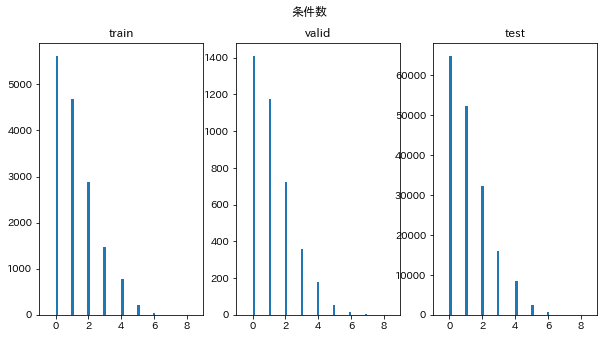

In [185]:
# きれいに分かれているかチェックシステム
# 量的変数の場合

i = 15
max_ = X.loc[:,quantity_features[i]].max()+1
min_ = X.loc[:,quantity_features[i]].min()-1

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.hist(X_train.loc[:,quantity_features[i]], bins=50)
ax1.title.set_text('train')
ax1.set_xlim(min_,max_)
ax2.hist(X_valid.loc[:,quantity_features[i]], bins=50)
ax2.title.set_text('valid')
ax2.set_xlim(min_,max_)
ax3.hist(X_test.loc[:,quantity_features[i]],bins=50)
ax3.title.set_text('test')
ax3.set_xlim(min_,max_)

fig.suptitle(quantity_features[i])
plt.show()

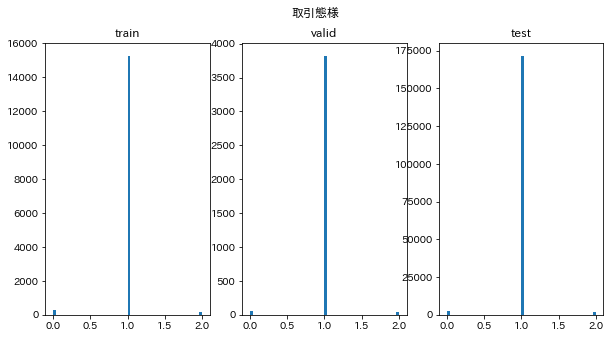

In [196]:
# きれいに分かれているかチェックシステム
# 質的変数の場合

i = 8

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.hist(X_train.loc[:,category_features[i]], bins=50)
ax1.title.set_text('train')
ax2.hist(X_valid.loc[:,category_features[i]], bins=50)
ax2.title.set_text('valid')
ax3.hist(X_test.loc[:,category_features[i]],bins=50)
ax3.title.set_text('test')

fig.suptitle(category_features[i])
plt.show()

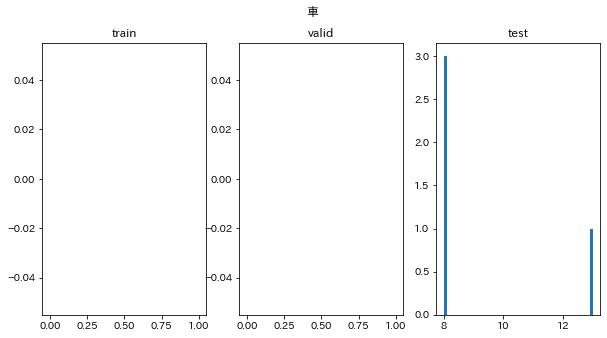

In [197]:
# きれいに分かれているかチェックシステム
# 条件を付けたい場合

i = 3

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

condition1 = X_train.loc[:,features[i]] > 0
condition2 = X_valid.loc[:,features[i]] > 0
condition3 = X_test.loc[:,features[i]] > 0

ax1.hist(X_train.loc[condition1,features[i]], bins=50)
ax1.title.set_text('train')
ax2.hist(X_valid.loc[condition2,features[i]], bins=50)
ax2.title.set_text('valid')
ax3.hist(X_test.loc[condition3,features[i]],bins=50)
ax3.title.set_text('test')

fig.suptitle(features[i])
plt.show()

In [199]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 61.4017
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 52.9934
[3]	valid_0's l2: 46.008
[4]	valid_0's l2: 40.3875
[5]	valid_0's l2: 35.4751
[6]	valid_0's l2: 31.4793
[7]	valid_0's l2: 28.0209
[8]	valid_0's l2: 25.8186
[9]	valid_0's l2: 23.3707
[10]	valid_0's l2: 21.2366
[11]	valid_0's l2: 19.7534
[12]	valid_0's l2: 18.667
[13]	valid_0's l2: 17.439
[14]	valid_0's l2: 16.7114
[15]	valid_0's l2: 15.8276
[16]	valid_0's l2: 14.9377
[17]	valid_0's l2: 14.3302
[18]	valid_0's l2: 13.8041
[19]	valid_0's l2: 13.3714
[20]	valid_0's l2: 12.9234
[21]	valid_0's l2: 12.4791
[22]	valid_0's l2: 11.8707
[23]	valid_0's l2: 11.6169
[24]	valid_0's l2: 11.383
[25]	valid_0's l2: 10.9439
[26]	valid_0's l2: 10.78
[27]	valid_0's l2: 10.4273
[28]	valid_0's l2: 10.3523
[29]	valid_0's l2: 10.2098
[30]	valid_0's l2: 9.89377
[31]	valid_0's l2: 9.59825
[32]	valid_0's l2: 9.50665
[33]	valid_0's l2: 9.43683
[34]	valid_0's l2: 9.21628
[35]	valid_0's l2: 9.14642
[36]	vali

LGBMRegressor(importance_type='gain', random_state=0)

In [200]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [205]:
# それぞれのr2スコアを算出
print('train:',r2_score(y_train,y_train_pred))
print('valid:',r2_score(y_valid,y_valid_pred))
print('test:',r2_score(y_test,y_test_pred))

train: 0.9657777482867452
valid: 0.9229889036175192
test: 0.8700349524405251


In [206]:
# それぞれのMSEを算出
print('train:',mean_squared_error(y_train,y_train_pred))
print('valid:',mean_squared_error(y_valid,y_valid_pred))
print('test:',mean_squared_error(y_test,y_test_pred))

train: 2.7317883018190576
valid: 5.512821339992173
test: 7.977537941801011


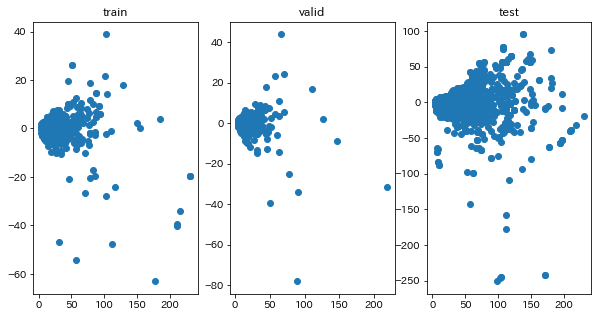

In [207]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [208]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature    importance
0    皇居からの距離  3.973473e+05
1          歩  2.383920e+04
2         バス  1.150210e+02
3          車  0.000000e+00
4   最寄駅からの距離  3.574101e+04
5        部屋数  1.160759e+05
6         面積  3.786009e+06
7        築年数  3.568963e+05
8         階数  9.580749e+04
9         地下  5.747503e+04
10        地上  7.770307e+04
11         階  4.431996e+04
12    オプション数  1.783616e+04
13     駐車場距離  1.924951e+02
14     駐車場料金  6.109050e+03
15       条件数  6.194900e+04
16      市区町村  3.364323e+05
17        路線  1.004516e+04
18         駅  1.645278e+05
19       間取り  4.339474e+05
20        向き  5.408044e+02
21      建物種別  1.419044e+03
22        構造  1.525924e+04
23        入居  3.664418e+04
24      取引態様  0.000000e+00
25     間取り_S  9.819920e+01
26     間取り_L  2.456736e+05
27     間取り_D  6.763009e+02
28     間取り_K  0.000000e+00
29     駐車場有無  9.942217e+02

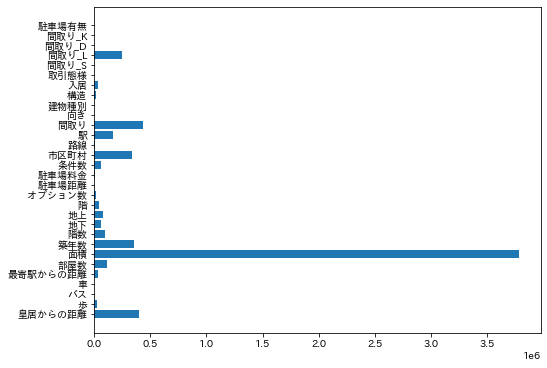

In [212]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# 賃貸を対数変換 + n_estimator
early_stoppingしなかったもので

結論：若干精度が上がった。情報少なめの時ほどの変化はない。
    n_estimatorも若干影響力あるよ。

In [281]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '部屋数',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    'オプション数',
    '駐車場距離',
    '駐車場料金',
    '条件数',
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
    '向き',
    '建物種別',
    '構造',
    '入居',
    '取引態様',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '駐車場有無',
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [282]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [283]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.1
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [284]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 1000,
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0305833
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0260613
[3]	valid_0's l2: 0.022366
[4]	valid_0's l2: 0.0193661
[5]	valid_0's l2: 0.0166918
[6]	valid_0's l2: 0.0144492
[7]	valid_0's l2: 0.0126822
[8]	valid_0's l2: 0.0111649
[9]	valid_0's l2: 0.00987986
[10]	valid_0's l2: 0.00878772
[11]	valid_0's l2: 0.007919
[12]	valid_0's l2: 0.00716714
[13]	valid_0's l2: 0.0065312
[14]	valid_0's l2: 0.0059799
[15]	valid_0's l2: 0.00551022
[16]	valid_0's l2: 0.00511714
[17]	valid_0's l2: 0.00476817
[18]	valid_0's l2: 0.00448162
[19]	valid_0's l2: 0.00421986
[20]	valid_0's l2: 0.00401898
[21]	valid_0's l2: 0.00383133
[22]	valid_0's l2: 0.00366121
[23]	valid_0's l2: 0.00350411
[24]	valid_0's l2: 0.00337325
[25]	valid_0's l2: 0.00327406
[26]	valid_0's l2: 0.00317312
[27]	valid_0's l2: 0.00309048
[28]	valid_0's l2: 0.00301451
[29]	valid_0's l2: 0.00295125
[30]	valid_0's l2: 0.00288806
[31]	valid_0's l2: 0.00284002
[32]	valid_0's l2: 0.00278938
[

[274]	valid_0's l2: 0.00214562
[275]	valid_0's l2: 0.0021449
[276]	valid_0's l2: 0.00214489
[277]	valid_0's l2: 0.00214468
[278]	valid_0's l2: 0.00214448
[279]	valid_0's l2: 0.00214423
[280]	valid_0's l2: 0.00214445
[281]	valid_0's l2: 0.00214362
[282]	valid_0's l2: 0.00214342
[283]	valid_0's l2: 0.00214361
[284]	valid_0's l2: 0.00214386
[285]	valid_0's l2: 0.00214438
[286]	valid_0's l2: 0.00214416
[287]	valid_0's l2: 0.00214326
[288]	valid_0's l2: 0.00214401
[289]	valid_0's l2: 0.00214461
[290]	valid_0's l2: 0.00214443
[291]	valid_0's l2: 0.0021442
[292]	valid_0's l2: 0.00214419
[293]	valid_0's l2: 0.00214451
[294]	valid_0's l2: 0.00214348
[295]	valid_0's l2: 0.00214382
[296]	valid_0's l2: 0.00214341
[297]	valid_0's l2: 0.00214342
Early stopping, best iteration is:
[287]	valid_0's l2: 0.00214326


LGBMRegressor(importance_type='gain', n_estimators=1000, random_state=0)

In [285]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [286]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9863933926245845
valid: 0.8504947032383114
test: 0.8783370489529936


In [287]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 1.0861462643385447
valid: 10.70230173501587
test: 7.467937159372159


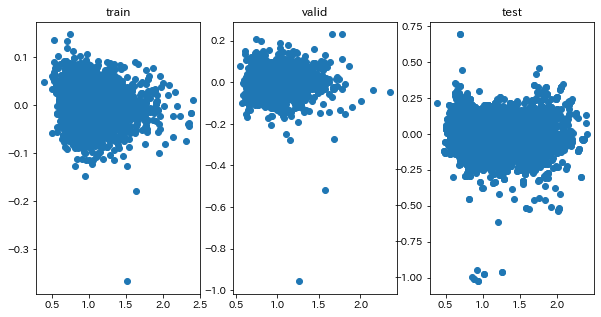

In [288]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [289]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature   importance
0    皇居からの距離    71.680700
1          歩     8.836661
2         バス     0.364793
3          車     0.000000
4   最寄駅からの距離     6.622010
5        部屋数     2.969267
6         面積  1252.337816
7        築年数   182.959674
8         階数    36.781824
9         地下     2.864453
10        地上     9.337809
11         階    13.996380
12    オプション数     8.970858
13     駐車場距離     1.177319
14     駐車場料金     1.160521
15       条件数     2.329187
16      市区町村   268.670501
17        路線    19.372173
18         駅   149.632513
19       間取り   799.337251
20        向き     2.520396
21      建物種別     2.276163
22        構造    39.741035
23        入居     1.224662
24      取引態様     0.109288
25     間取り_S     0.069769
26     間取り_L    73.464673
27     間取り_D     2.096955
28     間取り_K     0.141697
29     駐車場有無     0.086191

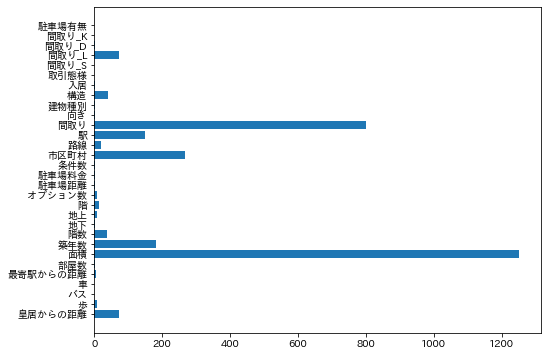

In [290]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# train_valid_testの比率で結果が変わるのか？

結論：結構変わる。train0.7以上で良質。  
    必要なestimatorsも増える。1000以上？

In [263]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '部屋数',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    'オプション数',
    '駐車場距離',
    '駐車場料金',
    '条件数',
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
    '向き',
    '建物種別',
    '構造',
    '入居',
    '取引態様',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '駐車場有無',
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [264]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [301]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]

# scoreを貯める器
scores = []

# trainとtestの比率を変えて検証
for i in range(9):
    # 学習用とテスト用に分割
    train_test = (i+1)/10
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習

    LGBM = lgb.LGBMRegressor(
        n_estimators = 2000,
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 1
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_train_pred = LGBM.predict(X_train)
    y_valid_pred = LGBM.predict(X_valid)
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # 対数から元に戻そう
    test_r2_score = r2_score(10**y_test,10**y_test_pred)
    score = {
        'ratio_train_test':train_test,
        'test_r2_score':test_r2_score
    }
    scores.append(score)

    # それぞれのMSEを算出
    # 対数から元に戻そう
    # print('test:',mean_squared_error(10**y_test,10**y_test_pred))

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0305833
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0260613
[3]	valid_0's l2: 0.022366
[4]	valid_0's l2: 0.0193661
[5]	valid_0's l2: 0.0166918
[6]	valid_0's l2: 0.0144492
[7]	valid_0's l2: 0.0126822
[8]	valid_0's l2: 0.0111649
[9]	valid_0's l2: 0.00987986
[10]	valid_0's l2: 0.00878772
[11]	valid_0's l2: 0.007919
[12]	valid_0's l2: 0.00716714
[13]	valid_0's l2: 0.0065312
[14]	valid_0's l2: 0.0059799
[15]	valid_0's l2: 0.00551022
[16]	valid_0's l2: 0.00511714
[17]	valid_0's l2: 0.00476817
[18]	valid_0's l2: 0.00448162
[19]	valid_0's l2: 0.00421986
[20]	valid_0's l2: 0.00401898
[21]	valid_0's l2: 0.00383133
[22]	valid_0's l2: 0.00366121
[23]	valid_0's l2: 0.00350411
[24]	valid_0's l2: 0.00337325
[25]	valid_0's l2: 0.00327406
[26]	valid_0's l2: 0.00317312
[27]	valid_0's l2: 0.00309048
[28]	valid_0's l2: 0.00301451
[29]	valid_0's l2: 0.00295125
[30]	valid_0's l2: 0.00288806
[31]	valid_0's l2: 0.00284002
[32]	valid_0's l2: 0.00278938
[

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0299838
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.025368
[3]	valid_0's l2: 0.0215794
[4]	valid_0's l2: 0.0184534
[5]	valid_0's l2: 0.0158885
[6]	valid_0's l2: 0.0136796
[7]	valid_0's l2: 0.0119023
[8]	valid_0's l2: 0.0103771
[9]	valid_0's l2: 0.00909728
[10]	valid_0's l2: 0.00803337
[11]	valid_0's l2: 0.00715068
[12]	valid_0's l2: 0.00640138
[13]	valid_0's l2: 0.0058025
[14]	valid_0's l2: 0.00528711
[15]	valid_0's l2: 0.00485496
[16]	valid_0's l2: 0.00446902
[17]	valid_0's l2: 0.00414968
[18]	valid_0's l2: 0.00386251
[19]	valid_0's l2: 0.00363343
[20]	valid_0's l2: 0.00343289
[21]	valid_0's l2: 0.00326662
[22]	valid_0's l2: 0.00311675
[23]	valid_0's l2: 0.00298625
[24]	valid_0's l2: 0.00286758
[25]	valid_0's l2: 0.00277333
[26]	valid_0's l2: 0.00268828
[27]	valid_0's l2: 0.00261293
[28]	valid_0's l2: 0.00254437
[29]	valid_0's l2: 0.00248361
[30]	valid_0's l2: 0.00242373
[31]	valid_0's l2: 0.00237787
[32]	valid_0's l2: 0.0023299

[274]	valid_0's l2: 0.00163029
[275]	valid_0's l2: 0.00162985
[276]	valid_0's l2: 0.00162956
[277]	valid_0's l2: 0.00162934
[278]	valid_0's l2: 0.00162845
[279]	valid_0's l2: 0.00162843
[280]	valid_0's l2: 0.00162804
[281]	valid_0's l2: 0.00162758
[282]	valid_0's l2: 0.00162719
[283]	valid_0's l2: 0.00162673
[284]	valid_0's l2: 0.00162598
[285]	valid_0's l2: 0.00162584
[286]	valid_0's l2: 0.00162604
[287]	valid_0's l2: 0.00162535
[288]	valid_0's l2: 0.00162516
[289]	valid_0's l2: 0.00162469
[290]	valid_0's l2: 0.00162479
[291]	valid_0's l2: 0.00162413
[292]	valid_0's l2: 0.00162395
[293]	valid_0's l2: 0.00162343
[294]	valid_0's l2: 0.00162302
[295]	valid_0's l2: 0.0016227
[296]	valid_0's l2: 0.00162236
[297]	valid_0's l2: 0.00162216
[298]	valid_0's l2: 0.00162193
[299]	valid_0's l2: 0.00162119
[300]	valid_0's l2: 0.00162004
[301]	valid_0's l2: 0.00161895
[302]	valid_0's l2: 0.00161867
[303]	valid_0's l2: 0.00161808
[304]	valid_0's l2: 0.00161814
[305]	valid_0's l2: 0.00161756
[306]	val

[543]	valid_0's l2: 0.00155839
[544]	valid_0's l2: 0.00155805
[545]	valid_0's l2: 0.00155828
[546]	valid_0's l2: 0.00155838
[547]	valid_0's l2: 0.00155819
[548]	valid_0's l2: 0.00155803
[549]	valid_0's l2: 0.00155788
[550]	valid_0's l2: 0.00155748
[551]	valid_0's l2: 0.00155689
[552]	valid_0's l2: 0.00155686
[553]	valid_0's l2: 0.0015565
[554]	valid_0's l2: 0.0015561
[555]	valid_0's l2: 0.00155609
[556]	valid_0's l2: 0.00155604
[557]	valid_0's l2: 0.00155599
[558]	valid_0's l2: 0.00155604
[559]	valid_0's l2: 0.0015556
[560]	valid_0's l2: 0.00155495
[561]	valid_0's l2: 0.00155495
[562]	valid_0's l2: 0.00155466
[563]	valid_0's l2: 0.0015542
[564]	valid_0's l2: 0.00155409
[565]	valid_0's l2: 0.00155357
[566]	valid_0's l2: 0.00155394
[567]	valid_0's l2: 0.00155355
[568]	valid_0's l2: 0.00155346
[569]	valid_0's l2: 0.00155339
[570]	valid_0's l2: 0.00155339
[571]	valid_0's l2: 0.00155339
[572]	valid_0's l2: 0.00155315
[573]	valid_0's l2: 0.00155281
[574]	valid_0's l2: 0.00155241
[575]	valid_

[835]	valid_0's l2: 0.00152438
[836]	valid_0's l2: 0.00152453
[837]	valid_0's l2: 0.00152447
[838]	valid_0's l2: 0.00152432
[839]	valid_0's l2: 0.001524
[840]	valid_0's l2: 0.00152424
[841]	valid_0's l2: 0.00152428
[842]	valid_0's l2: 0.00152392
[843]	valid_0's l2: 0.0015237
[844]	valid_0's l2: 0.00152361
[845]	valid_0's l2: 0.00152368
[846]	valid_0's l2: 0.00152363
[847]	valid_0's l2: 0.00152355
[848]	valid_0's l2: 0.00152303
[849]	valid_0's l2: 0.00152277
[850]	valid_0's l2: 0.00152278
[851]	valid_0's l2: 0.0015227
[852]	valid_0's l2: 0.00152225
[853]	valid_0's l2: 0.00152219
[854]	valid_0's l2: 0.00152212
[855]	valid_0's l2: 0.00152201
[856]	valid_0's l2: 0.00152157
[857]	valid_0's l2: 0.00152149
[858]	valid_0's l2: 0.00152128
[859]	valid_0's l2: 0.00152116
[860]	valid_0's l2: 0.00152124
[861]	valid_0's l2: 0.00152155
[862]	valid_0's l2: 0.00152106
[863]	valid_0's l2: 0.00152114
[864]	valid_0's l2: 0.00152152
[865]	valid_0's l2: 0.00152143
[866]	valid_0's l2: 0.00152125
[867]	valid_

[1099]	valid_0's l2: 0.00150079
[1100]	valid_0's l2: 0.00150054
[1101]	valid_0's l2: 0.00150073
[1102]	valid_0's l2: 0.00150059
[1103]	valid_0's l2: 0.00150043
[1104]	valid_0's l2: 0.00150033
[1105]	valid_0's l2: 0.00150001
[1106]	valid_0's l2: 0.00150002
[1107]	valid_0's l2: 0.00150007
[1108]	valid_0's l2: 0.00149997
[1109]	valid_0's l2: 0.00149976
[1110]	valid_0's l2: 0.00149987
[1111]	valid_0's l2: 0.00149957
[1112]	valid_0's l2: 0.00149934
[1113]	valid_0's l2: 0.00149921
[1114]	valid_0's l2: 0.00149907
[1115]	valid_0's l2: 0.00149893
[1116]	valid_0's l2: 0.00149882
[1117]	valid_0's l2: 0.00149881
[1118]	valid_0's l2: 0.00149871
[1119]	valid_0's l2: 0.00149851
[1120]	valid_0's l2: 0.00149848
[1121]	valid_0's l2: 0.00149841
[1122]	valid_0's l2: 0.00149846
[1123]	valid_0's l2: 0.00149845
[1124]	valid_0's l2: 0.00149849
[1125]	valid_0's l2: 0.00149839
[1126]	valid_0's l2: 0.00149799
[1127]	valid_0's l2: 0.00149803
[1128]	valid_0's l2: 0.00149795
[1129]	valid_0's l2: 0.00149774
[1130]	v

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.028346
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0240244
[3]	valid_0's l2: 0.0204488
[4]	valid_0's l2: 0.0175407
[5]	valid_0's l2: 0.0151333
[6]	valid_0's l2: 0.0130675
[7]	valid_0's l2: 0.0114112
[8]	valid_0's l2: 0.0100081
[9]	valid_0's l2: 0.00884485
[10]	valid_0's l2: 0.00786099
[11]	valid_0's l2: 0.0070662
[12]	valid_0's l2: 0.00639128
[13]	valid_0's l2: 0.00579755
[14]	valid_0's l2: 0.00530431
[15]	valid_0's l2: 0.00489169
[16]	valid_0's l2: 0.00452954
[17]	valid_0's l2: 0.00421905
[18]	valid_0's l2: 0.00395823
[19]	valid_0's l2: 0.00373661
[20]	valid_0's l2: 0.00354495
[21]	valid_0's l2: 0.00338513
[22]	valid_0's l2: 0.00323877
[23]	valid_0's l2: 0.00311653
[24]	valid_0's l2: 0.00301191
[25]	valid_0's l2: 0.00291819
[26]	valid_0's l2: 0.00283785
[27]	valid_0's l2: 0.00275848
[28]	valid_0's l2: 0.00269337
[29]	valid_0's l2: 0.00263532
[30]	valid_0's l2: 0.00258401
[31]	valid_0's l2: 0.00253409
[32]	valid_0's l2: 0.0024913

[294]	valid_0's l2: 0.0017142
[295]	valid_0's l2: 0.00171408
[296]	valid_0's l2: 0.00171402
[297]	valid_0's l2: 0.00171273
[298]	valid_0's l2: 0.00171184
[299]	valid_0's l2: 0.00171121
[300]	valid_0's l2: 0.00171055
[301]	valid_0's l2: 0.00171
[302]	valid_0's l2: 0.00171009
[303]	valid_0's l2: 0.00170974
[304]	valid_0's l2: 0.00170997
[305]	valid_0's l2: 0.00170911
[306]	valid_0's l2: 0.00170855
[307]	valid_0's l2: 0.0017082
[308]	valid_0's l2: 0.001708
[309]	valid_0's l2: 0.00170791
[310]	valid_0's l2: 0.00170727
[311]	valid_0's l2: 0.00170621
[312]	valid_0's l2: 0.00170565
[313]	valid_0's l2: 0.00170507
[314]	valid_0's l2: 0.00170437
[315]	valid_0's l2: 0.00170394
[316]	valid_0's l2: 0.00170359
[317]	valid_0's l2: 0.00170352
[318]	valid_0's l2: 0.00170345
[319]	valid_0's l2: 0.00170213
[320]	valid_0's l2: 0.00170139
[321]	valid_0's l2: 0.00170128
[322]	valid_0's l2: 0.00170072
[323]	valid_0's l2: 0.00170067
[324]	valid_0's l2: 0.00169998
[325]	valid_0's l2: 0.00169871
[326]	valid_0's

[596]	valid_0's l2: 0.00161153
[597]	valid_0's l2: 0.00161152
[598]	valid_0's l2: 0.00161092
[599]	valid_0's l2: 0.00161078
[600]	valid_0's l2: 0.00161042
[601]	valid_0's l2: 0.00161034
[602]	valid_0's l2: 0.00160979
[603]	valid_0's l2: 0.00160946
[604]	valid_0's l2: 0.00160916
[605]	valid_0's l2: 0.00160946
[606]	valid_0's l2: 0.00160948
[607]	valid_0's l2: 0.00160933
[608]	valid_0's l2: 0.00160915
[609]	valid_0's l2: 0.0016087
[610]	valid_0's l2: 0.00160836
[611]	valid_0's l2: 0.00160823
[612]	valid_0's l2: 0.00160796
[613]	valid_0's l2: 0.0016076
[614]	valid_0's l2: 0.00160731
[615]	valid_0's l2: 0.00160698
[616]	valid_0's l2: 0.00160682
[617]	valid_0's l2: 0.00160654
[618]	valid_0's l2: 0.00160638
[619]	valid_0's l2: 0.00160632
[620]	valid_0's l2: 0.00160595
[621]	valid_0's l2: 0.0016057
[622]	valid_0's l2: 0.00160531
[623]	valid_0's l2: 0.00160489
[624]	valid_0's l2: 0.00160445
[625]	valid_0's l2: 0.00160419
[626]	valid_0's l2: 0.0016042
[627]	valid_0's l2: 0.00160393
[628]	valid_

[868]	valid_0's l2: 0.00156315
[869]	valid_0's l2: 0.00156313
[870]	valid_0's l2: 0.00156294
[871]	valid_0's l2: 0.00156275
[872]	valid_0's l2: 0.00156249
[873]	valid_0's l2: 0.00156236
[874]	valid_0's l2: 0.00156223
[875]	valid_0's l2: 0.00156233
[876]	valid_0's l2: 0.00156226
[877]	valid_0's l2: 0.00156185
[878]	valid_0's l2: 0.00156161
[879]	valid_0's l2: 0.00156146
[880]	valid_0's l2: 0.00156145
[881]	valid_0's l2: 0.00156141
[882]	valid_0's l2: 0.00156129
[883]	valid_0's l2: 0.00156103
[884]	valid_0's l2: 0.00156105
[885]	valid_0's l2: 0.00156086
[886]	valid_0's l2: 0.00156065
[887]	valid_0's l2: 0.00156065
[888]	valid_0's l2: 0.00156051
[889]	valid_0's l2: 0.00156015
[890]	valid_0's l2: 0.00155985
[891]	valid_0's l2: 0.00155992
[892]	valid_0's l2: 0.00155975
[893]	valid_0's l2: 0.0015596
[894]	valid_0's l2: 0.0015595
[895]	valid_0's l2: 0.00155926
[896]	valid_0's l2: 0.0015591
[897]	valid_0's l2: 0.00155878
[898]	valid_0's l2: 0.00155861
[899]	valid_0's l2: 0.00155872
[900]	valid

[1160]	valid_0's l2: 0.00152754
[1161]	valid_0's l2: 0.00152752
[1162]	valid_0's l2: 0.00152747
[1163]	valid_0's l2: 0.00152736
[1164]	valid_0's l2: 0.00152726
[1165]	valid_0's l2: 0.00152708
[1166]	valid_0's l2: 0.00152679
[1167]	valid_0's l2: 0.0015266
[1168]	valid_0's l2: 0.00152642
[1169]	valid_0's l2: 0.00152637
[1170]	valid_0's l2: 0.00152603
[1171]	valid_0's l2: 0.00152607
[1172]	valid_0's l2: 0.00152601
[1173]	valid_0's l2: 0.00152589
[1174]	valid_0's l2: 0.00152581
[1175]	valid_0's l2: 0.00152589
[1176]	valid_0's l2: 0.00152567
[1177]	valid_0's l2: 0.0015255
[1178]	valid_0's l2: 0.00152549
[1179]	valid_0's l2: 0.00152546
[1180]	valid_0's l2: 0.00152531
[1181]	valid_0's l2: 0.00152519
[1182]	valid_0's l2: 0.00152497
[1183]	valid_0's l2: 0.00152498
[1184]	valid_0's l2: 0.00152498
[1185]	valid_0's l2: 0.00152478
[1186]	valid_0's l2: 0.00152483
[1187]	valid_0's l2: 0.00152477
[1188]	valid_0's l2: 0.0015245
[1189]	valid_0's l2: 0.0015244
[1190]	valid_0's l2: 0.00152431
[1191]	valid

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0307723
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0260609
[3]	valid_0's l2: 0.0221662
[4]	valid_0's l2: 0.0189899
[5]	valid_0's l2: 0.0163758
[6]	valid_0's l2: 0.0141041
[7]	valid_0's l2: 0.012243
[8]	valid_0's l2: 0.0106808
[9]	valid_0's l2: 0.00939849
[10]	valid_0's l2: 0.00830147
[11]	valid_0's l2: 0.00742588
[12]	valid_0's l2: 0.00666043
[13]	valid_0's l2: 0.00600694
[14]	valid_0's l2: 0.00546981
[15]	valid_0's l2: 0.00499496
[16]	valid_0's l2: 0.0045906
[17]	valid_0's l2: 0.00425995
[18]	valid_0's l2: 0.00395959
[19]	valid_0's l2: 0.00372314
[20]	valid_0's l2: 0.00350432
[21]	valid_0's l2: 0.00332636
[22]	valid_0's l2: 0.0031678
[23]	valid_0's l2: 0.0030308
[24]	valid_0's l2: 0.00291503
[25]	valid_0's l2: 0.00281203
[26]	valid_0's l2: 0.00271612
[27]	valid_0's l2: 0.00262855
[28]	valid_0's l2: 0.00255759
[29]	valid_0's l2: 0.00249411
[30]	valid_0's l2: 0.00243459
[31]	valid_0's l2: 0.00238225
[32]	valid_0's l2: 0.00233298


[290]	valid_0's l2: 0.00147563
[291]	valid_0's l2: 0.00147501
[292]	valid_0's l2: 0.0014745
[293]	valid_0's l2: 0.00147361
[294]	valid_0's l2: 0.00147264
[295]	valid_0's l2: 0.00147264
[296]	valid_0's l2: 0.00147263
[297]	valid_0's l2: 0.00147226
[298]	valid_0's l2: 0.00147228
[299]	valid_0's l2: 0.00147143
[300]	valid_0's l2: 0.00147083
[301]	valid_0's l2: 0.00147039
[302]	valid_0's l2: 0.0014698
[303]	valid_0's l2: 0.00146946
[304]	valid_0's l2: 0.00146919
[305]	valid_0's l2: 0.00146871
[306]	valid_0's l2: 0.00146831
[307]	valid_0's l2: 0.00146794
[308]	valid_0's l2: 0.00146763
[309]	valid_0's l2: 0.0014675
[310]	valid_0's l2: 0.00146721
[311]	valid_0's l2: 0.00146648
[312]	valid_0's l2: 0.00146538
[313]	valid_0's l2: 0.00146458
[314]	valid_0's l2: 0.00146382
[315]	valid_0's l2: 0.00146337
[316]	valid_0's l2: 0.0014628
[317]	valid_0's l2: 0.00146146
[318]	valid_0's l2: 0.00146038
[319]	valid_0's l2: 0.00145952
[320]	valid_0's l2: 0.00145889
[321]	valid_0's l2: 0.00145848
[322]	valid_

[583]	valid_0's l2: 0.00136143
[584]	valid_0's l2: 0.00136136
[585]	valid_0's l2: 0.00136114
[586]	valid_0's l2: 0.00136102
[587]	valid_0's l2: 0.0013606
[588]	valid_0's l2: 0.00136019
[589]	valid_0's l2: 0.0013599
[590]	valid_0's l2: 0.00135943
[591]	valid_0's l2: 0.00135915
[592]	valid_0's l2: 0.00135902
[593]	valid_0's l2: 0.00135882
[594]	valid_0's l2: 0.00135864
[595]	valid_0's l2: 0.00135832
[596]	valid_0's l2: 0.00135835
[597]	valid_0's l2: 0.00135813
[598]	valid_0's l2: 0.001358
[599]	valid_0's l2: 0.00135799
[600]	valid_0's l2: 0.00135788
[601]	valid_0's l2: 0.00135754
[602]	valid_0's l2: 0.00135737
[603]	valid_0's l2: 0.00135699
[604]	valid_0's l2: 0.00135666
[605]	valid_0's l2: 0.00135619
[606]	valid_0's l2: 0.00135587
[607]	valid_0's l2: 0.00135572
[608]	valid_0's l2: 0.00135568
[609]	valid_0's l2: 0.00135545
[610]	valid_0's l2: 0.00135516
[611]	valid_0's l2: 0.00135507
[612]	valid_0's l2: 0.00135483
[613]	valid_0's l2: 0.00135471
[614]	valid_0's l2: 0.001354
[615]	valid_0'

[870]	valid_0's l2: 0.00129981
[871]	valid_0's l2: 0.00129958
[872]	valid_0's l2: 0.00129947
[873]	valid_0's l2: 0.00129953
[874]	valid_0's l2: 0.00129924
[875]	valid_0's l2: 0.00129916
[876]	valid_0's l2: 0.00129895
[877]	valid_0's l2: 0.00129866
[878]	valid_0's l2: 0.00129828
[879]	valid_0's l2: 0.00129807
[880]	valid_0's l2: 0.00129772
[881]	valid_0's l2: 0.00129763
[882]	valid_0's l2: 0.00129746
[883]	valid_0's l2: 0.001297
[884]	valid_0's l2: 0.00129692
[885]	valid_0's l2: 0.00129664
[886]	valid_0's l2: 0.0012964
[887]	valid_0's l2: 0.00129641
[888]	valid_0's l2: 0.00129633
[889]	valid_0's l2: 0.00129613
[890]	valid_0's l2: 0.00129584
[891]	valid_0's l2: 0.0012957
[892]	valid_0's l2: 0.00129558
[893]	valid_0's l2: 0.00129552
[894]	valid_0's l2: 0.00129542
[895]	valid_0's l2: 0.00129545
[896]	valid_0's l2: 0.00129534
[897]	valid_0's l2: 0.00129511
[898]	valid_0's l2: 0.00129496
[899]	valid_0's l2: 0.00129448
[900]	valid_0's l2: 0.00129402
[901]	valid_0's l2: 0.00129411
[902]	valid_

[1142]	valid_0's l2: 0.00126058
[1143]	valid_0's l2: 0.00126034
[1144]	valid_0's l2: 0.00126012
[1145]	valid_0's l2: 0.00126003
[1146]	valid_0's l2: 0.00125988
[1147]	valid_0's l2: 0.00125985
[1148]	valid_0's l2: 0.00125973
[1149]	valid_0's l2: 0.00125973
[1150]	valid_0's l2: 0.00125964
[1151]	valid_0's l2: 0.00125957
[1152]	valid_0's l2: 0.00125941
[1153]	valid_0's l2: 0.00125924
[1154]	valid_0's l2: 0.00125914
[1155]	valid_0's l2: 0.00125898
[1156]	valid_0's l2: 0.00125881
[1157]	valid_0's l2: 0.0012584
[1158]	valid_0's l2: 0.00125807
[1159]	valid_0's l2: 0.00125793
[1160]	valid_0's l2: 0.00125786
[1161]	valid_0's l2: 0.00125764
[1162]	valid_0's l2: 0.00125762
[1163]	valid_0's l2: 0.00125736
[1164]	valid_0's l2: 0.00125714
[1165]	valid_0's l2: 0.001257
[1166]	valid_0's l2: 0.00125688
[1167]	valid_0's l2: 0.00125672
[1168]	valid_0's l2: 0.00125646
[1169]	valid_0's l2: 0.00125645
[1170]	valid_0's l2: 0.00125632
[1171]	valid_0's l2: 0.0012563
[1172]	valid_0's l2: 0.00125623
[1173]	valid

[1431]	valid_0's l2: 0.00122822
[1432]	valid_0's l2: 0.00122817
[1433]	valid_0's l2: 0.00122823
[1434]	valid_0's l2: 0.00122828
[1435]	valid_0's l2: 0.00122819
[1436]	valid_0's l2: 0.00122794
[1437]	valid_0's l2: 0.00122795
[1438]	valid_0's l2: 0.00122794
[1439]	valid_0's l2: 0.00122787
[1440]	valid_0's l2: 0.00122787
[1441]	valid_0's l2: 0.00122798
[1442]	valid_0's l2: 0.00122782
[1443]	valid_0's l2: 0.00122778
[1444]	valid_0's l2: 0.00122771
[1445]	valid_0's l2: 0.00122754
[1446]	valid_0's l2: 0.00122733
[1447]	valid_0's l2: 0.0012274
[1448]	valid_0's l2: 0.00122736
[1449]	valid_0's l2: 0.0012272
[1450]	valid_0's l2: 0.00122716
[1451]	valid_0's l2: 0.00122697
[1452]	valid_0's l2: 0.00122693
[1453]	valid_0's l2: 0.00122674
[1454]	valid_0's l2: 0.00122667
[1455]	valid_0's l2: 0.00122654
[1456]	valid_0's l2: 0.0012265
[1457]	valid_0's l2: 0.00122639
[1458]	valid_0's l2: 0.00122641
[1459]	valid_0's l2: 0.00122635
[1460]	valid_0's l2: 0.00122628
[1461]	valid_0's l2: 0.00122615
[1462]	vali

[1689]	valid_0's l2: 0.00120587
[1690]	valid_0's l2: 0.00120585
[1691]	valid_0's l2: 0.00120575
[1692]	valid_0's l2: 0.0012056
[1693]	valid_0's l2: 0.0012055
[1694]	valid_0's l2: 0.00120547
[1695]	valid_0's l2: 0.00120538
[1696]	valid_0's l2: 0.00120527
[1697]	valid_0's l2: 0.00120519
[1698]	valid_0's l2: 0.00120498
[1699]	valid_0's l2: 0.0012049
[1700]	valid_0's l2: 0.00120476
[1701]	valid_0's l2: 0.00120471
[1702]	valid_0's l2: 0.00120481
[1703]	valid_0's l2: 0.00120485
[1704]	valid_0's l2: 0.00120465
[1705]	valid_0's l2: 0.00120473
[1706]	valid_0's l2: 0.00120471
[1707]	valid_0's l2: 0.00120469
[1708]	valid_0's l2: 0.0012045
[1709]	valid_0's l2: 0.00120438
[1710]	valid_0's l2: 0.00120435
[1711]	valid_0's l2: 0.00120427
[1712]	valid_0's l2: 0.0012042
[1713]	valid_0's l2: 0.00120415
[1714]	valid_0's l2: 0.00120405
[1715]	valid_0's l2: 0.001204
[1716]	valid_0's l2: 0.00120402
[1717]	valid_0's l2: 0.00120394
[1718]	valid_0's l2: 0.00120384
[1719]	valid_0's l2: 0.00120378
[1720]	valid_0'

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0294546
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0248944
[3]	valid_0's l2: 0.0211827
[4]	valid_0's l2: 0.0181154
[5]	valid_0's l2: 0.0155938
[6]	valid_0's l2: 0.0134451
[7]	valid_0's l2: 0.0116645
[8]	valid_0's l2: 0.0101805
[9]	valid_0's l2: 0.00898214
[10]	valid_0's l2: 0.0079546
[11]	valid_0's l2: 0.00707611
[12]	valid_0's l2: 0.00635714
[13]	valid_0's l2: 0.00573582
[14]	valid_0's l2: 0.00523407
[15]	valid_0's l2: 0.00477509
[16]	valid_0's l2: 0.0043936
[17]	valid_0's l2: 0.00407133
[18]	valid_0's l2: 0.00379876
[19]	valid_0's l2: 0.00357096
[20]	valid_0's l2: 0.00336725
[21]	valid_0's l2: 0.00319245
[22]	valid_0's l2: 0.00304657
[23]	valid_0's l2: 0.00291861
[24]	valid_0's l2: 0.0028019
[25]	valid_0's l2: 0.00270139
[26]	valid_0's l2: 0.00261147
[27]	valid_0's l2: 0.00253491
[28]	valid_0's l2: 0.00246283
[29]	valid_0's l2: 0.0024008
[30]	valid_0's l2: 0.00234331
[31]	valid_0's l2: 0.00229708
[32]	valid_0's l2: 0.00225241


[297]	valid_0's l2: 0.00139689
[298]	valid_0's l2: 0.00139637
[299]	valid_0's l2: 0.00139504
[300]	valid_0's l2: 0.00139388
[301]	valid_0's l2: 0.00139286
[302]	valid_0's l2: 0.00139161
[303]	valid_0's l2: 0.00139141
[304]	valid_0's l2: 0.00139055
[305]	valid_0's l2: 0.00138916
[306]	valid_0's l2: 0.00138885
[307]	valid_0's l2: 0.00138846
[308]	valid_0's l2: 0.00138764
[309]	valid_0's l2: 0.00138727
[310]	valid_0's l2: 0.00138676
[311]	valid_0's l2: 0.00138633
[312]	valid_0's l2: 0.00138542
[313]	valid_0's l2: 0.00138407
[314]	valid_0's l2: 0.00138353
[315]	valid_0's l2: 0.0013835
[316]	valid_0's l2: 0.00138289
[317]	valid_0's l2: 0.00138256
[318]	valid_0's l2: 0.00138185
[319]	valid_0's l2: 0.0013808
[320]	valid_0's l2: 0.00137925
[321]	valid_0's l2: 0.0013788
[322]	valid_0's l2: 0.00137746
[323]	valid_0's l2: 0.00137701
[324]	valid_0's l2: 0.0013769
[325]	valid_0's l2: 0.00137651
[326]	valid_0's l2: 0.00137594
[327]	valid_0's l2: 0.00137529
[328]	valid_0's l2: 0.00137461
[329]	valid_

[563]	valid_0's l2: 0.00127236
[564]	valid_0's l2: 0.00127184
[565]	valid_0's l2: 0.00127153
[566]	valid_0's l2: 0.00127138
[567]	valid_0's l2: 0.00127121
[568]	valid_0's l2: 0.0012708
[569]	valid_0's l2: 0.00127077
[570]	valid_0's l2: 0.00127057
[571]	valid_0's l2: 0.00127015
[572]	valid_0's l2: 0.00126986
[573]	valid_0's l2: 0.0012694
[574]	valid_0's l2: 0.00126943
[575]	valid_0's l2: 0.00126913
[576]	valid_0's l2: 0.00126834
[577]	valid_0's l2: 0.00126806
[578]	valid_0's l2: 0.00126746
[579]	valid_0's l2: 0.00126696
[580]	valid_0's l2: 0.00126675
[581]	valid_0's l2: 0.00126636
[582]	valid_0's l2: 0.0012664
[583]	valid_0's l2: 0.00126604
[584]	valid_0's l2: 0.00126579
[585]	valid_0's l2: 0.00126582
[586]	valid_0's l2: 0.00126568
[587]	valid_0's l2: 0.00126542
[588]	valid_0's l2: 0.00126511
[589]	valid_0's l2: 0.0012648
[590]	valid_0's l2: 0.00126468
[591]	valid_0's l2: 0.00126404
[592]	valid_0's l2: 0.00126379
[593]	valid_0's l2: 0.00126358
[594]	valid_0's l2: 0.0012632
[595]	valid_0

[853]	valid_0's l2: 0.00119804
[854]	valid_0's l2: 0.00119797
[855]	valid_0's l2: 0.00119771
[856]	valid_0's l2: 0.00119764
[857]	valid_0's l2: 0.00119744
[858]	valid_0's l2: 0.00119713
[859]	valid_0's l2: 0.00119724
[860]	valid_0's l2: 0.00119702
[861]	valid_0's l2: 0.0011969
[862]	valid_0's l2: 0.00119684
[863]	valid_0's l2: 0.00119672
[864]	valid_0's l2: 0.00119661
[865]	valid_0's l2: 0.00119649
[866]	valid_0's l2: 0.00119647
[867]	valid_0's l2: 0.00119641
[868]	valid_0's l2: 0.00119642
[869]	valid_0's l2: 0.00119611
[870]	valid_0's l2: 0.00119579
[871]	valid_0's l2: 0.0011955
[872]	valid_0's l2: 0.00119504
[873]	valid_0's l2: 0.00119467
[874]	valid_0's l2: 0.00119453
[875]	valid_0's l2: 0.00119421
[876]	valid_0's l2: 0.00119405
[877]	valid_0's l2: 0.0011939
[878]	valid_0's l2: 0.00119379
[879]	valid_0's l2: 0.00119356
[880]	valid_0's l2: 0.0011934
[881]	valid_0's l2: 0.00119327
[882]	valid_0's l2: 0.00119302
[883]	valid_0's l2: 0.0011927
[884]	valid_0's l2: 0.00119252
[885]	valid_0

[1128]	valid_0's l2: 0.00115328
[1129]	valid_0's l2: 0.00115316
[1130]	valid_0's l2: 0.00115309
[1131]	valid_0's l2: 0.00115294
[1132]	valid_0's l2: 0.00115276
[1133]	valid_0's l2: 0.00115267
[1134]	valid_0's l2: 0.00115268
[1135]	valid_0's l2: 0.00115249
[1136]	valid_0's l2: 0.00115229
[1137]	valid_0's l2: 0.00115209
[1138]	valid_0's l2: 0.00115193
[1139]	valid_0's l2: 0.0011517
[1140]	valid_0's l2: 0.00115165
[1141]	valid_0's l2: 0.00115137
[1142]	valid_0's l2: 0.00115132
[1143]	valid_0's l2: 0.00115125
[1144]	valid_0's l2: 0.00115108
[1145]	valid_0's l2: 0.00115097
[1146]	valid_0's l2: 0.00115101
[1147]	valid_0's l2: 0.00115093
[1148]	valid_0's l2: 0.0011506
[1149]	valid_0's l2: 0.00115042
[1150]	valid_0's l2: 0.00115032
[1151]	valid_0's l2: 0.00115015
[1152]	valid_0's l2: 0.00115002
[1153]	valid_0's l2: 0.00114995
[1154]	valid_0's l2: 0.00114961
[1155]	valid_0's l2: 0.0011494
[1156]	valid_0's l2: 0.00114937
[1157]	valid_0's l2: 0.00114929
[1158]	valid_0's l2: 0.00114909
[1159]	vali

[1419]	valid_0's l2: 0.00111524
[1420]	valid_0's l2: 0.00111508
[1421]	valid_0's l2: 0.00111503
[1422]	valid_0's l2: 0.00111483
[1423]	valid_0's l2: 0.00111484
[1424]	valid_0's l2: 0.00111475
[1425]	valid_0's l2: 0.00111464
[1426]	valid_0's l2: 0.00111461
[1427]	valid_0's l2: 0.00111434
[1428]	valid_0's l2: 0.00111431
[1429]	valid_0's l2: 0.00111425
[1430]	valid_0's l2: 0.00111419
[1431]	valid_0's l2: 0.0011142
[1432]	valid_0's l2: 0.00111421
[1433]	valid_0's l2: 0.00111409
[1434]	valid_0's l2: 0.00111401
[1435]	valid_0's l2: 0.00111371
[1436]	valid_0's l2: 0.00111366
[1437]	valid_0's l2: 0.00111352
[1438]	valid_0's l2: 0.00111343
[1439]	valid_0's l2: 0.00111326
[1440]	valid_0's l2: 0.00111315
[1441]	valid_0's l2: 0.00111307
[1442]	valid_0's l2: 0.00111303
[1443]	valid_0's l2: 0.00111284
[1444]	valid_0's l2: 0.0011127
[1445]	valid_0's l2: 0.0011125
[1446]	valid_0's l2: 0.00111238
[1447]	valid_0's l2: 0.00111248
[1448]	valid_0's l2: 0.00111236
[1449]	valid_0's l2: 0.00111228
[1450]	vali

[1681]	valid_0's l2: 0.00108818
[1682]	valid_0's l2: 0.00108821
[1683]	valid_0's l2: 0.00108827
[1684]	valid_0's l2: 0.00108817
[1685]	valid_0's l2: 0.00108812
[1686]	valid_0's l2: 0.00108813
[1687]	valid_0's l2: 0.001088
[1688]	valid_0's l2: 0.00108794
[1689]	valid_0's l2: 0.00108785
[1690]	valid_0's l2: 0.00108767
[1691]	valid_0's l2: 0.00108758
[1692]	valid_0's l2: 0.0010875
[1693]	valid_0's l2: 0.00108748
[1694]	valid_0's l2: 0.0010873
[1695]	valid_0's l2: 0.00108722
[1696]	valid_0's l2: 0.00108699
[1697]	valid_0's l2: 0.00108688
[1698]	valid_0's l2: 0.00108673
[1699]	valid_0's l2: 0.00108666
[1700]	valid_0's l2: 0.00108669
[1701]	valid_0's l2: 0.00108662
[1702]	valid_0's l2: 0.00108659
[1703]	valid_0's l2: 0.00108646
[1704]	valid_0's l2: 0.0010864
[1705]	valid_0's l2: 0.00108633
[1706]	valid_0's l2: 0.00108624
[1707]	valid_0's l2: 0.00108625
[1708]	valid_0's l2: 0.00108615
[1709]	valid_0's l2: 0.00108608
[1710]	valid_0's l2: 0.00108588
[1711]	valid_0's l2: 0.00108567
[1712]	valid_

[1945]	valid_0's l2: 0.00106657
[1946]	valid_0's l2: 0.00106649
[1947]	valid_0's l2: 0.00106637
[1948]	valid_0's l2: 0.00106621
[1949]	valid_0's l2: 0.00106613
[1950]	valid_0's l2: 0.00106606
[1951]	valid_0's l2: 0.00106599
[1952]	valid_0's l2: 0.00106586
[1953]	valid_0's l2: 0.00106575
[1954]	valid_0's l2: 0.00106575
[1955]	valid_0's l2: 0.00106569
[1956]	valid_0's l2: 0.00106567
[1957]	valid_0's l2: 0.00106558
[1958]	valid_0's l2: 0.00106559
[1959]	valid_0's l2: 0.00106557
[1960]	valid_0's l2: 0.00106558
[1961]	valid_0's l2: 0.00106547
[1962]	valid_0's l2: 0.00106536
[1963]	valid_0's l2: 0.00106529
[1964]	valid_0's l2: 0.00106519
[1965]	valid_0's l2: 0.00106515
[1966]	valid_0's l2: 0.00106509
[1967]	valid_0's l2: 0.00106509
[1968]	valid_0's l2: 0.00106499
[1969]	valid_0's l2: 0.00106501
[1970]	valid_0's l2: 0.00106485
[1971]	valid_0's l2: 0.00106481
[1972]	valid_0's l2: 0.00106478
[1973]	valid_0's l2: 0.00106474
[1974]	valid_0's l2: 0.00106458
[1975]	valid_0's l2: 0.00106451
[1976]	v

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0300095
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.025419
[3]	valid_0's l2: 0.0216631
[4]	valid_0's l2: 0.0185734
[5]	valid_0's l2: 0.0160286
[6]	valid_0's l2: 0.0138273
[7]	valid_0's l2: 0.0120558
[8]	valid_0's l2: 0.0105437
[9]	valid_0's l2: 0.00927386
[10]	valid_0's l2: 0.00821167
[11]	valid_0's l2: 0.00732695
[12]	valid_0's l2: 0.00658204
[13]	valid_0's l2: 0.00594897
[14]	valid_0's l2: 0.00540846
[15]	valid_0's l2: 0.00495846
[16]	valid_0's l2: 0.00457135
[17]	valid_0's l2: 0.00424683
[18]	valid_0's l2: 0.00395939
[19]	valid_0's l2: 0.00371756
[20]	valid_0's l2: 0.00350766
[21]	valid_0's l2: 0.00332751
[22]	valid_0's l2: 0.00316868
[23]	valid_0's l2: 0.00302912
[24]	valid_0's l2: 0.00291082
[25]	valid_0's l2: 0.0028057
[26]	valid_0's l2: 0.00271527
[27]	valid_0's l2: 0.0026319
[28]	valid_0's l2: 0.00255859
[29]	valid_0's l2: 0.00249709
[30]	valid_0's l2: 0.00244014
[31]	valid_0's l2: 0.00238307
[32]	valid_0's l2: 0.00233756

[289]	valid_0's l2: 0.0014192
[290]	valid_0's l2: 0.00141875
[291]	valid_0's l2: 0.00141787
[292]	valid_0's l2: 0.0014166
[293]	valid_0's l2: 0.00141657
[294]	valid_0's l2: 0.00141549
[295]	valid_0's l2: 0.00141504
[296]	valid_0's l2: 0.00141435
[297]	valid_0's l2: 0.00141348
[298]	valid_0's l2: 0.00141281
[299]	valid_0's l2: 0.00141295
[300]	valid_0's l2: 0.00141236
[301]	valid_0's l2: 0.00141201
[302]	valid_0's l2: 0.00141085
[303]	valid_0's l2: 0.00141063
[304]	valid_0's l2: 0.00141032
[305]	valid_0's l2: 0.00140933
[306]	valid_0's l2: 0.00140885
[307]	valid_0's l2: 0.0014078
[308]	valid_0's l2: 0.00140745
[309]	valid_0's l2: 0.00140644
[310]	valid_0's l2: 0.0014056
[311]	valid_0's l2: 0.0014052
[312]	valid_0's l2: 0.00140445
[313]	valid_0's l2: 0.0014039
[314]	valid_0's l2: 0.00140348
[315]	valid_0's l2: 0.00140235
[316]	valid_0's l2: 0.00140138
[317]	valid_0's l2: 0.00140058
[318]	valid_0's l2: 0.00140032
[319]	valid_0's l2: 0.00139963
[320]	valid_0's l2: 0.00139924
[321]	valid_0'

[584]	valid_0's l2: 0.00128742
[585]	valid_0's l2: 0.00128705
[586]	valid_0's l2: 0.00128695
[587]	valid_0's l2: 0.00128621
[588]	valid_0's l2: 0.00128606
[589]	valid_0's l2: 0.00128569
[590]	valid_0's l2: 0.00128541
[591]	valid_0's l2: 0.00128532
[592]	valid_0's l2: 0.00128477
[593]	valid_0's l2: 0.00128437
[594]	valid_0's l2: 0.00128394
[595]	valid_0's l2: 0.00128348
[596]	valid_0's l2: 0.00128303
[597]	valid_0's l2: 0.00128282
[598]	valid_0's l2: 0.00128251
[599]	valid_0's l2: 0.00128238
[600]	valid_0's l2: 0.00128218
[601]	valid_0's l2: 0.00128207
[602]	valid_0's l2: 0.00128204
[603]	valid_0's l2: 0.0012816
[604]	valid_0's l2: 0.00128086
[605]	valid_0's l2: 0.00128044
[606]	valid_0's l2: 0.00128037
[607]	valid_0's l2: 0.00128022
[608]	valid_0's l2: 0.00128015
[609]	valid_0's l2: 0.00127976
[610]	valid_0's l2: 0.00127938
[611]	valid_0's l2: 0.00127894
[612]	valid_0's l2: 0.00127861
[613]	valid_0's l2: 0.00127853
[614]	valid_0's l2: 0.00127807
[615]	valid_0's l2: 0.00127807
[616]	val

[856]	valid_0's l2: 0.00121866
[857]	valid_0's l2: 0.00121854
[858]	valid_0's l2: 0.00121846
[859]	valid_0's l2: 0.00121827
[860]	valid_0's l2: 0.00121811
[861]	valid_0's l2: 0.00121794
[862]	valid_0's l2: 0.00121759
[863]	valid_0's l2: 0.00121728
[864]	valid_0's l2: 0.00121673
[865]	valid_0's l2: 0.00121646
[866]	valid_0's l2: 0.00121636
[867]	valid_0's l2: 0.00121626
[868]	valid_0's l2: 0.00121618
[869]	valid_0's l2: 0.00121597
[870]	valid_0's l2: 0.00121585
[871]	valid_0's l2: 0.00121561
[872]	valid_0's l2: 0.00121535
[873]	valid_0's l2: 0.00121504
[874]	valid_0's l2: 0.00121497
[875]	valid_0's l2: 0.00121463
[876]	valid_0's l2: 0.00121452
[877]	valid_0's l2: 0.00121411
[878]	valid_0's l2: 0.00121394
[879]	valid_0's l2: 0.00121336
[880]	valid_0's l2: 0.00121303
[881]	valid_0's l2: 0.00121273
[882]	valid_0's l2: 0.00121245
[883]	valid_0's l2: 0.00121233
[884]	valid_0's l2: 0.00121216
[885]	valid_0's l2: 0.00121197
[886]	valid_0's l2: 0.00121192
[887]	valid_0's l2: 0.00121186
[888]	va

[1145]	valid_0's l2: 0.0011679
[1146]	valid_0's l2: 0.00116792
[1147]	valid_0's l2: 0.00116771
[1148]	valid_0's l2: 0.00116754
[1149]	valid_0's l2: 0.00116744
[1150]	valid_0's l2: 0.00116734
[1151]	valid_0's l2: 0.001167
[1152]	valid_0's l2: 0.00116698
[1153]	valid_0's l2: 0.0011669
[1154]	valid_0's l2: 0.00116672
[1155]	valid_0's l2: 0.00116657
[1156]	valid_0's l2: 0.00116647
[1157]	valid_0's l2: 0.00116649
[1158]	valid_0's l2: 0.00116623
[1159]	valid_0's l2: 0.00116601
[1160]	valid_0's l2: 0.00116588
[1161]	valid_0's l2: 0.00116571
[1162]	valid_0's l2: 0.00116561
[1163]	valid_0's l2: 0.00116551
[1164]	valid_0's l2: 0.00116537
[1165]	valid_0's l2: 0.00116514
[1166]	valid_0's l2: 0.00116494
[1167]	valid_0's l2: 0.00116472
[1168]	valid_0's l2: 0.00116465
[1169]	valid_0's l2: 0.0011645
[1170]	valid_0's l2: 0.00116427
[1171]	valid_0's l2: 0.00116424
[1172]	valid_0's l2: 0.00116423
[1173]	valid_0's l2: 0.00116413
[1174]	valid_0's l2: 0.00116391
[1175]	valid_0's l2: 0.00116376
[1176]	valid_

[1404]	valid_0's l2: 0.00113155
[1405]	valid_0's l2: 0.00113149
[1406]	valid_0's l2: 0.00113135
[1407]	valid_0's l2: 0.00113127
[1408]	valid_0's l2: 0.00113123
[1409]	valid_0's l2: 0.00113133
[1410]	valid_0's l2: 0.00113124
[1411]	valid_0's l2: 0.00113125
[1412]	valid_0's l2: 0.0011311
[1413]	valid_0's l2: 0.00113086
[1414]	valid_0's l2: 0.00113065
[1415]	valid_0's l2: 0.00113053
[1416]	valid_0's l2: 0.00113049
[1417]	valid_0's l2: 0.00113028
[1418]	valid_0's l2: 0.00113011
[1419]	valid_0's l2: 0.00113005
[1420]	valid_0's l2: 0.00112996
[1421]	valid_0's l2: 0.00112966
[1422]	valid_0's l2: 0.00112943
[1423]	valid_0's l2: 0.00112934
[1424]	valid_0's l2: 0.00112935
[1425]	valid_0's l2: 0.0011293
[1426]	valid_0's l2: 0.00112923
[1427]	valid_0's l2: 0.00112896
[1428]	valid_0's l2: 0.00112881
[1429]	valid_0's l2: 0.0011287
[1430]	valid_0's l2: 0.0011285
[1431]	valid_0's l2: 0.00112834
[1432]	valid_0's l2: 0.0011287
[1433]	valid_0's l2: 0.00112878
[1434]	valid_0's l2: 0.00112875
[1435]	valid_

[1669]	valid_0's l2: 0.00110254
[1670]	valid_0's l2: 0.00110245
[1671]	valid_0's l2: 0.00110237
[1672]	valid_0's l2: 0.00110234
[1673]	valid_0's l2: 0.00110222
[1674]	valid_0's l2: 0.00110216
[1675]	valid_0's l2: 0.00110209
[1676]	valid_0's l2: 0.00110211
[1677]	valid_0's l2: 0.00110201
[1678]	valid_0's l2: 0.00110189
[1679]	valid_0's l2: 0.00110176
[1680]	valid_0's l2: 0.00110165
[1681]	valid_0's l2: 0.00110157
[1682]	valid_0's l2: 0.00110145
[1683]	valid_0's l2: 0.00110131
[1684]	valid_0's l2: 0.00110122
[1685]	valid_0's l2: 0.00110118
[1686]	valid_0's l2: 0.00110107
[1687]	valid_0's l2: 0.00110103
[1688]	valid_0's l2: 0.00110089
[1689]	valid_0's l2: 0.00110097
[1690]	valid_0's l2: 0.00110084
[1691]	valid_0's l2: 0.00110088
[1692]	valid_0's l2: 0.00110076
[1693]	valid_0's l2: 0.00110069
[1694]	valid_0's l2: 0.00110064
[1695]	valid_0's l2: 0.00110056
[1696]	valid_0's l2: 0.00110046
[1697]	valid_0's l2: 0.00110037
[1698]	valid_0's l2: 0.00110015
[1699]	valid_0's l2: 0.00109998
[1700]	v

[1945]	valid_0's l2: 0.00107694
[1946]	valid_0's l2: 0.00107682
[1947]	valid_0's l2: 0.0010766
[1948]	valid_0's l2: 0.00107637
[1949]	valid_0's l2: 0.00107624
[1950]	valid_0's l2: 0.00107621
[1951]	valid_0's l2: 0.00107608
[1952]	valid_0's l2: 0.00107591
[1953]	valid_0's l2: 0.00107591
[1954]	valid_0's l2: 0.0010758
[1955]	valid_0's l2: 0.00107563
[1956]	valid_0's l2: 0.00107557
[1957]	valid_0's l2: 0.00107545
[1958]	valid_0's l2: 0.00107536
[1959]	valid_0's l2: 0.0010753
[1960]	valid_0's l2: 0.00107523
[1961]	valid_0's l2: 0.00107506
[1962]	valid_0's l2: 0.00107501
[1963]	valid_0's l2: 0.00107497
[1964]	valid_0's l2: 0.00107503
[1965]	valid_0's l2: 0.00107489
[1966]	valid_0's l2: 0.00107483
[1967]	valid_0's l2: 0.00107475
[1968]	valid_0's l2: 0.00107466
[1969]	valid_0's l2: 0.00107463
[1970]	valid_0's l2: 0.00107458
[1971]	valid_0's l2: 0.00107442
[1972]	valid_0's l2: 0.00107435
[1973]	valid_0's l2: 0.00107424
[1974]	valid_0's l2: 0.00107428
[1975]	valid_0's l2: 0.00107423
[1976]	vali

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0299088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.02533
[3]	valid_0's l2: 0.0215657
[4]	valid_0's l2: 0.0184663
[5]	valid_0's l2: 0.0159227
[6]	valid_0's l2: 0.0137112
[7]	valid_0's l2: 0.0118901
[8]	valid_0's l2: 0.0103856
[9]	valid_0's l2: 0.00916064
[10]	valid_0's l2: 0.00810988
[11]	valid_0's l2: 0.0072205
[12]	valid_0's l2: 0.0064728
[13]	valid_0's l2: 0.00584592
[14]	valid_0's l2: 0.00531761
[15]	valid_0's l2: 0.00488175
[16]	valid_0's l2: 0.0044971
[17]	valid_0's l2: 0.00416546
[18]	valid_0's l2: 0.00387917
[19]	valid_0's l2: 0.00364592
[20]	valid_0's l2: 0.00343598
[21]	valid_0's l2: 0.00325608
[22]	valid_0's l2: 0.00309914
[23]	valid_0's l2: 0.00296344
[24]	valid_0's l2: 0.0028427
[25]	valid_0's l2: 0.00273937
[26]	valid_0's l2: 0.0026456
[27]	valid_0's l2: 0.00256778
[28]	valid_0's l2: 0.0024909
[29]	valid_0's l2: 0.0024257
[30]	valid_0's l2: 0.00236442
[31]	valid_0's l2: 0.00230809
[32]	valid_0's l2: 0.00225998
[33]	

[289]	valid_0's l2: 0.00131293
[290]	valid_0's l2: 0.00131201
[291]	valid_0's l2: 0.00131157
[292]	valid_0's l2: 0.00131106
[293]	valid_0's l2: 0.00131044
[294]	valid_0's l2: 0.00131016
[295]	valid_0's l2: 0.00130884
[296]	valid_0's l2: 0.00130837
[297]	valid_0's l2: 0.00130811
[298]	valid_0's l2: 0.00130797
[299]	valid_0's l2: 0.00130729
[300]	valid_0's l2: 0.00130655
[301]	valid_0's l2: 0.00130584
[302]	valid_0's l2: 0.00130447
[303]	valid_0's l2: 0.00130374
[304]	valid_0's l2: 0.00130286
[305]	valid_0's l2: 0.00130189
[306]	valid_0's l2: 0.00130116
[307]	valid_0's l2: 0.00130022
[308]	valid_0's l2: 0.00129945
[309]	valid_0's l2: 0.00129909
[310]	valid_0's l2: 0.00129894
[311]	valid_0's l2: 0.00129872
[312]	valid_0's l2: 0.0012982
[313]	valid_0's l2: 0.00129769
[314]	valid_0's l2: 0.00129665
[315]	valid_0's l2: 0.00129634
[316]	valid_0's l2: 0.00129517
[317]	valid_0's l2: 0.00129416
[318]	valid_0's l2: 0.00129374
[319]	valid_0's l2: 0.00129299
[320]	valid_0's l2: 0.00129251
[321]	val

[573]	valid_0's l2: 0.001184
[574]	valid_0's l2: 0.00118368
[575]	valid_0's l2: 0.00118305
[576]	valid_0's l2: 0.00118284
[577]	valid_0's l2: 0.00118264
[578]	valid_0's l2: 0.00118241
[579]	valid_0's l2: 0.00118222
[580]	valid_0's l2: 0.00118186
[581]	valid_0's l2: 0.0011814
[582]	valid_0's l2: 0.00118104
[583]	valid_0's l2: 0.00118088
[584]	valid_0's l2: 0.00118043
[585]	valid_0's l2: 0.00117988
[586]	valid_0's l2: 0.00117963
[587]	valid_0's l2: 0.00117935
[588]	valid_0's l2: 0.00117888
[589]	valid_0's l2: 0.00117843
[590]	valid_0's l2: 0.00117828
[591]	valid_0's l2: 0.00117778
[592]	valid_0's l2: 0.00117769
[593]	valid_0's l2: 0.00117715
[594]	valid_0's l2: 0.00117708
[595]	valid_0's l2: 0.00117675
[596]	valid_0's l2: 0.00117644
[597]	valid_0's l2: 0.00117618
[598]	valid_0's l2: 0.0011759
[599]	valid_0's l2: 0.00117582
[600]	valid_0's l2: 0.00117544
[601]	valid_0's l2: 0.00117524
[602]	valid_0's l2: 0.00117487
[603]	valid_0's l2: 0.00117459
[604]	valid_0's l2: 0.00117437
[605]	valid_

[853]	valid_0's l2: 0.00110645
[854]	valid_0's l2: 0.0011063
[855]	valid_0's l2: 0.00110606
[856]	valid_0's l2: 0.00110599
[857]	valid_0's l2: 0.00110572
[858]	valid_0's l2: 0.00110551
[859]	valid_0's l2: 0.00110522
[860]	valid_0's l2: 0.00110507
[861]	valid_0's l2: 0.00110488
[862]	valid_0's l2: 0.00110464
[863]	valid_0's l2: 0.00110429
[864]	valid_0's l2: 0.00110414
[865]	valid_0's l2: 0.00110373
[866]	valid_0's l2: 0.0011037
[867]	valid_0's l2: 0.00110362
[868]	valid_0's l2: 0.00110341
[869]	valid_0's l2: 0.00110295
[870]	valid_0's l2: 0.00110267
[871]	valid_0's l2: 0.00110232
[872]	valid_0's l2: 0.00110221
[873]	valid_0's l2: 0.00110203
[874]	valid_0's l2: 0.0011017
[875]	valid_0's l2: 0.00110152
[876]	valid_0's l2: 0.0011014
[877]	valid_0's l2: 0.00110114
[878]	valid_0's l2: 0.00110109
[879]	valid_0's l2: 0.00110097
[880]	valid_0's l2: 0.00110072
[881]	valid_0's l2: 0.00110052
[882]	valid_0's l2: 0.00110028
[883]	valid_0's l2: 0.00109999
[884]	valid_0's l2: 0.0010998
[885]	valid_0

[1123]	valid_0's l2: 0.00105469
[1124]	valid_0's l2: 0.00105464
[1125]	valid_0's l2: 0.00105447
[1126]	valid_0's l2: 0.00105394
[1127]	valid_0's l2: 0.00105378
[1128]	valid_0's l2: 0.00105375
[1129]	valid_0's l2: 0.00105364
[1130]	valid_0's l2: 0.00105344
[1131]	valid_0's l2: 0.0010532
[1132]	valid_0's l2: 0.00105308
[1133]	valid_0's l2: 0.00105297
[1134]	valid_0's l2: 0.00105285
[1135]	valid_0's l2: 0.00105274
[1136]	valid_0's l2: 0.00105263
[1137]	valid_0's l2: 0.00105243
[1138]	valid_0's l2: 0.00105233
[1139]	valid_0's l2: 0.00105206
[1140]	valid_0's l2: 0.0010519
[1141]	valid_0's l2: 0.00105177
[1142]	valid_0's l2: 0.00105163
[1143]	valid_0's l2: 0.00105153
[1144]	valid_0's l2: 0.00105133
[1145]	valid_0's l2: 0.00105121
[1146]	valid_0's l2: 0.00105114
[1147]	valid_0's l2: 0.00105105
[1148]	valid_0's l2: 0.00105091
[1149]	valid_0's l2: 0.00105071
[1150]	valid_0's l2: 0.00105057
[1151]	valid_0's l2: 0.0010504
[1152]	valid_0's l2: 0.00105033
[1153]	valid_0's l2: 0.00105026
[1154]	vali

[1395]	valid_0's l2: 0.00101598
[1396]	valid_0's l2: 0.00101576
[1397]	valid_0's l2: 0.00101554
[1398]	valid_0's l2: 0.00101543
[1399]	valid_0's l2: 0.00101525
[1400]	valid_0's l2: 0.00101513
[1401]	valid_0's l2: 0.001015
[1402]	valid_0's l2: 0.00101492
[1403]	valid_0's l2: 0.0010148
[1404]	valid_0's l2: 0.00101468
[1405]	valid_0's l2: 0.00101464
[1406]	valid_0's l2: 0.00101453
[1407]	valid_0's l2: 0.00101431
[1408]	valid_0's l2: 0.00101423
[1409]	valid_0's l2: 0.00101412
[1410]	valid_0's l2: 0.0010139
[1411]	valid_0's l2: 0.00101386
[1412]	valid_0's l2: 0.00101376
[1413]	valid_0's l2: 0.00101377
[1414]	valid_0's l2: 0.00101367
[1415]	valid_0's l2: 0.0010134
[1416]	valid_0's l2: 0.00101327
[1417]	valid_0's l2: 0.00101308
[1418]	valid_0's l2: 0.00101294
[1419]	valid_0's l2: 0.00101275
[1420]	valid_0's l2: 0.00101272
[1421]	valid_0's l2: 0.00101252
[1422]	valid_0's l2: 0.00101236
[1423]	valid_0's l2: 0.001012
[1424]	valid_0's l2: 0.00101191
[1425]	valid_0's l2: 0.00101175
[1426]	valid_0'

[1654]	valid_0's l2: 0.000985392
[1655]	valid_0's l2: 0.000985308
[1656]	valid_0's l2: 0.000985214
[1657]	valid_0's l2: 0.00098515
[1658]	valid_0's l2: 0.000985129
[1659]	valid_0's l2: 0.000985066
[1660]	valid_0's l2: 0.000984858
[1661]	valid_0's l2: 0.000984715
[1662]	valid_0's l2: 0.000984623
[1663]	valid_0's l2: 0.000984529
[1664]	valid_0's l2: 0.000984499
[1665]	valid_0's l2: 0.000984401
[1666]	valid_0's l2: 0.000984294
[1667]	valid_0's l2: 0.000983997
[1668]	valid_0's l2: 0.000983861
[1669]	valid_0's l2: 0.000983792
[1670]	valid_0's l2: 0.000983706
[1671]	valid_0's l2: 0.00098358
[1672]	valid_0's l2: 0.000983456
[1673]	valid_0's l2: 0.0009834
[1674]	valid_0's l2: 0.000983336
[1675]	valid_0's l2: 0.000983246
[1676]	valid_0's l2: 0.0009832
[1677]	valid_0's l2: 0.000982996
[1678]	valid_0's l2: 0.000982912
[1679]	valid_0's l2: 0.00098294
[1680]	valid_0's l2: 0.000982976
[1681]	valid_0's l2: 0.000982789
[1682]	valid_0's l2: 0.000982733
[1683]	valid_0's l2: 0.000982692
[1684]	valid_0's 

[1917]	valid_0's l2: 0.000962927
[1918]	valid_0's l2: 0.00096284
[1919]	valid_0's l2: 0.000962731
[1920]	valid_0's l2: 0.000962537
[1921]	valid_0's l2: 0.000962473
[1922]	valid_0's l2: 0.000962488
[1923]	valid_0's l2: 0.000962345
[1924]	valid_0's l2: 0.000962273
[1925]	valid_0's l2: 0.000962183
[1926]	valid_0's l2: 0.000961991
[1927]	valid_0's l2: 0.000961965
[1928]	valid_0's l2: 0.000961857
[1929]	valid_0's l2: 0.000961724
[1930]	valid_0's l2: 0.000961628
[1931]	valid_0's l2: 0.00096154
[1932]	valid_0's l2: 0.000961445
[1933]	valid_0's l2: 0.000961397
[1934]	valid_0's l2: 0.000961332
[1935]	valid_0's l2: 0.000961201
[1936]	valid_0's l2: 0.000961183
[1937]	valid_0's l2: 0.000961168
[1938]	valid_0's l2: 0.000961063
[1939]	valid_0's l2: 0.000960941
[1940]	valid_0's l2: 0.00096082
[1941]	valid_0's l2: 0.000960703
[1942]	valid_0's l2: 0.000960731
[1943]	valid_0's l2: 0.000960661
[1944]	valid_0's l2: 0.000960592
[1945]	valid_0's l2: 0.000960436
[1946]	valid_0's l2: 0.000960115
[1947]	valid_

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0290795
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0246291
[3]	valid_0's l2: 0.0209759
[4]	valid_0's l2: 0.0179752
[5]	valid_0's l2: 0.0154944
[6]	valid_0's l2: 0.0133735
[7]	valid_0's l2: 0.0116014
[8]	valid_0's l2: 0.010149
[9]	valid_0's l2: 0.0089163
[10]	valid_0's l2: 0.00792871
[11]	valid_0's l2: 0.00708738
[12]	valid_0's l2: 0.00635821
[13]	valid_0's l2: 0.00574409
[14]	valid_0's l2: 0.00523596
[15]	valid_0's l2: 0.0047857
[16]	valid_0's l2: 0.0044142
[17]	valid_0's l2: 0.00410814
[18]	valid_0's l2: 0.00383612
[19]	valid_0's l2: 0.00360279
[20]	valid_0's l2: 0.00339931
[21]	valid_0's l2: 0.00321952
[22]	valid_0's l2: 0.00306781
[23]	valid_0's l2: 0.00293522
[24]	valid_0's l2: 0.00282562
[25]	valid_0's l2: 0.00272762
[26]	valid_0's l2: 0.00263608
[27]	valid_0's l2: 0.00255472
[28]	valid_0's l2: 0.00248027
[29]	valid_0's l2: 0.0024141
[30]	valid_0's l2: 0.00235737
[31]	valid_0's l2: 0.00230528
[32]	valid_0's l2: 0.00225864
[

[556]	valid_0's l2: 0.0011951
[557]	valid_0's l2: 0.00119468
[558]	valid_0's l2: 0.00119446
[559]	valid_0's l2: 0.00119412
[560]	valid_0's l2: 0.00119391
[561]	valid_0's l2: 0.00119361
[562]	valid_0's l2: 0.00119346
[563]	valid_0's l2: 0.00119312
[564]	valid_0's l2: 0.00119282
[565]	valid_0's l2: 0.00119267
[566]	valid_0's l2: 0.00119217
[567]	valid_0's l2: 0.00119202
[568]	valid_0's l2: 0.00119153
[569]	valid_0's l2: 0.00119116
[570]	valid_0's l2: 0.00119107
[571]	valid_0's l2: 0.00119051
[572]	valid_0's l2: 0.00119028
[573]	valid_0's l2: 0.00118974
[574]	valid_0's l2: 0.00118941
[575]	valid_0's l2: 0.00118896
[576]	valid_0's l2: 0.0011888
[577]	valid_0's l2: 0.00118848
[578]	valid_0's l2: 0.00118824
[579]	valid_0's l2: 0.00118801
[580]	valid_0's l2: 0.00118759
[581]	valid_0's l2: 0.00118735
[582]	valid_0's l2: 0.00118684
[583]	valid_0's l2: 0.00118637
[584]	valid_0's l2: 0.00118611
[585]	valid_0's l2: 0.00118556
[586]	valid_0's l2: 0.00118535
[587]	valid_0's l2: 0.00118506
[588]	vali

[845]	valid_0's l2: 0.00111294
[846]	valid_0's l2: 0.00111269
[847]	valid_0's l2: 0.00111245
[848]	valid_0's l2: 0.00111231
[849]	valid_0's l2: 0.00111212
[850]	valid_0's l2: 0.00111169
[851]	valid_0's l2: 0.0011115
[852]	valid_0's l2: 0.00111127
[853]	valid_0's l2: 0.00111096
[854]	valid_0's l2: 0.00111052
[855]	valid_0's l2: 0.00111017
[856]	valid_0's l2: 0.00110992
[857]	valid_0's l2: 0.00110961
[858]	valid_0's l2: 0.00110938
[859]	valid_0's l2: 0.0011089
[860]	valid_0's l2: 0.00110861
[861]	valid_0's l2: 0.00110841
[862]	valid_0's l2: 0.00110821
[863]	valid_0's l2: 0.00110806
[864]	valid_0's l2: 0.00110796
[865]	valid_0's l2: 0.0011077
[866]	valid_0's l2: 0.00110744
[867]	valid_0's l2: 0.00110746
[868]	valid_0's l2: 0.0011069
[869]	valid_0's l2: 0.00110679
[870]	valid_0's l2: 0.00110655
[871]	valid_0's l2: 0.00110629
[872]	valid_0's l2: 0.00110564
[873]	valid_0's l2: 0.00110527
[874]	valid_0's l2: 0.00110508
[875]	valid_0's l2: 0.00110482
[876]	valid_0's l2: 0.00110467
[877]	valid_

[1130]	valid_0's l2: 0.00105402
[1131]	valid_0's l2: 0.00105376
[1132]	valid_0's l2: 0.00105367
[1133]	valid_0's l2: 0.00105339
[1134]	valid_0's l2: 0.00105312
[1135]	valid_0's l2: 0.00105303
[1136]	valid_0's l2: 0.0010529
[1137]	valid_0's l2: 0.00105251
[1138]	valid_0's l2: 0.00105241
[1139]	valid_0's l2: 0.00105213
[1140]	valid_0's l2: 0.00105198
[1141]	valid_0's l2: 0.00105177
[1142]	valid_0's l2: 0.00105143
[1143]	valid_0's l2: 0.00105121
[1144]	valid_0's l2: 0.00105101
[1145]	valid_0's l2: 0.00105087
[1146]	valid_0's l2: 0.0010506
[1147]	valid_0's l2: 0.00105032
[1148]	valid_0's l2: 0.0010501
[1149]	valid_0's l2: 0.00104995
[1150]	valid_0's l2: 0.00104964
[1151]	valid_0's l2: 0.00104932
[1152]	valid_0's l2: 0.0010493
[1153]	valid_0's l2: 0.00104911
[1154]	valid_0's l2: 0.00104854
[1155]	valid_0's l2: 0.00104843
[1156]	valid_0's l2: 0.00104825
[1157]	valid_0's l2: 0.00104813
[1158]	valid_0's l2: 0.001048
[1159]	valid_0's l2: 0.00104786
[1160]	valid_0's l2: 0.00104767
[1161]	valid_0

[1393]	valid_0's l2: 0.00101465
[1394]	valid_0's l2: 0.00101448
[1395]	valid_0's l2: 0.00101427
[1396]	valid_0's l2: 0.00101412
[1397]	valid_0's l2: 0.00101402
[1398]	valid_0's l2: 0.00101405
[1399]	valid_0's l2: 0.0010139
[1400]	valid_0's l2: 0.00101366
[1401]	valid_0's l2: 0.00101361
[1402]	valid_0's l2: 0.00101349
[1403]	valid_0's l2: 0.00101322
[1404]	valid_0's l2: 0.00101312
[1405]	valid_0's l2: 0.00101296
[1406]	valid_0's l2: 0.00101285
[1407]	valid_0's l2: 0.0010128
[1408]	valid_0's l2: 0.00101251
[1409]	valid_0's l2: 0.00101241
[1410]	valid_0's l2: 0.00101221
[1411]	valid_0's l2: 0.00101199
[1412]	valid_0's l2: 0.00101194
[1413]	valid_0's l2: 0.00101172
[1414]	valid_0's l2: 0.00101166
[1415]	valid_0's l2: 0.00101146
[1416]	valid_0's l2: 0.00101135
[1417]	valid_0's l2: 0.00101117
[1418]	valid_0's l2: 0.00101091
[1419]	valid_0's l2: 0.00101069
[1420]	valid_0's l2: 0.00101071
[1421]	valid_0's l2: 0.00101055
[1422]	valid_0's l2: 0.00101046
[1423]	valid_0's l2: 0.00101032
[1424]	val

[1659]	valid_0's l2: 0.00098252
[1660]	valid_0's l2: 0.000982443
[1661]	valid_0's l2: 0.000982253
[1662]	valid_0's l2: 0.000982161
[1663]	valid_0's l2: 0.000982159
[1664]	valid_0's l2: 0.000982081
[1665]	valid_0's l2: 0.000981926
[1666]	valid_0's l2: 0.000981854
[1667]	valid_0's l2: 0.000981716
[1668]	valid_0's l2: 0.000981633
[1669]	valid_0's l2: 0.000981475
[1670]	valid_0's l2: 0.000981397
[1671]	valid_0's l2: 0.000981306
[1672]	valid_0's l2: 0.000981325
[1673]	valid_0's l2: 0.000981256
[1674]	valid_0's l2: 0.000981208
[1675]	valid_0's l2: 0.000981051
[1676]	valid_0's l2: 0.000980923
[1677]	valid_0's l2: 0.000980821
[1678]	valid_0's l2: 0.000980711
[1679]	valid_0's l2: 0.000980604
[1680]	valid_0's l2: 0.0009805
[1681]	valid_0's l2: 0.000980375
[1682]	valid_0's l2: 0.000980176
[1683]	valid_0's l2: 0.000980126
[1684]	valid_0's l2: 0.000980033
[1685]	valid_0's l2: 0.000979964
[1686]	valid_0's l2: 0.000979863
[1687]	valid_0's l2: 0.000979722
[1688]	valid_0's l2: 0.000979689
[1689]	valid_

[1914]	valid_0's l2: 0.000954898
[1915]	valid_0's l2: 0.000954702
[1916]	valid_0's l2: 0.000954581
[1917]	valid_0's l2: 0.000954501
[1918]	valid_0's l2: 0.000954345
[1919]	valid_0's l2: 0.000954251
[1920]	valid_0's l2: 0.000954155
[1921]	valid_0's l2: 0.000954127
[1922]	valid_0's l2: 0.000954007
[1923]	valid_0's l2: 0.000953887
[1924]	valid_0's l2: 0.000953824
[1925]	valid_0's l2: 0.000953659
[1926]	valid_0's l2: 0.00095348
[1927]	valid_0's l2: 0.000953427
[1928]	valid_0's l2: 0.00095335
[1929]	valid_0's l2: 0.000953321
[1930]	valid_0's l2: 0.000953273
[1931]	valid_0's l2: 0.000953211
[1932]	valid_0's l2: 0.000953143
[1933]	valid_0's l2: 0.000953084
[1934]	valid_0's l2: 0.00095299
[1935]	valid_0's l2: 0.000952829
[1936]	valid_0's l2: 0.000952735
[1937]	valid_0's l2: 0.000952587
[1938]	valid_0's l2: 0.000952523
[1939]	valid_0's l2: 0.00095246
[1940]	valid_0's l2: 0.000952368
[1941]	valid_0's l2: 0.000952153
[1942]	valid_0's l2: 0.000952048
[1943]	valid_0's l2: 0.000951988
[1944]	valid_0

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0291116
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0246485
[3]	valid_0's l2: 0.0209903
[4]	valid_0's l2: 0.0179439
[5]	valid_0's l2: 0.0154593
[6]	valid_0's l2: 0.0133563
[7]	valid_0's l2: 0.0115659
[8]	valid_0's l2: 0.0101434
[9]	valid_0's l2: 0.00893761
[10]	valid_0's l2: 0.00789772
[11]	valid_0's l2: 0.00705368
[12]	valid_0's l2: 0.00632692
[13]	valid_0's l2: 0.00573107
[14]	valid_0's l2: 0.00520885
[15]	valid_0's l2: 0.00477947
[16]	valid_0's l2: 0.00440119
[17]	valid_0's l2: 0.0040757
[18]	valid_0's l2: 0.00380835
[19]	valid_0's l2: 0.00357003
[20]	valid_0's l2: 0.00337489
[21]	valid_0's l2: 0.00320084
[22]	valid_0's l2: 0.0030506
[23]	valid_0's l2: 0.00291478
[24]	valid_0's l2: 0.00280191
[25]	valid_0's l2: 0.00270406
[26]	valid_0's l2: 0.0026163
[27]	valid_0's l2: 0.00254211
[28]	valid_0's l2: 0.00247216
[29]	valid_0's l2: 0.002409
[30]	valid_0's l2: 0.00235169
[31]	valid_0's l2: 0.00229763
[32]	valid_0's l2: 0.00225297
[

[271]	valid_0's l2: 0.00132196
[272]	valid_0's l2: 0.00132145
[273]	valid_0's l2: 0.00132094
[274]	valid_0's l2: 0.00132025
[275]	valid_0's l2: 0.00131973
[276]	valid_0's l2: 0.00131942
[277]	valid_0's l2: 0.00131887
[278]	valid_0's l2: 0.00131748
[279]	valid_0's l2: 0.00131614
[280]	valid_0's l2: 0.00131556
[281]	valid_0's l2: 0.00131452
[282]	valid_0's l2: 0.00131417
[283]	valid_0's l2: 0.00131327
[284]	valid_0's l2: 0.00131292
[285]	valid_0's l2: 0.00131196
[286]	valid_0's l2: 0.00131173
[287]	valid_0's l2: 0.00131078
[288]	valid_0's l2: 0.00130982
[289]	valid_0's l2: 0.00130949
[290]	valid_0's l2: 0.00130888
[291]	valid_0's l2: 0.00130845
[292]	valid_0's l2: 0.00130814
[293]	valid_0's l2: 0.0013067
[294]	valid_0's l2: 0.00130557
[295]	valid_0's l2: 0.00130499
[296]	valid_0's l2: 0.00130394
[297]	valid_0's l2: 0.00130262
[298]	valid_0's l2: 0.00130131
[299]	valid_0's l2: 0.00130041
[300]	valid_0's l2: 0.00130001
[301]	valid_0's l2: 0.00129946
[302]	valid_0's l2: 0.00129889
[303]	val

[542]	valid_0's l2: 0.00117665
[543]	valid_0's l2: 0.00117638
[544]	valid_0's l2: 0.00117603
[545]	valid_0's l2: 0.00117576
[546]	valid_0's l2: 0.00117549
[547]	valid_0's l2: 0.00117517
[548]	valid_0's l2: 0.001175
[549]	valid_0's l2: 0.00117476
[550]	valid_0's l2: 0.00117462
[551]	valid_0's l2: 0.00117416
[552]	valid_0's l2: 0.00117373
[553]	valid_0's l2: 0.00117354
[554]	valid_0's l2: 0.00117312
[555]	valid_0's l2: 0.00117273
[556]	valid_0's l2: 0.00117249
[557]	valid_0's l2: 0.00117222
[558]	valid_0's l2: 0.00117195
[559]	valid_0's l2: 0.00117177
[560]	valid_0's l2: 0.0011715
[561]	valid_0's l2: 0.00117125
[562]	valid_0's l2: 0.00117114
[563]	valid_0's l2: 0.00117108
[564]	valid_0's l2: 0.00117065
[565]	valid_0's l2: 0.00117022
[566]	valid_0's l2: 0.00116999
[567]	valid_0's l2: 0.00116969
[568]	valid_0's l2: 0.00116942
[569]	valid_0's l2: 0.00116891
[570]	valid_0's l2: 0.00116872
[571]	valid_0's l2: 0.00116844
[572]	valid_0's l2: 0.00116793
[573]	valid_0's l2: 0.00116759
[574]	valid

[831]	valid_0's l2: 0.00109864
[832]	valid_0's l2: 0.00109861
[833]	valid_0's l2: 0.00109828
[834]	valid_0's l2: 0.00109821
[835]	valid_0's l2: 0.00109803
[836]	valid_0's l2: 0.00109748
[837]	valid_0's l2: 0.00109725
[838]	valid_0's l2: 0.00109695
[839]	valid_0's l2: 0.00109675
[840]	valid_0's l2: 0.00109661
[841]	valid_0's l2: 0.00109666
[842]	valid_0's l2: 0.00109659
[843]	valid_0's l2: 0.0010963
[844]	valid_0's l2: 0.00109609
[845]	valid_0's l2: 0.00109584
[846]	valid_0's l2: 0.00109567
[847]	valid_0's l2: 0.0010953
[848]	valid_0's l2: 0.00109512
[849]	valid_0's l2: 0.00109487
[850]	valid_0's l2: 0.00109461
[851]	valid_0's l2: 0.00109458
[852]	valid_0's l2: 0.00109426
[853]	valid_0's l2: 0.00109403
[854]	valid_0's l2: 0.00109392
[855]	valid_0's l2: 0.00109369
[856]	valid_0's l2: 0.00109353
[857]	valid_0's l2: 0.00109349
[858]	valid_0's l2: 0.00109337
[859]	valid_0's l2: 0.00109303
[860]	valid_0's l2: 0.00109283
[861]	valid_0's l2: 0.00109265
[862]	valid_0's l2: 0.0010924
[863]	valid

[1105]	valid_0's l2: 0.00104656
[1106]	valid_0's l2: 0.00104634
[1107]	valid_0's l2: 0.0010462
[1108]	valid_0's l2: 0.00104597
[1109]	valid_0's l2: 0.00104581
[1110]	valid_0's l2: 0.00104558
[1111]	valid_0's l2: 0.00104547
[1112]	valid_0's l2: 0.00104531
[1113]	valid_0's l2: 0.0010453
[1114]	valid_0's l2: 0.00104514
[1115]	valid_0's l2: 0.00104503
[1116]	valid_0's l2: 0.00104496
[1117]	valid_0's l2: 0.00104487
[1118]	valid_0's l2: 0.00104467
[1119]	valid_0's l2: 0.00104445
[1120]	valid_0's l2: 0.00104431
[1121]	valid_0's l2: 0.00104411
[1122]	valid_0's l2: 0.00104397
[1123]	valid_0's l2: 0.00104366
[1124]	valid_0's l2: 0.00104342
[1125]	valid_0's l2: 0.00104339
[1126]	valid_0's l2: 0.00104323
[1127]	valid_0's l2: 0.00104316
[1128]	valid_0's l2: 0.00104314
[1129]	valid_0's l2: 0.00104304
[1130]	valid_0's l2: 0.00104291
[1131]	valid_0's l2: 0.00104276
[1132]	valid_0's l2: 0.00104267
[1133]	valid_0's l2: 0.00104251
[1134]	valid_0's l2: 0.00104211
[1135]	valid_0's l2: 0.00104201
[1136]	val

[1383]	valid_0's l2: 0.0010033
[1384]	valid_0's l2: 0.00100317
[1385]	valid_0's l2: 0.00100307
[1386]	valid_0's l2: 0.00100295
[1387]	valid_0's l2: 0.00100283
[1388]	valid_0's l2: 0.00100274
[1389]	valid_0's l2: 0.0010027
[1390]	valid_0's l2: 0.0010026
[1391]	valid_0's l2: 0.00100254
[1392]	valid_0's l2: 0.00100239
[1393]	valid_0's l2: 0.00100206
[1394]	valid_0's l2: 0.00100173
[1395]	valid_0's l2: 0.0010016
[1396]	valid_0's l2: 0.00100145
[1397]	valid_0's l2: 0.00100137
[1398]	valid_0's l2: 0.00100128
[1399]	valid_0's l2: 0.00100103
[1400]	valid_0's l2: 0.00100091
[1401]	valid_0's l2: 0.00100077
[1402]	valid_0's l2: 0.00100069
[1403]	valid_0's l2: 0.00100043
[1404]	valid_0's l2: 0.00100023
[1405]	valid_0's l2: 0.00100023
[1406]	valid_0's l2: 0.00100006
[1407]	valid_0's l2: 0.000999994
[1408]	valid_0's l2: 0.000999834
[1409]	valid_0's l2: 0.000999762
[1410]	valid_0's l2: 0.00099968
[1411]	valid_0's l2: 0.000999419
[1412]	valid_0's l2: 0.000999248
[1413]	valid_0's l2: 0.000999123
[1414]

[1641]	valid_0's l2: 0.000970565
[1642]	valid_0's l2: 0.000970528
[1643]	valid_0's l2: 0.000970414
[1644]	valid_0's l2: 0.000970361
[1645]	valid_0's l2: 0.000970217
[1646]	valid_0's l2: 0.00097003
[1647]	valid_0's l2: 0.000969856
[1648]	valid_0's l2: 0.000969743
[1649]	valid_0's l2: 0.000969607
[1650]	valid_0's l2: 0.000969487
[1651]	valid_0's l2: 0.000969396
[1652]	valid_0's l2: 0.000969309
[1653]	valid_0's l2: 0.000969121
[1654]	valid_0's l2: 0.00096909
[1655]	valid_0's l2: 0.000969052
[1656]	valid_0's l2: 0.000968889
[1657]	valid_0's l2: 0.000968747
[1658]	valid_0's l2: 0.000968711
[1659]	valid_0's l2: 0.000968711
[1660]	valid_0's l2: 0.000968635
[1661]	valid_0's l2: 0.000968544
[1662]	valid_0's l2: 0.000968354
[1663]	valid_0's l2: 0.000968269
[1664]	valid_0's l2: 0.000968094
[1665]	valid_0's l2: 0.000968001
[1666]	valid_0's l2: 0.000967948
[1667]	valid_0's l2: 0.000967853
[1668]	valid_0's l2: 0.000967732
[1669]	valid_0's l2: 0.000967665
[1670]	valid_0's l2: 0.000967472
[1671]	valid

[1900]	valid_0's l2: 0.000943989
[1901]	valid_0's l2: 0.000943852
[1902]	valid_0's l2: 0.000943726
[1903]	valid_0's l2: 0.000943575
[1904]	valid_0's l2: 0.00094352
[1905]	valid_0's l2: 0.000943408
[1906]	valid_0's l2: 0.000943333
[1907]	valid_0's l2: 0.000943146
[1908]	valid_0's l2: 0.000943047
[1909]	valid_0's l2: 0.000942881
[1910]	valid_0's l2: 0.00094281
[1911]	valid_0's l2: 0.000942722
[1912]	valid_0's l2: 0.000942615
[1913]	valid_0's l2: 0.000942405
[1914]	valid_0's l2: 0.00094236
[1915]	valid_0's l2: 0.000942243
[1916]	valid_0's l2: 0.000942135
[1917]	valid_0's l2: 0.000942049
[1918]	valid_0's l2: 0.000942012
[1919]	valid_0's l2: 0.000941885
[1920]	valid_0's l2: 0.000941672
[1921]	valid_0's l2: 0.000941504
[1922]	valid_0's l2: 0.000941422
[1923]	valid_0's l2: 0.000941359
[1924]	valid_0's l2: 0.000941268
[1925]	valid_0's l2: 0.000941177
[1926]	valid_0's l2: 0.000941093
[1927]	valid_0's l2: 0.000940944
[1928]	valid_0's l2: 0.000940777
[1929]	valid_0's l2: 0.000940681
[1930]	valid_

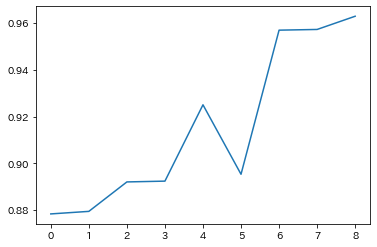

In [302]:
# trainとtestの比率で結構変わる？
# 0.7くらいじゃね？
score_ratio = pd.DataFrame(scores)

plt.plot(score_ratio['test_r2_score'])
plt.show()

In [356]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [357]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 2000,
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0299088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.02533
[3]	valid_0's l2: 0.0215657
[4]	valid_0's l2: 0.0184663
[5]	valid_0's l2: 0.0159227
[6]	valid_0's l2: 0.0137112
[7]	valid_0's l2: 0.0118901
[8]	valid_0's l2: 0.0103856
[9]	valid_0's l2: 0.00916064
[10]	valid_0's l2: 0.00810988
[11]	valid_0's l2: 0.0072205
[12]	valid_0's l2: 0.0064728
[13]	valid_0's l2: 0.00584592
[14]	valid_0's l2: 0.00531761
[15]	valid_0's l2: 0.00488175
[16]	valid_0's l2: 0.0044971
[17]	valid_0's l2: 0.00416546
[18]	valid_0's l2: 0.00387917
[19]	valid_0's l2: 0.00364592
[20]	valid_0's l2: 0.00343598
[21]	valid_0's l2: 0.00325608
[22]	valid_0's l2: 0.00309914
[23]	valid_0's l2: 0.00296344
[24]	valid_0's l2: 0.0028427
[25]	valid_0's l2: 0.00273937
[26]	valid_0's l2: 0.0026456
[27]	valid_0's l2: 0.00256778
[28]	valid_0's l2: 0.0024909
[29]	valid_0's l2: 0.0024257
[30]	valid_0's l2: 0.00236442
[31]	valid_0's l2: 0.00230809
[32]	valid_0's l2: 0.00225998
[33]	

[285]	valid_0's l2: 0.0013153
[286]	valid_0's l2: 0.00131448
[287]	valid_0's l2: 0.00131395
[288]	valid_0's l2: 0.00131364
[289]	valid_0's l2: 0.00131293
[290]	valid_0's l2: 0.00131201
[291]	valid_0's l2: 0.00131157
[292]	valid_0's l2: 0.00131106
[293]	valid_0's l2: 0.00131044
[294]	valid_0's l2: 0.00131016
[295]	valid_0's l2: 0.00130884
[296]	valid_0's l2: 0.00130837
[297]	valid_0's l2: 0.00130811
[298]	valid_0's l2: 0.00130797
[299]	valid_0's l2: 0.00130729
[300]	valid_0's l2: 0.00130655
[301]	valid_0's l2: 0.00130584
[302]	valid_0's l2: 0.00130447
[303]	valid_0's l2: 0.00130374
[304]	valid_0's l2: 0.00130286
[305]	valid_0's l2: 0.00130189
[306]	valid_0's l2: 0.00130116
[307]	valid_0's l2: 0.00130022
[308]	valid_0's l2: 0.00129945
[309]	valid_0's l2: 0.00129909
[310]	valid_0's l2: 0.00129894
[311]	valid_0's l2: 0.00129872
[312]	valid_0's l2: 0.0012982
[313]	valid_0's l2: 0.00129769
[314]	valid_0's l2: 0.00129665
[315]	valid_0's l2: 0.00129634
[316]	valid_0's l2: 0.00129517
[317]	vali

[555]	valid_0's l2: 0.00118971
[556]	valid_0's l2: 0.00118948
[557]	valid_0's l2: 0.00118913
[558]	valid_0's l2: 0.0011886
[559]	valid_0's l2: 0.00118848
[560]	valid_0's l2: 0.00118821
[561]	valid_0's l2: 0.00118803
[562]	valid_0's l2: 0.00118781
[563]	valid_0's l2: 0.00118733
[564]	valid_0's l2: 0.00118729
[565]	valid_0's l2: 0.00118693
[566]	valid_0's l2: 0.00118669
[567]	valid_0's l2: 0.00118651
[568]	valid_0's l2: 0.00118593
[569]	valid_0's l2: 0.00118555
[570]	valid_0's l2: 0.00118531
[571]	valid_0's l2: 0.0011848
[572]	valid_0's l2: 0.00118425
[573]	valid_0's l2: 0.001184
[574]	valid_0's l2: 0.00118368
[575]	valid_0's l2: 0.00118305
[576]	valid_0's l2: 0.00118284
[577]	valid_0's l2: 0.00118264
[578]	valid_0's l2: 0.00118241
[579]	valid_0's l2: 0.00118222
[580]	valid_0's l2: 0.00118186
[581]	valid_0's l2: 0.0011814
[582]	valid_0's l2: 0.00118104
[583]	valid_0's l2: 0.00118088
[584]	valid_0's l2: 0.00118043
[585]	valid_0's l2: 0.00117988
[586]	valid_0's l2: 0.00117963
[587]	valid_0

[835]	valid_0's l2: 0.00111055
[836]	valid_0's l2: 0.00111001
[837]	valid_0's l2: 0.0011098
[838]	valid_0's l2: 0.00110961
[839]	valid_0's l2: 0.00110943
[840]	valid_0's l2: 0.00110891
[841]	valid_0's l2: 0.00110883
[842]	valid_0's l2: 0.00110855
[843]	valid_0's l2: 0.00110833
[844]	valid_0's l2: 0.00110807
[845]	valid_0's l2: 0.00110787
[846]	valid_0's l2: 0.00110759
[847]	valid_0's l2: 0.00110745
[848]	valid_0's l2: 0.00110749
[849]	valid_0's l2: 0.00110725
[850]	valid_0's l2: 0.0011072
[851]	valid_0's l2: 0.00110685
[852]	valid_0's l2: 0.00110655
[853]	valid_0's l2: 0.00110645
[854]	valid_0's l2: 0.0011063
[855]	valid_0's l2: 0.00110606
[856]	valid_0's l2: 0.00110599
[857]	valid_0's l2: 0.00110572
[858]	valid_0's l2: 0.00110551
[859]	valid_0's l2: 0.00110522
[860]	valid_0's l2: 0.00110507
[861]	valid_0's l2: 0.00110488
[862]	valid_0's l2: 0.00110464
[863]	valid_0's l2: 0.00110429
[864]	valid_0's l2: 0.00110414
[865]	valid_0's l2: 0.00110373
[866]	valid_0's l2: 0.0011037
[867]	valid_

[1110]	valid_0's l2: 0.00105639
[1111]	valid_0's l2: 0.00105634
[1112]	valid_0's l2: 0.00105618
[1113]	valid_0's l2: 0.00105604
[1114]	valid_0's l2: 0.00105605
[1115]	valid_0's l2: 0.00105606
[1116]	valid_0's l2: 0.00105593
[1117]	valid_0's l2: 0.00105586
[1118]	valid_0's l2: 0.00105567
[1119]	valid_0's l2: 0.00105542
[1120]	valid_0's l2: 0.00105518
[1121]	valid_0's l2: 0.00105498
[1122]	valid_0's l2: 0.00105484
[1123]	valid_0's l2: 0.00105469
[1124]	valid_0's l2: 0.00105464
[1125]	valid_0's l2: 0.00105447
[1126]	valid_0's l2: 0.00105394
[1127]	valid_0's l2: 0.00105378
[1128]	valid_0's l2: 0.00105375
[1129]	valid_0's l2: 0.00105364
[1130]	valid_0's l2: 0.00105344
[1131]	valid_0's l2: 0.0010532
[1132]	valid_0's l2: 0.00105308
[1133]	valid_0's l2: 0.00105297
[1134]	valid_0's l2: 0.00105285
[1135]	valid_0's l2: 0.00105274
[1136]	valid_0's l2: 0.00105263
[1137]	valid_0's l2: 0.00105243
[1138]	valid_0's l2: 0.00105233
[1139]	valid_0's l2: 0.00105206
[1140]	valid_0's l2: 0.0010519
[1141]	val

[1376]	valid_0's l2: 0.00101841
[1377]	valid_0's l2: 0.00101839
[1378]	valid_0's l2: 0.00101826
[1379]	valid_0's l2: 0.00101782
[1380]	valid_0's l2: 0.00101765
[1381]	valid_0's l2: 0.00101758
[1382]	valid_0's l2: 0.0010175
[1383]	valid_0's l2: 0.00101739
[1384]	valid_0's l2: 0.00101724
[1385]	valid_0's l2: 0.0010172
[1386]	valid_0's l2: 0.00101705
[1387]	valid_0's l2: 0.00101687
[1388]	valid_0's l2: 0.00101683
[1389]	valid_0's l2: 0.00101667
[1390]	valid_0's l2: 0.00101651
[1391]	valid_0's l2: 0.0010164
[1392]	valid_0's l2: 0.00101629
[1393]	valid_0's l2: 0.0010161
[1394]	valid_0's l2: 0.00101602
[1395]	valid_0's l2: 0.00101598
[1396]	valid_0's l2: 0.00101576
[1397]	valid_0's l2: 0.00101554
[1398]	valid_0's l2: 0.00101543
[1399]	valid_0's l2: 0.00101525
[1400]	valid_0's l2: 0.00101513
[1401]	valid_0's l2: 0.001015
[1402]	valid_0's l2: 0.00101492
[1403]	valid_0's l2: 0.0010148
[1404]	valid_0's l2: 0.00101468
[1405]	valid_0's l2: 0.00101464
[1406]	valid_0's l2: 0.00101453
[1407]	valid_0'

[1647]	valid_0's l2: 0.000986194
[1648]	valid_0's l2: 0.000985979
[1649]	valid_0's l2: 0.000985916
[1650]	valid_0's l2: 0.000985872
[1651]	valid_0's l2: 0.00098575
[1652]	valid_0's l2: 0.000985646
[1653]	valid_0's l2: 0.000985523
[1654]	valid_0's l2: 0.000985392
[1655]	valid_0's l2: 0.000985308
[1656]	valid_0's l2: 0.000985214
[1657]	valid_0's l2: 0.00098515
[1658]	valid_0's l2: 0.000985129
[1659]	valid_0's l2: 0.000985066
[1660]	valid_0's l2: 0.000984858
[1661]	valid_0's l2: 0.000984715
[1662]	valid_0's l2: 0.000984623
[1663]	valid_0's l2: 0.000984529
[1664]	valid_0's l2: 0.000984499
[1665]	valid_0's l2: 0.000984401
[1666]	valid_0's l2: 0.000984294
[1667]	valid_0's l2: 0.000983997
[1668]	valid_0's l2: 0.000983861
[1669]	valid_0's l2: 0.000983792
[1670]	valid_0's l2: 0.000983706
[1671]	valid_0's l2: 0.00098358
[1672]	valid_0's l2: 0.000983456
[1673]	valid_0's l2: 0.0009834
[1674]	valid_0's l2: 0.000983336
[1675]	valid_0's l2: 0.000983246
[1676]	valid_0's l2: 0.0009832
[1677]	valid_0's 

[1899]	valid_0's l2: 0.000964339
[1900]	valid_0's l2: 0.000964279
[1901]	valid_0's l2: 0.000964168
[1902]	valid_0's l2: 0.00096408
[1903]	valid_0's l2: 0.00096401
[1904]	valid_0's l2: 0.000963987
[1905]	valid_0's l2: 0.000963915
[1906]	valid_0's l2: 0.000963806
[1907]	valid_0's l2: 0.000963768
[1908]	valid_0's l2: 0.000963698
[1909]	valid_0's l2: 0.000963541
[1910]	valid_0's l2: 0.000963465
[1911]	valid_0's l2: 0.000963414
[1912]	valid_0's l2: 0.000963237
[1913]	valid_0's l2: 0.000963136
[1914]	valid_0's l2: 0.000963055
[1915]	valid_0's l2: 0.000963047
[1916]	valid_0's l2: 0.00096296
[1917]	valid_0's l2: 0.000962927
[1918]	valid_0's l2: 0.00096284
[1919]	valid_0's l2: 0.000962731
[1920]	valid_0's l2: 0.000962537
[1921]	valid_0's l2: 0.000962473
[1922]	valid_0's l2: 0.000962488
[1923]	valid_0's l2: 0.000962345
[1924]	valid_0's l2: 0.000962273
[1925]	valid_0's l2: 0.000962183
[1926]	valid_0's l2: 0.000961991
[1927]	valid_0's l2: 0.000961965
[1928]	valid_0's l2: 0.000961857
[1929]	valid_0

LGBMRegressor(importance_type='gain', n_estimators=2000, random_state=0)

In [358]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [359]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.991044829728913
valid: 0.9685221144241181
test: 0.9569509137464871


In [360]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 0.5424152249145046
valid: 2.0243084713841246
test: 2.8899415405070017


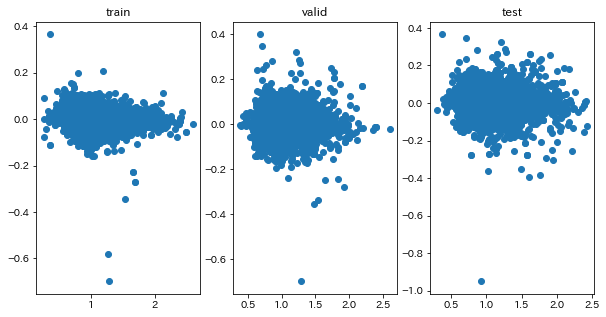

In [361]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, (y_train_pred - y_train))
ax1.title.set_text('train')
ax2.scatter(y_valid_pred, (y_valid_pred - y_valid))
ax2.title.set_text('valid')
ax3.scatter(y_test_pred, (y_test_pred - y_test))
ax3.title.set_text('test')

plt.show()

In [362]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature   importance
0    皇居からの距離   195.442996
1          歩    63.691789
2         バス     1.479021
3          車     0.000000
4   最寄駅からの距離    47.183476
5        部屋数    17.346964
6         面積  7807.014909
7        築年数  1210.751743
8         階数   309.489830
9         地下     5.181299
10        地上    48.491419
11         階    98.835212
12    オプション数    51.410652
13     駐車場距離     9.381816
14     駐車場料金    10.497559
15       条件数    11.502465
16      市区町村  2056.594454
17        路線   111.644249
18         駅  1451.835847
19       間取り  6279.129773
20        向き    19.119737
21      建物種別    23.588436
22        構造   227.531966
23        入居     7.384495
24      取引態様     0.924809
25     間取り_S     0.464090
26     間取り_L     2.061358
27     間取り_D     1.634311
28     間取り_K     2.352045
29     駐車場有無     1.131059

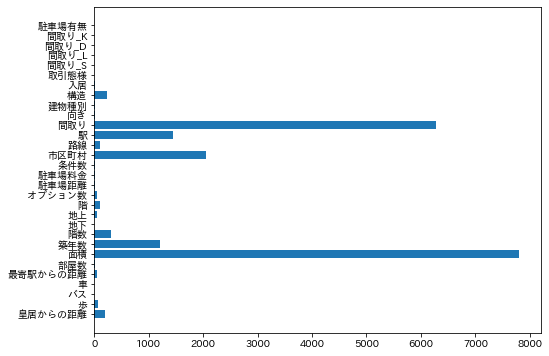

In [363]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.show()

# パラメータ調整

結論：estimatorを増やすと対応できるぽい？

In [242]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '部屋数',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    'オプション数',
    '駐車場距離',
    '駐車場料金',
    '条件数',
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
    '向き',
    '建物種別',
    '構造',
    '入居',
    '取引態様',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '駐車場有無',
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [215]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [327]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [425]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 2000,
#    num_leaves = 1000, なんか知らんけど悪化するゾ
#    learning_rate = 0.1
    random_state = 0,
    importance_type = 'gain',
    
)

# 調整したいパラメータ
def param():
    ret = {
        'max_depth':(5,10,20,40,80),
    }
    return ret

# パラメータ調整
gscv = GridSearchCV(LGBM,param(),cv = 5,verbose=2)
gscv.fit(X_train_before,y_train_before)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........................................max_depth=5; total time=  13.3s


KeyboardInterrupt: 

In [394]:
gscv.cv_results_['mean_test_score']

array([0.97132922, 0.97621447, 0.97778719, 0.97757664, 0.97734975])

{'num_leaves': 1000}
0.9777871905471797


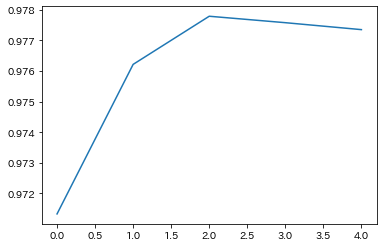

In [395]:
# num_leavesは1000前後っぽい(誤差)
param = 'num_leaves'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

{'learning_rate': 0.1}
0.971479671040235


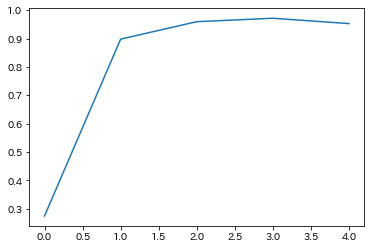

In [392]:
# learning_rateは0.1でOK
param = 'learning_rate'
exec(f"best_{param} = gscv.best_params_")
exec(f"score_{param} = gscv.best_score_")
exec(f"print(best_{param})")
exec(f"print(score_{param})")
plt.plot(gscv.cv_results_['mean_test_score'])
plt.show()

In [489]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '部屋数',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    'オプション数',
    '駐車場距離',
    '駐車場料金',
    '条件数',
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
    '向き',
    '建物種別',
    '構造',
    '入居',
    '取引態様',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '駐車場有無',
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [490]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [491]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [492]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0299088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.02533
[3]	valid_0's l2: 0.0215657
[4]	valid_0's l2: 0.0184663
[5]	valid_0's l2: 0.0159227
[6]	valid_0's l2: 0.0137112
[7]	valid_0's l2: 0.0118901
[8]	valid_0's l2: 0.0103856
[9]	valid_0's l2: 0.00916064
[10]	valid_0's l2: 0.00810988
[11]	valid_0's l2: 0.0072205
[12]	valid_0's l2: 0.0064728
[13]	valid_0's l2: 0.00584592
[14]	valid_0's l2: 0.00531761
[15]	valid_0's l2: 0.00488175
[16]	valid_0's l2: 0.0044971
[17]	valid_0's l2: 0.00416546
[18]	valid_0's l2: 0.00387917
[19]	valid_0's l2: 0.00364592
[20]	valid_0's l2: 0.00343598
[21]	valid_0's l2: 0.00325608
[22]	valid_0's l2: 0.00309914
[23]	valid_0's l2: 0.00296344
[24]	valid_0's l2: 0.0028427
[25]	valid_0's l2: 0.00273937
[26]	valid_0's l2: 0.0026456
[27]	valid_0's l2: 0.00256778
[28]	valid_0's l2: 0.0024909
[29]	valid_0's l2: 0.0024257
[30]	valid_0's l2: 0.00236442
[31]	valid_0's l2: 0.00230809
[32]	valid_0's l2: 0.00225998
[33]	

[294]	valid_0's l2: 0.00131016
[295]	valid_0's l2: 0.00130884
[296]	valid_0's l2: 0.00130837
[297]	valid_0's l2: 0.00130811
[298]	valid_0's l2: 0.00130797
[299]	valid_0's l2: 0.00130729
[300]	valid_0's l2: 0.00130655
[301]	valid_0's l2: 0.00130584
[302]	valid_0's l2: 0.00130447
[303]	valid_0's l2: 0.00130374
[304]	valid_0's l2: 0.00130286
[305]	valid_0's l2: 0.00130189
[306]	valid_0's l2: 0.00130116
[307]	valid_0's l2: 0.00130022
[308]	valid_0's l2: 0.00129945
[309]	valid_0's l2: 0.00129909
[310]	valid_0's l2: 0.00129894
[311]	valid_0's l2: 0.00129872
[312]	valid_0's l2: 0.0012982
[313]	valid_0's l2: 0.00129769
[314]	valid_0's l2: 0.00129665
[315]	valid_0's l2: 0.00129634
[316]	valid_0's l2: 0.00129517
[317]	valid_0's l2: 0.00129416
[318]	valid_0's l2: 0.00129374
[319]	valid_0's l2: 0.00129299
[320]	valid_0's l2: 0.00129251
[321]	valid_0's l2: 0.00129196
[322]	valid_0's l2: 0.0012915
[323]	valid_0's l2: 0.0012908
[324]	valid_0's l2: 0.00129004
[325]	valid_0's l2: 0.00128903
[326]	valid

[569]	valid_0's l2: 0.00118555
[570]	valid_0's l2: 0.00118531
[571]	valid_0's l2: 0.0011848
[572]	valid_0's l2: 0.00118425
[573]	valid_0's l2: 0.001184
[574]	valid_0's l2: 0.00118368
[575]	valid_0's l2: 0.00118305
[576]	valid_0's l2: 0.00118284
[577]	valid_0's l2: 0.00118264
[578]	valid_0's l2: 0.00118241
[579]	valid_0's l2: 0.00118222
[580]	valid_0's l2: 0.00118186
[581]	valid_0's l2: 0.0011814
[582]	valid_0's l2: 0.00118104
[583]	valid_0's l2: 0.00118088
[584]	valid_0's l2: 0.00118043
[585]	valid_0's l2: 0.00117988
[586]	valid_0's l2: 0.00117963
[587]	valid_0's l2: 0.00117935
[588]	valid_0's l2: 0.00117888
[589]	valid_0's l2: 0.00117843
[590]	valid_0's l2: 0.00117828
[591]	valid_0's l2: 0.00117778
[592]	valid_0's l2: 0.00117769
[593]	valid_0's l2: 0.00117715
[594]	valid_0's l2: 0.00117708
[595]	valid_0's l2: 0.00117675
[596]	valid_0's l2: 0.00117644
[597]	valid_0's l2: 0.00117618
[598]	valid_0's l2: 0.0011759
[599]	valid_0's l2: 0.00117582
[600]	valid_0's l2: 0.00117544
[601]	valid_0

[855]	valid_0's l2: 0.00110606
[856]	valid_0's l2: 0.00110599
[857]	valid_0's l2: 0.00110572
[858]	valid_0's l2: 0.00110551
[859]	valid_0's l2: 0.00110522
[860]	valid_0's l2: 0.00110507
[861]	valid_0's l2: 0.00110488
[862]	valid_0's l2: 0.00110464
[863]	valid_0's l2: 0.00110429
[864]	valid_0's l2: 0.00110414
[865]	valid_0's l2: 0.00110373
[866]	valid_0's l2: 0.0011037
[867]	valid_0's l2: 0.00110362
[868]	valid_0's l2: 0.00110341
[869]	valid_0's l2: 0.00110295
[870]	valid_0's l2: 0.00110267
[871]	valid_0's l2: 0.00110232
[872]	valid_0's l2: 0.00110221
[873]	valid_0's l2: 0.00110203
[874]	valid_0's l2: 0.0011017
[875]	valid_0's l2: 0.00110152
[876]	valid_0's l2: 0.0011014
[877]	valid_0's l2: 0.00110114
[878]	valid_0's l2: 0.00110109
[879]	valid_0's l2: 0.00110097
[880]	valid_0's l2: 0.00110072
[881]	valid_0's l2: 0.00110052
[882]	valid_0's l2: 0.00110028
[883]	valid_0's l2: 0.00109999
[884]	valid_0's l2: 0.0010998
[885]	valid_0's l2: 0.00109962
[886]	valid_0's l2: 0.00109919
[887]	valid_

[1127]	valid_0's l2: 0.00105378
[1128]	valid_0's l2: 0.00105375
[1129]	valid_0's l2: 0.00105364
[1130]	valid_0's l2: 0.00105344
[1131]	valid_0's l2: 0.0010532
[1132]	valid_0's l2: 0.00105308
[1133]	valid_0's l2: 0.00105297
[1134]	valid_0's l2: 0.00105285
[1135]	valid_0's l2: 0.00105274
[1136]	valid_0's l2: 0.00105263
[1137]	valid_0's l2: 0.00105243
[1138]	valid_0's l2: 0.00105233
[1139]	valid_0's l2: 0.00105206
[1140]	valid_0's l2: 0.0010519
[1141]	valid_0's l2: 0.00105177
[1142]	valid_0's l2: 0.00105163
[1143]	valid_0's l2: 0.00105153
[1144]	valid_0's l2: 0.00105133
[1145]	valid_0's l2: 0.00105121
[1146]	valid_0's l2: 0.00105114
[1147]	valid_0's l2: 0.00105105
[1148]	valid_0's l2: 0.00105091
[1149]	valid_0's l2: 0.00105071
[1150]	valid_0's l2: 0.00105057
[1151]	valid_0's l2: 0.0010504
[1152]	valid_0's l2: 0.00105033
[1153]	valid_0's l2: 0.00105026
[1154]	valid_0's l2: 0.00105022
[1155]	valid_0's l2: 0.00105012
[1156]	valid_0's l2: 0.00105003
[1157]	valid_0's l2: 0.00104972
[1158]	vali

[1415]	valid_0's l2: 0.0010134
[1416]	valid_0's l2: 0.00101327
[1417]	valid_0's l2: 0.00101308
[1418]	valid_0's l2: 0.00101294
[1419]	valid_0's l2: 0.00101275
[1420]	valid_0's l2: 0.00101272
[1421]	valid_0's l2: 0.00101252
[1422]	valid_0's l2: 0.00101236
[1423]	valid_0's l2: 0.001012
[1424]	valid_0's l2: 0.00101191
[1425]	valid_0's l2: 0.00101175
[1426]	valid_0's l2: 0.00101171
[1427]	valid_0's l2: 0.00101159
[1428]	valid_0's l2: 0.00101148
[1429]	valid_0's l2: 0.00101139
[1430]	valid_0's l2: 0.0010113
[1431]	valid_0's l2: 0.00101126
[1432]	valid_0's l2: 0.00101104
[1433]	valid_0's l2: 0.00101098
[1434]	valid_0's l2: 0.0010107
[1435]	valid_0's l2: 0.00101047
[1436]	valid_0's l2: 0.00101027
[1437]	valid_0's l2: 0.00101013
[1438]	valid_0's l2: 0.00101004
[1439]	valid_0's l2: 0.00100995
[1440]	valid_0's l2: 0.00100986
[1441]	valid_0's l2: 0.00100984
[1442]	valid_0's l2: 0.0010098
[1443]	valid_0's l2: 0.00100971
[1444]	valid_0's l2: 0.00100973
[1445]	valid_0's l2: 0.00100959
[1446]	valid_0

[1696]	valid_0's l2: 0.000981792
[1697]	valid_0's l2: 0.000981655
[1698]	valid_0's l2: 0.000981584
[1699]	valid_0's l2: 0.000981393
[1700]	valid_0's l2: 0.000981228
[1701]	valid_0's l2: 0.000981077
[1702]	valid_0's l2: 0.00098092
[1703]	valid_0's l2: 0.000980942
[1704]	valid_0's l2: 0.000980826
[1705]	valid_0's l2: 0.000980772
[1706]	valid_0's l2: 0.000980618
[1707]	valid_0's l2: 0.000980564
[1708]	valid_0's l2: 0.00098055
[1709]	valid_0's l2: 0.000980561
[1710]	valid_0's l2: 0.000980409
[1711]	valid_0's l2: 0.000980368
[1712]	valid_0's l2: 0.000980238
[1713]	valid_0's l2: 0.000980178
[1714]	valid_0's l2: 0.000980226
[1715]	valid_0's l2: 0.000980082
[1716]	valid_0's l2: 0.000979959
[1717]	valid_0's l2: 0.000979956
[1718]	valid_0's l2: 0.000979916
[1719]	valid_0's l2: 0.000979779
[1720]	valid_0's l2: 0.000979635
[1721]	valid_0's l2: 0.000979592
[1722]	valid_0's l2: 0.000979561
[1723]	valid_0's l2: 0.000979459
[1724]	valid_0's l2: 0.000979248
[1725]	valid_0's l2: 0.000979164
[1726]	valid

[1974]	valid_0's l2: 0.000957499
[1975]	valid_0's l2: 0.000957264
[1976]	valid_0's l2: 0.000957106
[1977]	valid_0's l2: 0.000957021
[1978]	valid_0's l2: 0.000956928
[1979]	valid_0's l2: 0.000956846
[1980]	valid_0's l2: 0.000956792
[1981]	valid_0's l2: 0.000956653
[1982]	valid_0's l2: 0.000956627
[1983]	valid_0's l2: 0.000956537
[1984]	valid_0's l2: 0.000956395
[1985]	valid_0's l2: 0.000956366
[1986]	valid_0's l2: 0.000956306
[1987]	valid_0's l2: 0.000956217
[1988]	valid_0's l2: 0.00095613
[1989]	valid_0's l2: 0.000956107
[1990]	valid_0's l2: 0.000955986
[1991]	valid_0's l2: 0.000955807
[1992]	valid_0's l2: 0.000955691
[1993]	valid_0's l2: 0.000955648
[1994]	valid_0's l2: 0.000955651
[1995]	valid_0's l2: 0.000955608
[1996]	valid_0's l2: 0.000955515
[1997]	valid_0's l2: 0.000955442
[1998]	valid_0's l2: 0.000955292
[1999]	valid_0's l2: 0.000955207
[2000]	valid_0's l2: 0.00095507
[2001]	valid_0's l2: 0.000954906
[2002]	valid_0's l2: 0.000954787
[2003]	valid_0's l2: 0.000954835
[2004]	valid

[2226]	valid_0's l2: 0.000936692
[2227]	valid_0's l2: 0.000936614
[2228]	valid_0's l2: 0.00093652
[2229]	valid_0's l2: 0.000936428
[2230]	valid_0's l2: 0.000936436
[2231]	valid_0's l2: 0.000936277
[2232]	valid_0's l2: 0.000936259
[2233]	valid_0's l2: 0.000936134
[2234]	valid_0's l2: 0.000936049
[2235]	valid_0's l2: 0.00093591
[2236]	valid_0's l2: 0.000935869
[2237]	valid_0's l2: 0.000935835
[2238]	valid_0's l2: 0.000935838
[2239]	valid_0's l2: 0.000935842
[2240]	valid_0's l2: 0.000935799
[2241]	valid_0's l2: 0.000935745
[2242]	valid_0's l2: 0.000935687
[2243]	valid_0's l2: 0.000935619
[2244]	valid_0's l2: 0.000935516
[2245]	valid_0's l2: 0.000935464
[2246]	valid_0's l2: 0.000935441
[2247]	valid_0's l2: 0.000935443
[2248]	valid_0's l2: 0.000935406
[2249]	valid_0's l2: 0.00093527
[2250]	valid_0's l2: 0.000935135
[2251]	valid_0's l2: 0.000935124
[2252]	valid_0's l2: 0.000935109
[2253]	valid_0's l2: 0.000935001
[2254]	valid_0's l2: 0.00093502
[2255]	valid_0's l2: 0.000934992
[2256]	valid_0

[2485]	valid_0's l2: 0.000920093
[2486]	valid_0's l2: 0.000920042
[2487]	valid_0's l2: 0.000919998
[2488]	valid_0's l2: 0.000919904
[2489]	valid_0's l2: 0.000919905
[2490]	valid_0's l2: 0.000919863
[2491]	valid_0's l2: 0.00091986
[2492]	valid_0's l2: 0.000919809
[2493]	valid_0's l2: 0.000919709
[2494]	valid_0's l2: 0.000919655
[2495]	valid_0's l2: 0.000919583
[2496]	valid_0's l2: 0.00091954
[2497]	valid_0's l2: 0.00091951
[2498]	valid_0's l2: 0.000919484
[2499]	valid_0's l2: 0.000919362
[2500]	valid_0's l2: 0.000919308
[2501]	valid_0's l2: 0.000919254
[2502]	valid_0's l2: 0.000919193
[2503]	valid_0's l2: 0.000919189
[2504]	valid_0's l2: 0.000919131
[2505]	valid_0's l2: 0.000919074
[2506]	valid_0's l2: 0.000918999
[2507]	valid_0's l2: 0.000918919
[2508]	valid_0's l2: 0.000918783
[2509]	valid_0's l2: 0.000918874
[2510]	valid_0's l2: 0.000918784
[2511]	valid_0's l2: 0.000918698
[2512]	valid_0's l2: 0.000918595
[2513]	valid_0's l2: 0.000918508
[2514]	valid_0's l2: 0.000918412
[2515]	valid_

[2743]	valid_0's l2: 0.000903805
[2744]	valid_0's l2: 0.000903796
[2745]	valid_0's l2: 0.000903761
[2746]	valid_0's l2: 0.000903815
[2747]	valid_0's l2: 0.000903727
[2748]	valid_0's l2: 0.000903653
[2749]	valid_0's l2: 0.000903593
[2750]	valid_0's l2: 0.000903528
[2751]	valid_0's l2: 0.000903456
[2752]	valid_0's l2: 0.000903418
[2753]	valid_0's l2: 0.000903385
[2754]	valid_0's l2: 0.000903351
[2755]	valid_0's l2: 0.000903254
[2756]	valid_0's l2: 0.0009032
[2757]	valid_0's l2: 0.000903063
[2758]	valid_0's l2: 0.000902974
[2759]	valid_0's l2: 0.000902921
[2760]	valid_0's l2: 0.000902901
[2761]	valid_0's l2: 0.000902811
[2762]	valid_0's l2: 0.000902778
[2763]	valid_0's l2: 0.000902753
[2764]	valid_0's l2: 0.000902728
[2765]	valid_0's l2: 0.000902723
[2766]	valid_0's l2: 0.000902737
[2767]	valid_0's l2: 0.000902676
[2768]	valid_0's l2: 0.00090261
[2769]	valid_0's l2: 0.000902539
[2770]	valid_0's l2: 0.000902523
[2771]	valid_0's l2: 0.000902505
[2772]	valid_0's l2: 0.000902446
[2773]	valid_

[3009]	valid_0's l2: 0.00088981
[3010]	valid_0's l2: 0.000889753
[3011]	valid_0's l2: 0.000889693
[3012]	valid_0's l2: 0.000889635
[3013]	valid_0's l2: 0.000889645
[3014]	valid_0's l2: 0.000889628
[3015]	valid_0's l2: 0.00088957
[3016]	valid_0's l2: 0.000889536
[3017]	valid_0's l2: 0.000889456
[3018]	valid_0's l2: 0.000889413
[3019]	valid_0's l2: 0.000889393
[3020]	valid_0's l2: 0.000889402
[3021]	valid_0's l2: 0.000889371
[3022]	valid_0's l2: 0.000889324
[3023]	valid_0's l2: 0.000889327
[3024]	valid_0's l2: 0.000889275
[3025]	valid_0's l2: 0.000889232
[3026]	valid_0's l2: 0.000889186
[3027]	valid_0's l2: 0.000889086
[3028]	valid_0's l2: 0.000889039
[3029]	valid_0's l2: 0.000888939
[3030]	valid_0's l2: 0.000888902
[3031]	valid_0's l2: 0.000888872
[3032]	valid_0's l2: 0.000888795
[3033]	valid_0's l2: 0.000888788
[3034]	valid_0's l2: 0.000888763
[3035]	valid_0's l2: 0.000888725
[3036]	valid_0's l2: 0.000888487
[3037]	valid_0's l2: 0.000888457
[3038]	valid_0's l2: 0.00088842
[3039]	valid_

[3268]	valid_0's l2: 0.00087795
[3269]	valid_0's l2: 0.000877802
[3270]	valid_0's l2: 0.000877814
[3271]	valid_0's l2: 0.000877748
[3272]	valid_0's l2: 0.00087772
[3273]	valid_0's l2: 0.00087769
[3274]	valid_0's l2: 0.000877551
[3275]	valid_0's l2: 0.000877485
[3276]	valid_0's l2: 0.000877449
[3277]	valid_0's l2: 0.000877399
[3278]	valid_0's l2: 0.000877358
[3279]	valid_0's l2: 0.00087731
[3280]	valid_0's l2: 0.000877286
[3281]	valid_0's l2: 0.000877153
[3282]	valid_0's l2: 0.000877088
[3283]	valid_0's l2: 0.000877055
[3284]	valid_0's l2: 0.000877
[3285]	valid_0's l2: 0.000876968
[3286]	valid_0's l2: 0.000876893
[3287]	valid_0's l2: 0.000876819
[3288]	valid_0's l2: 0.000876764
[3289]	valid_0's l2: 0.000876782
[3290]	valid_0's l2: 0.000876739
[3291]	valid_0's l2: 0.000876684
[3292]	valid_0's l2: 0.00087662
[3293]	valid_0's l2: 0.000876599
[3294]	valid_0's l2: 0.000876551
[3295]	valid_0's l2: 0.000876515
[3296]	valid_0's l2: 0.000876476
[3297]	valid_0's l2: 0.000876402
[3298]	valid_0's l

[3524]	valid_0's l2: 0.00086775
[3525]	valid_0's l2: 0.000867743
[3526]	valid_0's l2: 0.000867699
[3527]	valid_0's l2: 0.000867637
[3528]	valid_0's l2: 0.00086762
[3529]	valid_0's l2: 0.000867632
[3530]	valid_0's l2: 0.000867618
[3531]	valid_0's l2: 0.000867548
[3532]	valid_0's l2: 0.000867469
[3533]	valid_0's l2: 0.00086746
[3534]	valid_0's l2: 0.000867525
[3535]	valid_0's l2: 0.000867498
[3536]	valid_0's l2: 0.000867473
[3537]	valid_0's l2: 0.000867528
[3538]	valid_0's l2: 0.000867502
[3539]	valid_0's l2: 0.00086743
[3540]	valid_0's l2: 0.000867389
[3541]	valid_0's l2: 0.000867338
[3542]	valid_0's l2: 0.000867332
[3543]	valid_0's l2: 0.000867402
[3544]	valid_0's l2: 0.000867361
[3545]	valid_0's l2: 0.000867353
[3546]	valid_0's l2: 0.000867322
[3547]	valid_0's l2: 0.000867243
[3548]	valid_0's l2: 0.000867213
[3549]	valid_0's l2: 0.000867189
[3550]	valid_0's l2: 0.00086714
[3551]	valid_0's l2: 0.000867106
[3552]	valid_0's l2: 0.00086699
[3553]	valid_0's l2: 0.000866965
[3554]	valid_0's

[3780]	valid_0's l2: 0.000857756
[3781]	valid_0's l2: 0.000857728
[3782]	valid_0's l2: 0.000857691
[3783]	valid_0's l2: 0.000857537
[3784]	valid_0's l2: 0.000857538
[3785]	valid_0's l2: 0.000857567
[3786]	valid_0's l2: 0.000857519
[3787]	valid_0's l2: 0.000857476
[3788]	valid_0's l2: 0.000857444
[3789]	valid_0's l2: 0.000857429
[3790]	valid_0's l2: 0.000857376
[3791]	valid_0's l2: 0.000857373
[3792]	valid_0's l2: 0.000857317
[3793]	valid_0's l2: 0.000857292
[3794]	valid_0's l2: 0.00085725
[3795]	valid_0's l2: 0.000857245
[3796]	valid_0's l2: 0.000857222
[3797]	valid_0's l2: 0.000857209
[3798]	valid_0's l2: 0.000857199
[3799]	valid_0's l2: 0.000857187
[3800]	valid_0's l2: 0.000857159
[3801]	valid_0's l2: 0.000857124
[3802]	valid_0's l2: 0.000857106
[3803]	valid_0's l2: 0.00085704
[3804]	valid_0's l2: 0.00085688
[3805]	valid_0's l2: 0.000856873
[3806]	valid_0's l2: 0.000856799
[3807]	valid_0's l2: 0.000856749
[3808]	valid_0's l2: 0.000856758
[3809]	valid_0's l2: 0.000856728
[3810]	valid_

[4038]	valid_0's l2: 0.000849004
[4039]	valid_0's l2: 0.00084895
[4040]	valid_0's l2: 0.000848903
[4041]	valid_0's l2: 0.000848852
[4042]	valid_0's l2: 0.000848774
[4043]	valid_0's l2: 0.000848752
[4044]	valid_0's l2: 0.000848704
[4045]	valid_0's l2: 0.000848681
[4046]	valid_0's l2: 0.000848677
[4047]	valid_0's l2: 0.000848656
[4048]	valid_0's l2: 0.000848649
[4049]	valid_0's l2: 0.0008486
[4050]	valid_0's l2: 0.000848555
[4051]	valid_0's l2: 0.000848539
[4052]	valid_0's l2: 0.000848514
[4053]	valid_0's l2: 0.000848489
[4054]	valid_0's l2: 0.00084846
[4055]	valid_0's l2: 0.00084844
[4056]	valid_0's l2: 0.000848388
[4057]	valid_0's l2: 0.000848343
[4058]	valid_0's l2: 0.00084835
[4059]	valid_0's l2: 0.000848278
[4060]	valid_0's l2: 0.000848197
[4061]	valid_0's l2: 0.000848176
[4062]	valid_0's l2: 0.000848145
[4063]	valid_0's l2: 0.000848132
[4064]	valid_0's l2: 0.000848104
[4065]	valid_0's l2: 0.000848068
[4066]	valid_0's l2: 0.000848066
[4067]	valid_0's l2: 0.000848044
[4068]	valid_0's

[4309]	valid_0's l2: 0.000840671
[4310]	valid_0's l2: 0.000840609
[4311]	valid_0's l2: 0.000840575
[4312]	valid_0's l2: 0.000840545
[4313]	valid_0's l2: 0.00084052
[4314]	valid_0's l2: 0.000840467
[4315]	valid_0's l2: 0.000840454
[4316]	valid_0's l2: 0.000840376
[4317]	valid_0's l2: 0.000840372
[4318]	valid_0's l2: 0.000840261
[4319]	valid_0's l2: 0.000840265
[4320]	valid_0's l2: 0.000840234
[4321]	valid_0's l2: 0.000840092
[4322]	valid_0's l2: 0.000840101
[4323]	valid_0's l2: 0.000840089
[4324]	valid_0's l2: 0.000840059
[4325]	valid_0's l2: 0.000840036
[4326]	valid_0's l2: 0.000840014
[4327]	valid_0's l2: 0.000840019
[4328]	valid_0's l2: 0.000839987
[4329]	valid_0's l2: 0.00083994
[4330]	valid_0's l2: 0.000839912
[4331]	valid_0's l2: 0.000839905
[4332]	valid_0's l2: 0.000839877
[4333]	valid_0's l2: 0.000839833
[4334]	valid_0's l2: 0.00083981
[4335]	valid_0's l2: 0.000839755
[4336]	valid_0's l2: 0.000839683
[4337]	valid_0's l2: 0.000839681
[4338]	valid_0's l2: 0.000839664
[4339]	valid_

[4585]	valid_0's l2: 0.000832687
[4586]	valid_0's l2: 0.000832644
[4587]	valid_0's l2: 0.000832602
[4588]	valid_0's l2: 0.000832553
[4589]	valid_0's l2: 0.000832524
[4590]	valid_0's l2: 0.000832537
[4591]	valid_0's l2: 0.000832553
[4592]	valid_0's l2: 0.000832493
[4593]	valid_0's l2: 0.000832504
[4594]	valid_0's l2: 0.000832471
[4595]	valid_0's l2: 0.000832444
[4596]	valid_0's l2: 0.000832418
[4597]	valid_0's l2: 0.000832398
[4598]	valid_0's l2: 0.000832379
[4599]	valid_0's l2: 0.000832382
[4600]	valid_0's l2: 0.000832382
[4601]	valid_0's l2: 0.000832375
[4602]	valid_0's l2: 0.000832328
[4603]	valid_0's l2: 0.000832293
[4604]	valid_0's l2: 0.000832278
[4605]	valid_0's l2: 0.000832277
[4606]	valid_0's l2: 0.000832241
[4607]	valid_0's l2: 0.000832211
[4608]	valid_0's l2: 0.000832144
[4609]	valid_0's l2: 0.000832103
[4610]	valid_0's l2: 0.000832086
[4611]	valid_0's l2: 0.000832052
[4612]	valid_0's l2: 0.000832017
[4613]	valid_0's l2: 0.000831989
[4614]	valid_0's l2: 0.000831974
[4615]	val

LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

In [493]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [494]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9970308980860082
valid: 0.9722183357913752
test: 0.9599917450334181


In [495]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 0.1798386891281801
valid: 1.7866085087289942
test: 2.6858065537148423


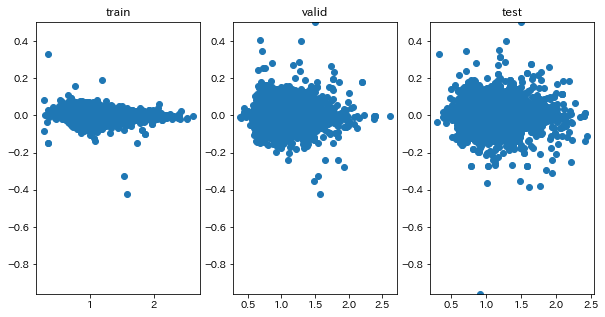

In [496]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [497]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature   importance
0    皇居からの距離   203.307859
1          歩    71.244992
2         バス     1.480493
3          車     0.000000
4   最寄駅からの距離    59.214511
5        部屋数    17.834152
6         面積  7826.634001
7        築年数  1224.804852
8         階数   314.088178
9         地下     5.488281
10        地上    50.440546
11         階   104.345101
12    オプション数    65.378577
13     駐車場距離    11.069518
14     駐車場料金    13.151159
15       条件数    15.517833
16      市区町村  2058.885621
17        路線   114.778663
18         駅  1464.339368
19       間取り  6281.453949
20        向き    23.843176
21      建物種別    23.708872
22        構造   228.572503
23        入居     9.975369
24      取引態様     1.091435
25     間取り_S     0.486811
26     間取り_L     2.509763
27     間取り_D     2.088503
28     間取り_K     2.985215
29     駐車場有無     1.466696

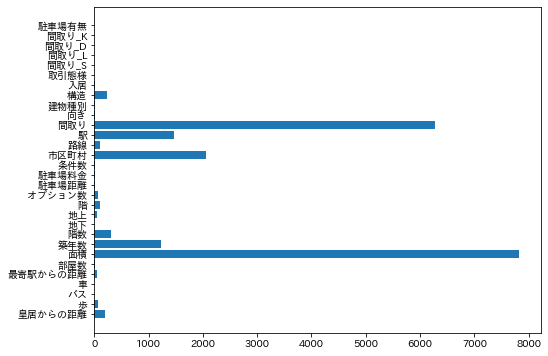

In [513]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig("./data/image/details_feature_importances.png")
plt.show()

# 残差の大きい皆さん

結論：

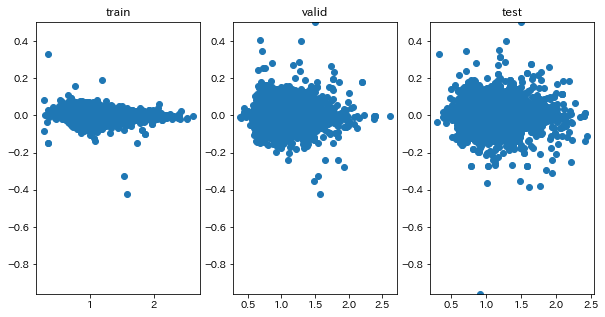

In [500]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train_log10 = y_train_pred - y_train
error_valid_log10 = y_valid_pred - y_valid
error_test_log10 = y_test_pred - y_test

max_ = error_test_log10.max()
min_ = error_test_log10.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train_log10)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid_log10)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test_log10)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

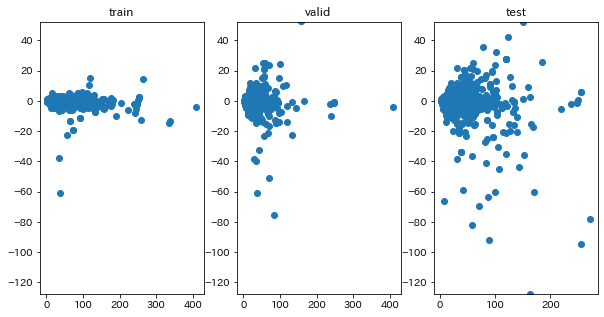

In [501]:
# それぞれの残差プロット
# 対数変換をもとに戻す
fig = plt.figure(figsize=(10,5))

error_train = 10**y_train_pred - 10**y_train
error_valid = 10**y_valid_pred - 10**y_valid
error_test = 10**y_test_pred - 10**y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(10**y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(10**y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(10**y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

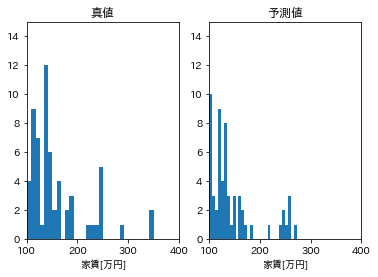

In [515]:
# 高額の予測はそれなりに出来ているように見える
max_ = 400
min_ = 100

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].hist(10**y_test[10**y_test > 100], bins=30)
axes[0].set_xlim(min_,max_)
axes[0].set_ylim(0,15)
axes[0].set_title('真値')
axes[0].set_xlabel('家賃[万円]')
axes[1].hist(10**y_test_pred[10**y_test_pred > 100], bins=30)
axes[1].set_xlim(min_,max_)
axes[1].set_ylim(0,15)
axes[1].set_title('予測値')
axes[1].set_xlabel('家賃[万円]')

plt.savefig("./data/image/be_able_to_predict_high_rent.png")
plt.show()

In [502]:
# テストデータの残差
residual_error = 10**y_test_pred - 10**y_test
X_test['賃料'] = 10**y_test
X_test['予測'] = 10**y_test_pred
X_test['残差'] = residual_error

In [1]:
# 予測がずれまくった皆さんとは？
# condition = X_test['残差'] > 30
# X_test[condition].sort_values('残差')
X_test.sort_values('残差',ascending = False)[-50:]

NameError: name 'X_test' is not defined

In [510]:
print(suumo.loc[14800,'url'])

https://suumo.jp/chintai/jnc_000076348360/?bc=100284129243


# 変数選別

結論：12種類（10種類？）あれば十分らしい。

In [427]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
    '歩',
    'バス',
    '車',
    '最寄駅からの距離',
    '部屋数',
    '面積',
    '築年数',
    '階数',
    '地下',
    '地上',
    '階',
    'オプション数',
    '駐車場距離',
    '駐車場料金',
    '条件数',
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
    '向き',
    '建物種別',
    '構造',
    '入居',
    '取引態様',
]
is_features = [
    '間取り_S',
    '間取り_L',
    '間取り_D',
    '間取り_K',
    '駐車場有無',
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [428]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [431]:
# スコア遷移をつかさどる器
score_transition = []


num = len(features)
# featuresを1つずつ減らしながら検証するゾ
for j in range(num):
    
    # スコアを貯める器
    table_score = []

    # 変数を1つ削除してスコアを検証するぞ
    for i in range(len(features)):
        features_list = features.tolist()
        drop = features_list.pop(i)

        # スコアの器
        score = []
        score.append(drop)

        # Xとyを定義
        X = suumo_light[features_list]
        y = suumo_light[target_feature]

        # 学習用とテスト用に分割
        train_test = 0.7
        train_valid = 0.8
        X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

        # モデルを構築、学習
        LGBM = lgb.LGBMRegressor(
            n_estimators = 1000,
            learning_rate = 0.1,
            random_state = 0,
            importance_type = 'gain'
        )

        verbose_eval = 0
        LGBM.fit(X_train,y_train,
                eval_set=[(X_valid,y_valid)],
                eval_metric = 'mse',
                callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                            lgb.log_evaluation(verbose_eval)])

        # それぞれの予測結果を収納
        y_test_pred = LGBM.predict(X_test)

        # それぞれのr2スコアを算出
        # 対数から元に戻そう
        score.append(r2_score(10**y_test,10**y_test_pred))

        # それぞれのMSEを算出
        # 対数から元に戻そう
        # score.append(mean_squared_error(10**y_test,10**y_test_pred))

        # スコアを器に入れる
        table_score.append(score)

    # 変数を1つ減らしたスコアのテーブルを作成
    scores = pd.DataFrame(table_score,columns=['feature',"r2_test"])

    # スコアが高い変数とスコアを保存
    id_ = scores['r2_test'].idxmax()
    max_feature = scores.loc[id_,'feature']
    max_ = scores['r2_test'].max()
    score_transition.append([max_feature,max_])

    # スコアが高い変数を削除
    features = np.delete(features,id_)
    print(features)

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109622


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110669


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00107243


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00107609


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109217


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108927


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00245749


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00175766


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109023


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0010814


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108047


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114167


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109916


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108195


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00107763


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108613


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109852


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00107434


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00117238


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108618


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108477


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108487


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110221


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.001094


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108332


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00107981


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0010787


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108516


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00108203


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00107824
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '部屋数' '面積' '築年数' '階数' '地下' '地上' '階'
 '駐車場距離' '駐車場料金' '条件数' '市区町村' '路線' '駅' '間取り' '向き' '建物種別' '構造' '入居' '取引態様'
 '間取り_S' '間取り_L' '間取り_D' '間取り_K' '駐車場有無']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111344


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111981


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110546


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109916


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111481


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110336


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00250744


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00190338


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111042


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109834


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110139


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114981


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109464


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110449


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110237


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111335


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109305


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119676


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109412


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110458


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110062


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112772


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110028


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109968


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109931


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109543


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109572


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110236


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110236
['皇居からの距離' '歩' 'バス' '車' '最寄駅からの距離' '部屋数' '面積' '築年数' '階数' '地下' '地上' '階'
 '駐車場距離' '駐車場料金' '条件数' '市区町村' '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様'
 '間取り_S' '間取り_L' '間取り_D' '間取り_K' '駐車場有無']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110731


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011322


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110277


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110458


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112541


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109885


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00254672


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00192496


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111424


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110071


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110126


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114944


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109874


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110804


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111128


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111392


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109986


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119479


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110331


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110181


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112226


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110645


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110525


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109653


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110136


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110035


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110349


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110097
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '部屋数' '面積' '築年数' '階数' '地下' '地上' '階' '駐車場距離'
 '駐車場料金' '条件数' '市区町村' '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様' '間取り_S'
 '間取り_L' '間取り_D' '間取り_K' '駐車場有無']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110731


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011322


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110277


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112541


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109885


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00254672


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00192496


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111424


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110071


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110126


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114944


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109874


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110804


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111128


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111392


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109986


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119479


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110331


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110181


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112226


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110645


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110525


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109653


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110136


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110035


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110349


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110097
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '部屋数' '面積' '築年数' '階数' '地下' '地上' '階' '駐車場距離'
 '駐車場料金' '条件数' '市区町村' '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様' '間取り_S'
 '間取り_L' '間取り_D' '駐車場有無']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111585


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112352


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110161


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112364


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110209


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00254698


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00192317


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111706


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110317


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110021


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114915


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109974


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110305


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111302


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011195


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109207


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011897


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110826


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109557


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112739


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110437


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011008


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109828


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00110153


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110045


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110468
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '階数' '地下' '地上' '階' '駐車場距離'
 '駐車場料金' '条件数' '市区町村' '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様' '間取り_S'
 '間取り_L' '間取り_D' '駐車場有無']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111183


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113471


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110464


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111915


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00255428


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00191894


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111025


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110124


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110623


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115056


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110178


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110179


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110563


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011259


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110109


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0012048


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111095


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110822


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112964


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110169


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110092


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110316


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00110377


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109706


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00110496
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '駐車場料金'
 '条件数' '市区町村' '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様' '間取り_S' '間取り_L'
 '間取り_D' '駐車場有無']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111062


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113868


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00109959


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112783


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00254285


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00193488


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110344


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112853


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114425


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110419


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110421


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111323


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111654


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111381


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011981


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.001117


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011121


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112958


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110473


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110654


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111176


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011081


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111465


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110572
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '条件数'
 '市区町村' '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様' '間取り_S' '間取り_L' '間取り_D'
 '駐車場有無']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111601


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113714


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110454


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112141


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00254631


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00193416


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110016


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113442


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115208


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110676


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110702


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111779


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111588


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119166


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112103


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111262


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113043


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111747


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110182


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110835


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110171


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110631


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110649
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '条件数'
 '市区町村' '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様' '間取り_S' '間取り_D' '駐車場有無']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110839


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113853


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111185


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112373


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0025419


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00193935


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110872


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113056


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011486


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110814


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110937


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111752


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111113


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011873


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113999


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111094


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112949


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111011


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110562


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110752


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110907


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110266
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '条件数'
 '市区町村' '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011193


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113638


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110456


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111964


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00257466


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00193138


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110996


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112993


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00116032


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111393


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111269


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111218


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111524


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00118999


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011441


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111303


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113373


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111192


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110465


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111043


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110995
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '市区町村'
 '路線' '駅' '間取り' '建物種別' '構造' '入居' '取引態様' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111614


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114574


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111785


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112396


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00259098


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00195008


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111503


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114182


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011614


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112694


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112846


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111958


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119599


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115139


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111861


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112925


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111622


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111025


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111525


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110837
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '市区町村'
 '路線' '駅' '間取り' '構造' '入居' '取引態様' '間取り_S' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112612


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114898


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112038


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113654


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00261816


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00194643


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111947


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115351


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00116332


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112933


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112105


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111308


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119557


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011485


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114888


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112053


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111764


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111986


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111966
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '市区町村'
 '路線' '駅' '間取り' '構造' '入居' '取引態様' '間取り_D']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112232


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114393


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011145


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113303


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00264044


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00194303


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111312


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114438


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00117033


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.001118


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113112


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111545


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00118272


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115199


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113866


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112299


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00112569


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112611
['皇居からの距離' '歩' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '市区町村'
 '路線' '駅' '間取り' '構造' '入居' '取引態様']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113084


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114761


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111318


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113034


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0026038


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00194575


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111572


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114198


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00116247


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112154


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112283


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00110544


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119989


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00117568


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114457


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00112313


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00111933
['皇居からの距離' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '駐車場距離' '市区町村' '路線'
 '駅' '間取り' '構造' '入居' '取引態様']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115602


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114566


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119131


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00265486


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00199201


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114659


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00117702


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119648


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114594


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114937


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00113686


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00122079


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119958


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00117037


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011478


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114527
['皇居からの距離' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '市区町村' '路線' '駅' '間取り'
 '構造' '入居' '取引態様']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00116491


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114905


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119922


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00267423


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00199301


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00115383


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00118368


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[900]	valid_0's l2: 0.00121604


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115584


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114814


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0012221


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00121277


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00117996


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114293


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115394
['皇居からの距離' 'バス' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '市区町村' '路線' '駅' '間取り'
 '構造' '取引態様']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00116686


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114868


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00120059


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00266721


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00199521


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115793


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00118138


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0012056


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00117026


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115561


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00121936


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00121724


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00118221


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00115022
['皇居からの距離' '最寄駅からの距離' '面積' '築年数' '地下' '地上' '階' '市区町村' '路線' '駅' '間取り' '構造'
 '取引態様']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011685


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119861


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00267835


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00200963


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114958


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 0.00118141


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00120151


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00116192


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00114737


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00122537


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00122019


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00118385


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.0011469
['皇居からの距離' '最寄駅からの距離' '面積' '築年数' '地上' '階' '市区町村' '路線' '駅' '間取り' '構造'
 '取引態様']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00116462


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119982


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00267743


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00202361


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00118836


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[984]	valid_0's l2: 0.00120596


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[836]	valid_0's l2: 0.00120161


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0011501


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00121908


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0012123


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00118505


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00114029
['皇居からの距離' '面積' '築年数' '地上' '階' '市区町村' '路線' '駅' '間取り' '構造' '取引態様']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00123424


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0027934


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00210913


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00123791


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.00124685


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00121877


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00119252


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00127741


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00125963


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00122436


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00120095
['皇居からの距離' '面積' '築年数' '地上' '階' '市区町村' '路線' '駅' '間取り' '構造']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00123888


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00280032


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00210429


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00124035


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00124283


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00120553


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 0.00118794


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00126937


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.001266


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00121422
['皇居からの距離' '面積' '築年数' '地上' '階' '市区町村' '路線' '駅' '間取り']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00126822


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0029047


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00224446


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00131759


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0012703


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00125109


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00122991


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0012978


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00129205
['皇居からの距離' '面積' '築年数' '地上' '市区町村' '路線' '駅' '間取り']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00130949


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00299873


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00229659


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0014788


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00129828


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00127014


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00133933


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00135466
['皇居からの距離' '面積' '築年数' '地上' '市区町村' '駅' '間取り']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00131773


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00299222


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00229472


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 0.00148989


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00130584


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00143854


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00134491
['面積' '築年数' '地上' '市区町村' '駅' '間取り']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00309198


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00239741


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00157546


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00140496


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00185781


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00139351
['面積' '築年数' '市区町村' '駅' '間取り']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00388412


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00293081


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00169014


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00237299


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0016785
['面積' '築年数' '駅' '間取り']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00413096


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00308277


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00628259


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.00180363
['面積' '築年数' '駅']


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0177463


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.0036383
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[981]	valid_0's l2: 0.00701848
['面積' '駅']
Training until validation scores don't improve for 10 rounds


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Early stopping, best iteration is:
[42]	valid_0's l2: 0.0257742
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's l2: 0.0110384
['面積']
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 0.99076
[]


In [432]:
table_drop_feature = pd.DataFrame(score_transition,columns=['features','score'])
table_drop_feature

features     score
0     オプション数  0.954961
1         向き  0.957603
2          車  0.957603
3      間取り_K  0.956748
4        部屋数  0.956387
5         階数  0.957000
6      駐車場料金  0.956931
7      間取り_L  0.957882
8      駐車場有無  0.957441
9        条件数  0.956942
10      建物種別  0.957303
11     間取り_S  0.957739
12     間取り_D  0.957257
13         歩  0.956781
14     駐車場距離  0.957446
15        入居  0.956936
16        バス  0.955628
17        地下  0.956143
18  最寄駅からの距離  0.955969
19      取引態様  0.954830
20        構造  0.955397
21         階  0.952499
22        路線  0.951593
23   皇居からの距離  0.949035
24        地上  0.942850
25      市区町村  0.931601
26       間取り  0.918193
27       築年数  0.818495
28         駅  0.553545
29        面積 -0.022887

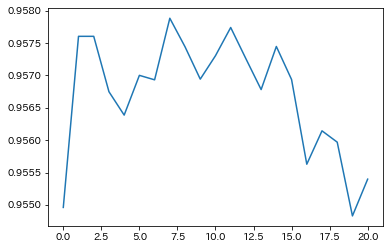

In [436]:
# 上がった後下がり続けるってわけでもない
plt.plot(table_drop_feature.loc[:20,'score'])
plt.show()

In [31]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
#    '向き', # 1
#    '建物種別', # 10
    '構造',
#    '入居', # 15
    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]

# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [32]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [33]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [34]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0299088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0253301
[3]	valid_0's l2: 0.0215658
[4]	valid_0's l2: 0.0184664
[5]	valid_0's l2: 0.0159211
[6]	valid_0's l2: 0.0137106
[7]	valid_0's l2: 0.0118926
[8]	valid_0's l2: 0.0103827
[9]	valid_0's l2: 0.00913653
[10]	valid_0's l2: 0.00812594
[11]	valid_0's l2: 0.00722829
[12]	valid_0's l2: 0.00647552
[13]	valid_0's l2: 0.00584686
[14]	valid_0's l2: 0.00532667
[15]	valid_0's l2: 0.00488295
[16]	valid_0's l2: 0.00450454
[17]	valid_0's l2: 0.00418269
[18]	valid_0's l2: 0.00389921
[19]	valid_0's l2: 0.00365261
[20]	valid_0's l2: 0.00345433
[21]	valid_0's l2: 0.00327508
[22]	valid_0's l2: 0.00311241
[23]	valid_0's l2: 0.00297198
[24]	valid_0's l2: 0.00285638
[25]	valid_0's l2: 0.00274989
[26]	valid_0's l2: 0.00265678
[27]	valid_0's l2: 0.0025735
[28]	valid_0's l2: 0.00249914
[29]	valid_0's l2: 0.00243406
[30]	valid_0's l2: 0.00237437
[31]	valid_0's l2: 0.00232398
[32]	valid_0's l2: 0.002276

[290]	valid_0's l2: 0.00139043
[291]	valid_0's l2: 0.00138974
[292]	valid_0's l2: 0.00138838
[293]	valid_0's l2: 0.00138774
[294]	valid_0's l2: 0.00138643
[295]	valid_0's l2: 0.00138574
[296]	valid_0's l2: 0.00138515
[297]	valid_0's l2: 0.00138377
[298]	valid_0's l2: 0.00138303
[299]	valid_0's l2: 0.00138288
[300]	valid_0's l2: 0.00138163
[301]	valid_0's l2: 0.00138131
[302]	valid_0's l2: 0.00138062
[303]	valid_0's l2: 0.00138003
[304]	valid_0's l2: 0.00137969
[305]	valid_0's l2: 0.00137955
[306]	valid_0's l2: 0.00137771
[307]	valid_0's l2: 0.00137689
[308]	valid_0's l2: 0.00137632
[309]	valid_0's l2: 0.00137548
[310]	valid_0's l2: 0.0013751
[311]	valid_0's l2: 0.00137487
[312]	valid_0's l2: 0.00137399
[313]	valid_0's l2: 0.00137352
[314]	valid_0's l2: 0.00137278
[315]	valid_0's l2: 0.00137196
[316]	valid_0's l2: 0.00137069
[317]	valid_0's l2: 0.00136976
[318]	valid_0's l2: 0.00136867
[319]	valid_0's l2: 0.001368
[320]	valid_0's l2: 0.00136742
[321]	valid_0's l2: 0.00136695
[322]	valid

[579]	valid_0's l2: 0.00125332
[580]	valid_0's l2: 0.00125276
[581]	valid_0's l2: 0.0012523
[582]	valid_0's l2: 0.00125207
[583]	valid_0's l2: 0.00125189
[584]	valid_0's l2: 0.00125197
[585]	valid_0's l2: 0.00125165
[586]	valid_0's l2: 0.00125169
[587]	valid_0's l2: 0.00125103
[588]	valid_0's l2: 0.00125039
[589]	valid_0's l2: 0.00124964
[590]	valid_0's l2: 0.00124891
[591]	valid_0's l2: 0.00124876
[592]	valid_0's l2: 0.00124844
[593]	valid_0's l2: 0.00124806
[594]	valid_0's l2: 0.00124767
[595]	valid_0's l2: 0.00124728
[596]	valid_0's l2: 0.00124687
[597]	valid_0's l2: 0.00124653
[598]	valid_0's l2: 0.00124614
[599]	valid_0's l2: 0.00124577
[600]	valid_0's l2: 0.00124541
[601]	valid_0's l2: 0.00124522
[602]	valid_0's l2: 0.00124503
[603]	valid_0's l2: 0.00124509
[604]	valid_0's l2: 0.00124502
[605]	valid_0's l2: 0.00124474
[606]	valid_0's l2: 0.00124426
[607]	valid_0's l2: 0.001244
[608]	valid_0's l2: 0.00124374
[609]	valid_0's l2: 0.00124344
[610]	valid_0's l2: 0.00124323
[611]	valid

[853]	valid_0's l2: 0.00118103
[854]	valid_0's l2: 0.00118072
[855]	valid_0's l2: 0.00118061
[856]	valid_0's l2: 0.00118034
[857]	valid_0's l2: 0.00118012
[858]	valid_0's l2: 0.0011799
[859]	valid_0's l2: 0.00117959
[860]	valid_0's l2: 0.00117949
[861]	valid_0's l2: 0.00117934
[862]	valid_0's l2: 0.00117916
[863]	valid_0's l2: 0.00117889
[864]	valid_0's l2: 0.00117849
[865]	valid_0's l2: 0.00117827
[866]	valid_0's l2: 0.00117814
[867]	valid_0's l2: 0.00117796
[868]	valid_0's l2: 0.00117772
[869]	valid_0's l2: 0.00117756
[870]	valid_0's l2: 0.00117725
[871]	valid_0's l2: 0.001177
[872]	valid_0's l2: 0.00117674
[873]	valid_0's l2: 0.00117668
[874]	valid_0's l2: 0.00117633
[875]	valid_0's l2: 0.00117582
[876]	valid_0's l2: 0.00117569
[877]	valid_0's l2: 0.00117553
[878]	valid_0's l2: 0.00117531
[879]	valid_0's l2: 0.00117517
[880]	valid_0's l2: 0.00117494
[881]	valid_0's l2: 0.00117468
[882]	valid_0's l2: 0.00117445
[883]	valid_0's l2: 0.00117411
[884]	valid_0's l2: 0.00117377
[885]	valid

[1139]	valid_0's l2: 0.00112669
[1140]	valid_0's l2: 0.00112648
[1141]	valid_0's l2: 0.0011263
[1142]	valid_0's l2: 0.00112615
[1143]	valid_0's l2: 0.00112597
[1144]	valid_0's l2: 0.00112613
[1145]	valid_0's l2: 0.00112648
[1146]	valid_0's l2: 0.00112633
[1147]	valid_0's l2: 0.00112624
[1148]	valid_0's l2: 0.00112602
[1149]	valid_0's l2: 0.0011258
[1150]	valid_0's l2: 0.00112555
[1151]	valid_0's l2: 0.00112526
[1152]	valid_0's l2: 0.00112547
[1153]	valid_0's l2: 0.00112526
[1154]	valid_0's l2: 0.00112496
[1155]	valid_0's l2: 0.00112517
[1156]	valid_0's l2: 0.00112503
[1157]	valid_0's l2: 0.00112489
[1158]	valid_0's l2: 0.00112478
[1159]	valid_0's l2: 0.00112474
[1160]	valid_0's l2: 0.00112446
[1161]	valid_0's l2: 0.00112421
[1162]	valid_0's l2: 0.00112413
[1163]	valid_0's l2: 0.00112407
[1164]	valid_0's l2: 0.00112428
[1165]	valid_0's l2: 0.00112437
[1166]	valid_0's l2: 0.0011244
[1167]	valid_0's l2: 0.00112408
[1168]	valid_0's l2: 0.00112365
[1169]	valid_0's l2: 0.00112349
[1170]	vali

[1399]	valid_0's l2: 0.00109313
[1400]	valid_0's l2: 0.00109294
[1401]	valid_0's l2: 0.00109286
[1402]	valid_0's l2: 0.00109287
[1403]	valid_0's l2: 0.00109269
[1404]	valid_0's l2: 0.0010926
[1405]	valid_0's l2: 0.00109253
[1406]	valid_0's l2: 0.00109222
[1407]	valid_0's l2: 0.00109208
[1408]	valid_0's l2: 0.00109195
[1409]	valid_0's l2: 0.00109185
[1410]	valid_0's l2: 0.001092
[1411]	valid_0's l2: 0.0010919
[1412]	valid_0's l2: 0.00109176
[1413]	valid_0's l2: 0.00109182
[1414]	valid_0's l2: 0.00109167
[1415]	valid_0's l2: 0.00109161
[1416]	valid_0's l2: 0.00109154
[1417]	valid_0's l2: 0.0010914
[1418]	valid_0's l2: 0.00109136
[1419]	valid_0's l2: 0.00109128
[1420]	valid_0's l2: 0.00109105
[1421]	valid_0's l2: 0.00109087
[1422]	valid_0's l2: 0.00109067
[1423]	valid_0's l2: 0.00109042
[1424]	valid_0's l2: 0.0010903
[1425]	valid_0's l2: 0.00109009
[1426]	valid_0's l2: 0.0010899
[1427]	valid_0's l2: 0.00108988
[1428]	valid_0's l2: 0.00108964
[1429]	valid_0's l2: 0.00108946
[1430]	valid_0'

[1673]	valid_0's l2: 0.0010612
[1674]	valid_0's l2: 0.00106107
[1675]	valid_0's l2: 0.00106085
[1676]	valid_0's l2: 0.0010608
[1677]	valid_0's l2: 0.00106065
[1678]	valid_0's l2: 0.00106063
[1679]	valid_0's l2: 0.00106046
[1680]	valid_0's l2: 0.00106033
[1681]	valid_0's l2: 0.00106015
[1682]	valid_0's l2: 0.00105987
[1683]	valid_0's l2: 0.0010597
[1684]	valid_0's l2: 0.00105956
[1685]	valid_0's l2: 0.00105941
[1686]	valid_0's l2: 0.00105927
[1687]	valid_0's l2: 0.00105907
[1688]	valid_0's l2: 0.00105896
[1689]	valid_0's l2: 0.0010589
[1690]	valid_0's l2: 0.00105868
[1691]	valid_0's l2: 0.00105853
[1692]	valid_0's l2: 0.0010582
[1693]	valid_0's l2: 0.0010581
[1694]	valid_0's l2: 0.001058
[1695]	valid_0's l2: 0.00105792
[1696]	valid_0's l2: 0.00105787
[1697]	valid_0's l2: 0.00105773
[1698]	valid_0's l2: 0.00105766
[1699]	valid_0's l2: 0.00105751
[1700]	valid_0's l2: 0.00105741
[1701]	valid_0's l2: 0.00105728
[1702]	valid_0's l2: 0.00105721
[1703]	valid_0's l2: 0.00105713
[1704]	valid_0's

[1967]	valid_0's l2: 0.00102995
[1968]	valid_0's l2: 0.00102983
[1969]	valid_0's l2: 0.00102973
[1970]	valid_0's l2: 0.00102965
[1971]	valid_0's l2: 0.00102961
[1972]	valid_0's l2: 0.00102949
[1973]	valid_0's l2: 0.00102945
[1974]	valid_0's l2: 0.00102922
[1975]	valid_0's l2: 0.00102906
[1976]	valid_0's l2: 0.00102898
[1977]	valid_0's l2: 0.0010289
[1978]	valid_0's l2: 0.00102884
[1979]	valid_0's l2: 0.00102875
[1980]	valid_0's l2: 0.00102873
[1981]	valid_0's l2: 0.00102862
[1982]	valid_0's l2: 0.00102849
[1983]	valid_0's l2: 0.00102852
[1984]	valid_0's l2: 0.00102846
[1985]	valid_0's l2: 0.0010284
[1986]	valid_0's l2: 0.00102837
[1987]	valid_0's l2: 0.00102834
[1988]	valid_0's l2: 0.00102827
[1989]	valid_0's l2: 0.00102819
[1990]	valid_0's l2: 0.00102811
[1991]	valid_0's l2: 0.00102801
[1992]	valid_0's l2: 0.00102793
[1993]	valid_0's l2: 0.00102787
[1994]	valid_0's l2: 0.00102776
[1995]	valid_0's l2: 0.00102768
[1996]	valid_0's l2: 0.0010275
[1997]	valid_0's l2: 0.0010274
[1998]	valid

[2225]	valid_0's l2: 0.00100824
[2226]	valid_0's l2: 0.00100808
[2227]	valid_0's l2: 0.00100796
[2228]	valid_0's l2: 0.00100797
[2229]	valid_0's l2: 0.00100787
[2230]	valid_0's l2: 0.00100776
[2231]	valid_0's l2: 0.00100771
[2232]	valid_0's l2: 0.00100766
[2233]	valid_0's l2: 0.00100756
[2234]	valid_0's l2: 0.00100751
[2235]	valid_0's l2: 0.00100742
[2236]	valid_0's l2: 0.00100737
[2237]	valid_0's l2: 0.00100717
[2238]	valid_0's l2: 0.00100699
[2239]	valid_0's l2: 0.00100697
[2240]	valid_0's l2: 0.00100683
[2241]	valid_0's l2: 0.00100675
[2242]	valid_0's l2: 0.00100661
[2243]	valid_0's l2: 0.00100653
[2244]	valid_0's l2: 0.00100644
[2245]	valid_0's l2: 0.00100634
[2246]	valid_0's l2: 0.00100627
[2247]	valid_0's l2: 0.00100627
[2248]	valid_0's l2: 0.0010062
[2249]	valid_0's l2: 0.00100616
[2250]	valid_0's l2: 0.00100606
[2251]	valid_0's l2: 0.00100597
[2252]	valid_0's l2: 0.00100599
[2253]	valid_0's l2: 0.0010058
[2254]	valid_0's l2: 0.00100574
[2255]	valid_0's l2: 0.00100567
[2256]	val

[2503]	valid_0's l2: 0.000985763
[2504]	valid_0's l2: 0.000985686
[2505]	valid_0's l2: 0.00098563
[2506]	valid_0's l2: 0.000985487
[2507]	valid_0's l2: 0.000985468
[2508]	valid_0's l2: 0.00098543
[2509]	valid_0's l2: 0.000985387
[2510]	valid_0's l2: 0.000985332
[2511]	valid_0's l2: 0.000985265
[2512]	valid_0's l2: 0.000985142
[2513]	valid_0's l2: 0.000985147
[2514]	valid_0's l2: 0.000985088
[2515]	valid_0's l2: 0.000985018
[2516]	valid_0's l2: 0.00098494
[2517]	valid_0's l2: 0.000984824
[2518]	valid_0's l2: 0.000984797
[2519]	valid_0's l2: 0.000984759
[2520]	valid_0's l2: 0.000984719
[2521]	valid_0's l2: 0.000984587
[2522]	valid_0's l2: 0.000984463
[2523]	valid_0's l2: 0.000984297
[2524]	valid_0's l2: 0.000984216
[2525]	valid_0's l2: 0.000984169
[2526]	valid_0's l2: 0.000984132
[2527]	valid_0's l2: 0.000984028
[2528]	valid_0's l2: 0.000983998
[2529]	valid_0's l2: 0.000983877
[2530]	valid_0's l2: 0.000983825
[2531]	valid_0's l2: 0.000983778
[2532]	valid_0's l2: 0.000983699
[2533]	valid_

LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

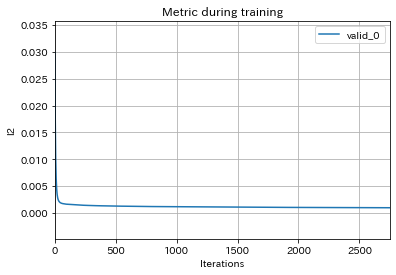

In [35]:
lgb.plot_metric(LGBM)

In [36]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [37]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9905860016191788
valid: 0.9686944170056525
test: 0.9615350351764904


In [38]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 0.5702064722950377
valid: 2.0132278803895174
test: 2.582203465202001


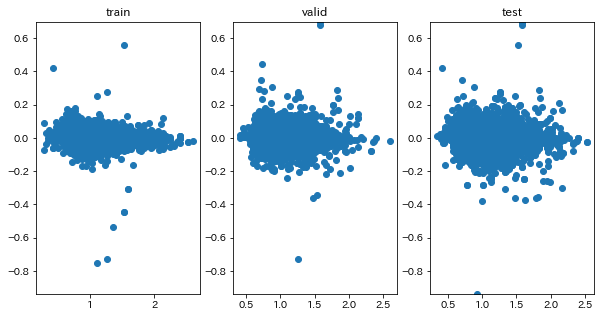

In [39]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [40]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature   importance
0    皇居からの距離   215.836461
1   最寄駅からの距離   103.964855
2         面積  7918.804014
3        築年数  1251.801941
4         地上   289.264314
5          階   124.547592
6       市区町村  2069.754947
7         路線   112.451001
8          駅  1465.796943
9        間取り  6240.681644
10        構造   265.777065
11      取引態様     1.478308

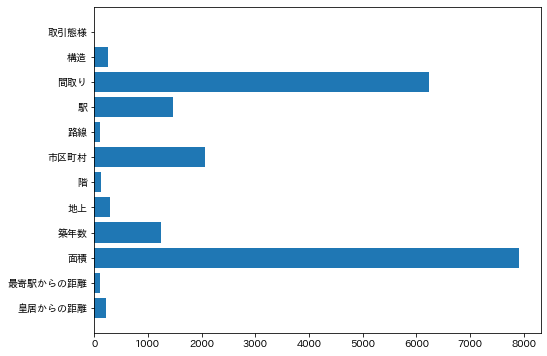

In [41]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig("./data/image/elite_feature_importances.png")
plt.show()

# オプションを追加する

結論：大きく役に立つ情報は既に得られている。細かいところを補足してくれる情報が必要らしい。

In [138]:
# スコアの器
scores = []
i = 0

# オプションごとに調査
for option in table_isoption.columns[300:400]:
    print(f'{i}回目')
    i += 1

    # 追加するオプション
    option_features = [option]
    add_option = table_isoption[option_features]

    # 準備フェイズ

    # 事前のデータ加工なし
    # 順番をシャッフル
    suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))
    suumo_light = pd.merge(suumo_light,add_option,left_index=True, right_index=True)

    # 変数は(だいたい使うであろう皆さんを)全部そのまま使用
    quantity_features = [
        '皇居からの距離',
    #    '歩', # 13
    #    'バス', # 16
    #    '車', # 2
        '最寄駅からの距離',
    #    '部屋数', # 4
        '面積',
        '築年数',
    #    '階数', # 5
    #    '地下', # 17
        '地上',
        '階',
    #    'オプション数', # 0
    #    '駐車場距離', # 14
    #    '駐車場料金', # 6
    #    '条件数', # 9
    ]
    category_features = [
        '市区町村',
        '路線',
        '駅',
        '間取り',
    #    '向き', # 1
    #    '建物種別', # 10
        '構造',
    #    '入居', # 15
        '取引態様',
    ]
    is_features = [
    #    '間取り_S', # 11
    #    '間取り_L', # 7
    #    '間取り_D', # 12
    #    '間取り_K', # 3
    #    '駐車場有無', # 8
    ]
    target_feature = '家賃'
    features = np.r_[quantity_features,category_features,is_features,option_features]

    # カテゴリ変数をLabelEncoding
    LE = LabelEncoder()
    for feature in category_features:
        suumo_light[feature] = LE.fit_transform(suumo_light[feature])
        # ラベル対応表も作っておく
        num = np.arange(suumo_light[feature].unique().shape[0])
        name = LE.inverse_transform(num)
        exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")

    # カテゴリとisをカテゴリ型に変換
    suumo_light[category_features] = suumo_light[category_features].astype('category')
    suumo_light[is_features] = suumo_light[is_features].astype('category')
    suumo_light[option_features] = suumo_light[option_features].astype('category')

    # 賃料に対数変換を施す
    suumo_light['家賃'] = np.log10(suumo_light['家賃'])

    # Xとyを定義
    X = suumo_light[features]
    y = suumo_light[target_feature]

    # 学習用とテスト用に分割
    train_test = 0.7
    train_valid = 0.8

    X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

    # モデルを構築、学習
    LGBM = lgb.LGBMRegressor(
        n_estimators = 5000,
    #    num_leaves = 1000, 
        random_state = 0,
        importance_type = 'gain'
    )

    verbose_eval = 0
    LGBM.fit(X_train,y_train,
            eval_set=[(X_valid,y_valid)],
            eval_metric = 'mse',
            callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                        lgb.log_evaluation(verbose_eval)])

    # それぞれの予測結果を収納
    y_test_pred = LGBM.predict(X_test)

    # それぞれのr2スコアを算出
    # print('test:',r2_score(10**y_test,10**y_test_pred))

    # それぞれのMSEを算出
    # print('test:',mean_squared_error(10**y_test,10**y_test_pred))

    # 変数重要度
    table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
    table_importances['importance'] = table_importances['importance'].astype(float)
    condition = table_importances['feature'] == option_features[0]
    scores.append([
        table_importances.loc[12,'feature'],
        r2_score(10**y_test,10**y_test_pred),
        table_importances.loc[12,'importance']
    ])

0回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2593]	valid_0's l2: 0.000977154
1回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2436]	valid_0's l2: 0.000994305
2回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2138]	valid_0's l2: 0.00101015
3回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2256]	valid_0's l2: 0.00100316
4回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1453]	valid_0's l2: 0.0010812
5回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2042]	valid_0's l2: 0.00102218
6回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1582]	valid_0's l2: 0.00106698
7回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2499]	valid_0's l2: 0.00098726
8回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3438]	valid_0's l2: 0.000934633
9回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1919]	valid_0's l2: 0.00102975
10回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2960]	valid_0's l2: 0.000960318
11回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1524]	valid_0's l2: 0.00106482
12回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1866]	valid_0's l2: 0.00102987
13回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2788]	valid_0's l2: 0.000965798
14回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1460]	valid_0's l2: 0.00107713
15回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1797]	valid_0's l2: 0.00104281
16回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1304]	valid_0's l2: 0.00110202
17回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1619]	valid_0's l2: 0.00106063
18回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2226]	valid_0's l2: 0.00101169
19回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2153]	valid_0's l2: 0.00101278
20回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1760]	valid_0's l2: 0.00105
21回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1604]	valid_0's l2: 0.00107204
22回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3176]	valid_0's l2: 0.000947226
23回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1325]	valid_0's l2: 0.00109547
24回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1612]	valid_0's l2: 0.00105516
25回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1148]	valid_0's l2: 0.00112652
26回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1395]	valid_0's l2: 0.00108541
27回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1983]	valid_0's l2: 0.0010238
28回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2286]	valid_0's l2: 0.00100602
29回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1745]	valid_0's l2: 0.00104153
30回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1889]	valid_0's l2: 0.00103901
31回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2264]	valid_0's l2: 0.00100822
32回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1906]	valid_0's l2: 0.00103325
33回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3268]	valid_0's l2: 0.000938808
34回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1445]	valid_0's l2: 0.00108926
35回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2390]	valid_0's l2: 0.000994328
36回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1994]	valid_0's l2: 0.00103131
37回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1712]	valid_0's l2: 0.00105294
38回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2322]	valid_0's l2: 0.00100054
39回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2157]	valid_0's l2: 0.00101263
40回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2406]	valid_0's l2: 0.00099214
41回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2101]	valid_0's l2: 0.00101533
42回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1889]	valid_0's l2: 0.0010287
43回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2590]	valid_0's l2: 0.000979312
44回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1299]	valid_0's l2: 0.00110121
45回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2268]	valid_0's l2: 0.00100153
46回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2816]	valid_0's l2: 0.000963917
47回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1911]	valid_0's l2: 0.00103098
48回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1998]	valid_0's l2: 0.00101964
49回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1969]	valid_0's l2: 0.00102307
50回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1907]	valid_0's l2: 0.00103316
51回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1518]	valid_0's l2: 0.0010628
52回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2148]	valid_0's l2: 0.00100554
53回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2113]	valid_0's l2: 0.00101481
54回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3735]	valid_0's l2: 0.000924892
55回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2845]	valid_0's l2: 0.000963534
56回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2591]	valid_0's l2: 0.00097921
57回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1838]	valid_0's l2: 0.00103517
58回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1559]	valid_0's l2: 0.00107465
59回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2313]	valid_0's l2: 0.000995663
60回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2084]	valid_0's l2: 0.00101283
61回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1719]	valid_0's l2: 0.00105403
62回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1855]	valid_0's l2: 0.00103172
63回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2546]	valid_0's l2: 0.000982629
64回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1747]	valid_0's l2: 0.00105162
65回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1315]	valid_0's l2: 0.00110174
66回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3097]	valid_0's l2: 0.000946526
67回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2478]	valid_0's l2: 0.000989684
68回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2738]	valid_0's l2: 0.000971915
69回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2111]	valid_0's l2: 0.00102329
70回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1403]	valid_0's l2: 0.00109416
71回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2189]	valid_0's l2: 0.00100534
72回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1487]	valid_0's l2: 0.00107756
73回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2523]	valid_0's l2: 0.000988633
74回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2129]	valid_0's l2: 0.00100821
75回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1625]	valid_0's l2: 0.00106173
76回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1870]	valid_0's l2: 0.0010328
77回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1832]	valid_0's l2: 0.00104432
78回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2005]	valid_0's l2: 0.00102341
79回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2437]	valid_0's l2: 0.000989508
80回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1422]	valid_0's l2: 0.00108891
81回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2369]	valid_0's l2: 0.000994284
82回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1942]	valid_0's l2: 0.00101874
83回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1740]	valid_0's l2: 0.00105504
84回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1947]	valid_0's l2: 0.00102722
85回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2041]	valid_0's l2: 0.00102142
86回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3628]	valid_0's l2: 0.000923963
87回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2738]	valid_0's l2: 0.000971915
88回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1328]	valid_0's l2: 0.00110424
89回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2390]	valid_0's l2: 0.000997333
90回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1709]	valid_0's l2: 0.0010525
91回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2738]	valid_0's l2: 0.000971915
92回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1446]	valid_0's l2: 0.00108149
93回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2738]	valid_0's l2: 0.000971915
94回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2738]	valid_0's l2: 0.000971915
95回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1584]	valid_0's l2: 0.00105851
96回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2738]	valid_0's l2: 0.000971915
97回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2738]	valid_0's l2: 0.000971915
98回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2456]	valid_0's l2: 0.000989099
99回目


C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2738]	valid_0's l2: 0.000971915


In [141]:
plus_option_400 = pd.DataFrame(scores,columns=['features','r2score','importance'])
plus_option_400[:50]

features   r2score  importance
0         is二重天井構造  0.960333    0.006903
1         is学生敷金不要  0.961035    0.048928
2      isガラストップコンロ  0.961671    0.025597
3      isアイランドキッチン  0.961534    0.621011
4         is和室8畳以上  0.958664    0.571132
5          is収納2間半  0.960892    0.194352
6       is外装リフォーム済  0.960716    0.282789
7        isシアタールーム  0.962466    0.032651
8         isウッドデッキ  0.963024    0.406958
9      is内外装リフォーム済  0.960917    0.213875
10     is太陽光発電システム  0.961636    0.010155
11         is高断熱住宅  0.958879    0.139065
12         is屋根裏収納  0.959880    0.036140
13         is駐車4台可  0.962433    0.616666
14        is敷地内遊び場  0.959862    0.032291
15         isカーポート  0.960086    0.042956
16       is3面バルコニー  0.960012    0.188974
17        isフットライト  0.959459    0.028642
18         is玄関手すり  0.960427    0.056904
19       isリビング吹抜け  0.961640    0.111004
20       isアスレチックR  0.958741    0.040098
21            is南庭  0.959166    0.099953
22          is続き和室  0.962441    0.105914
23     isインナーバルコニー  0.958357    0.005453
24           is防音室  0.960708    1.884272
25         is電話2回線  0.956577    0.041121
26         is外断熱工法  0.958972    0.000000
27        isエコジョーズ  0.960804    0.000000
28         isアルコーブ  0.961377    0.029985
29         isサンルーム  0.960902    0.097292
30            is天窓  0.960011    0.081259
31         is駐車3台可  0.960732    0.002108
32      isシーリングファン  0.960745    0.322850
33  isウォークスルークロゼット  0.962957    0.138594
34         is畳コーナー  0.958738    0.173983
35     is初期費用5万円以下  0.960595    0.043015
36    isノンホルムアルデヒド  0.961280    0.016355
37          is地下車庫  0.960587    0.169893
38           isプール  0.961277    0.077235
39           is耐震扉  0.961872    0.069079
40         is2階洗面台  0.961551    0.829981
41     is天井高2.7m以上  0.960995    0.001022
42        isガスオーブン  0.960738    0.039903
43      is来客用パーキング  0.962187    0.015931
44      is省エネルギー対策  0.958472    0.012492
45        isシェアハウス  0.961376    3.724432
46         is無垢材使用  0.961972    0.298453
47        is大型タウン内  0.960523    0.048792
48      is高気密高断熱住宅  0.961387    0.113311
49        is事務所付住宅  0.962416    0.284678

In [142]:
plus_option_400.sort_values('r2score')

features   r2score  importance
25         is電話2回線  0.956577    0.041121
88          isDIY可  0.957208    0.296536
65     isメーターモジュール  0.958300    0.012558
23     isインナーバルコニー  0.958357    0.005453
44      is省エネルギー対策  0.958472    0.012492
..             ...       ...         ...
7        isシアタールーム  0.962466    0.032651
86        isドライエリア  0.962514    0.027528
33  isウォークスルークロゼット  0.962957    0.138594
8         isウッドデッキ  0.963024    0.406958
54          is南面4室  0.963047    0.024653

[100 rows x 3 columns]

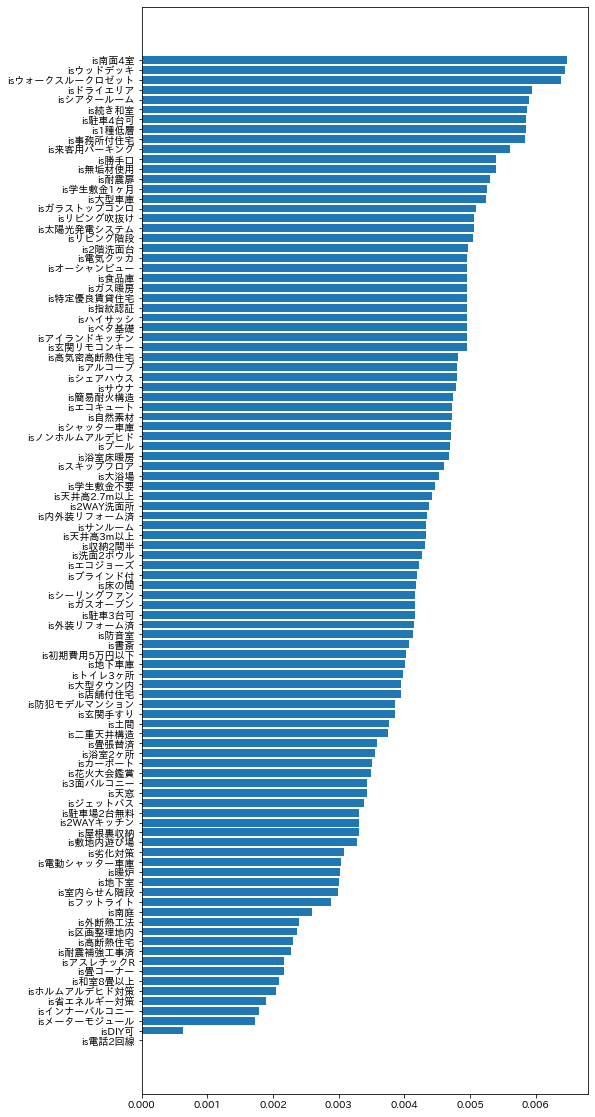

In [143]:
# 300~400
plt.figure(figsize=(8,20))
plt.barh(plus_option_400.sort_values('r2score')['features'],plus_option_400.sort_values('r2score')['r2score']-plus_option_400['r2score'].min())
plt.show()

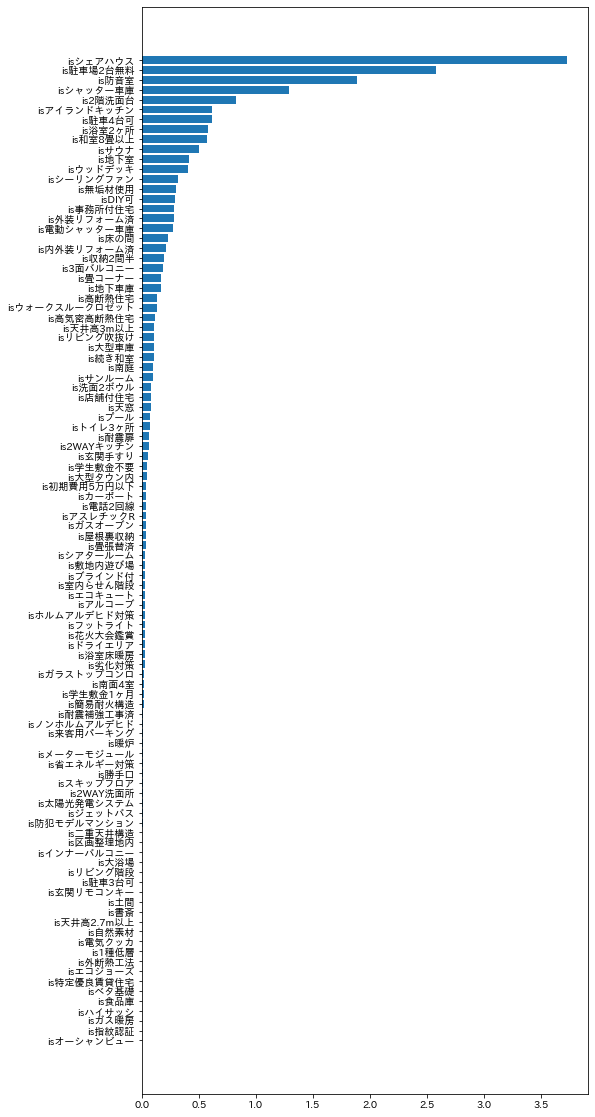

In [144]:
# 300~400
plt.figure(figsize=(8,20))
plt.barh(plus_option_400.sort_values('importance')['features'],plus_option_400.sort_values('importance')['importance']-plus_option_400['importance'].min())
plt.show()

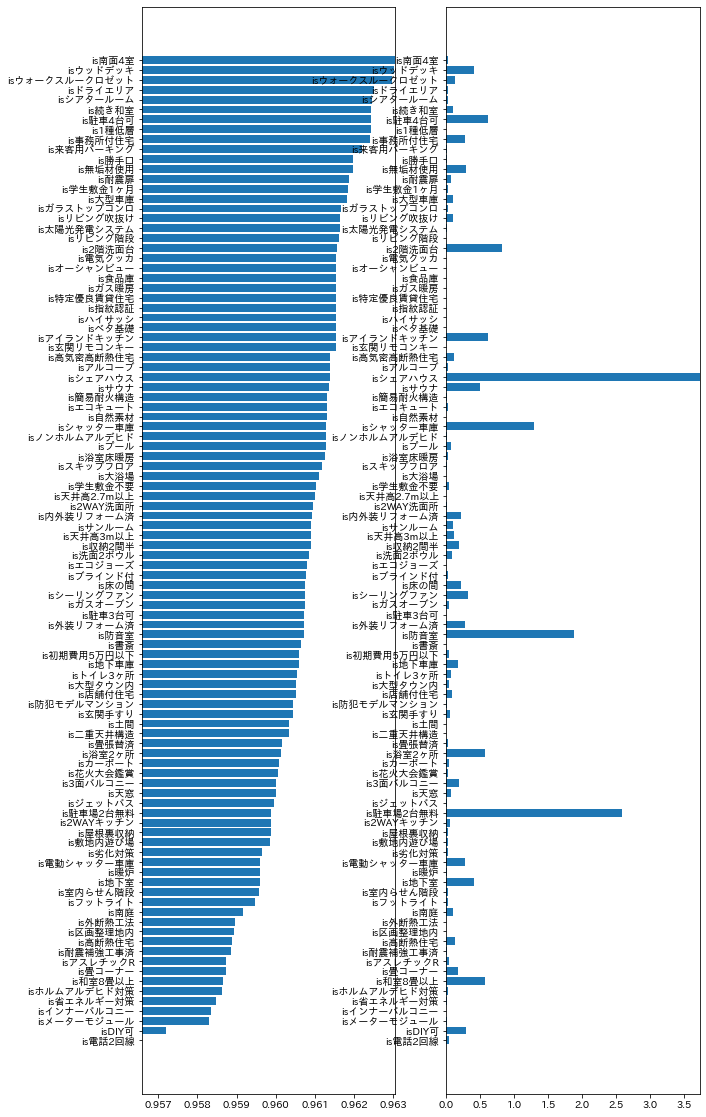

In [145]:
# オプションの存在は大事ですか？
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,20))

axes[0].barh(plus_option_400.sort_values('r2score')['features'],plus_option_400.sort_values('r2score')['r2score'])
axes[0].set_xlim(plus_option_400['r2score'].min(),plus_option_400['r2score'].max())
axes[1].barh(plus_option_400.sort_values('r2score')['features'],plus_option_400.sort_values('r2score')['importance'])
axes[1].set_xlim(plus_option_400['importance'].min(),plus_option_400['importance'].max())
plt.show()

In [133]:
plus_option_300 = pd.DataFrame(scores,columns=['features','r2score','importance'])
plus_option_300[:50]

features   r2score  importance
0           is防犯ガラス  0.959021    0.207066
1           is礼金2ヶ月  0.961365    1.228252
2       is2WAYバルコニー  0.961358    0.782232
3         is1フロア1住戸  0.960092    0.297273
4      is初期費用30万円以下  0.962045    0.525223
5         isディスポーザー  0.958069    5.979536
6        isコインランドリー  0.959586    1.887439
7              is納戸  0.958392    0.172294
8            is間接照明  0.959413    0.422535
9              is天袋  0.962260    0.914191
10         isオートライト  0.960352    1.105953
11         is全室東南向き  0.961539    0.384485
12         is全室南西向き  0.960902    0.356806
13       isオープンキッチン  0.955701    0.179892
14          is四方角部屋  0.957571    0.706152
15  isダイニングテーブル・デスク  0.959478    4.293821
16        isL字型キッチン  0.961744    0.314586
17         isトイレ2ヶ所  0.961150    1.395098
18           is免震構造  0.958336    0.168964
19            is専用庭  0.957623    1.065399
20           is電子キー  0.960983    1.299197
21         isISDN対応  0.961374    0.165475
22     is初期費用20万円以下  0.960559    0.437424
23          is電子ロック  0.962065    0.237947
24      is専有面積25坪以上  0.962826    0.381420
25       isLDK18畳以上  0.960586    0.420755
26         isじゅうたん張  0.962314    0.485963
27           is前面棟無  0.962259    0.316577
28          is防音サッシ  0.960158    0.246653
29           is収納2間  0.960888    0.316346
30       is外壁サイディング  0.961548    0.185550
31          is準耐火構造  0.959966    0.036524
32           is制震構造  0.962535    0.214755
33          isバス2路線  0.958522    0.784201
34             is物置  0.962766    0.223341
35          is高齢者歓迎  0.961776    0.195098
36            is乾燥機  0.959242  370.396530
37          isTV付浴室  0.960878    0.096029
38         is可動間仕切り  0.961007    1.026128
39          is玄関ポーチ  0.958869    0.230500
40           is耐風構造  0.960937    0.109252
41      is専有面積30坪以上  0.959541    0.786030
42     is初期費用15万円以下  0.957424    1.163677
43        is寝室10畳以上  0.962142    0.240314
44       isLDK20畳以上  0.958570    1.394446
45      isCATV使用料不要  0.962440    0.188413
46       isゴミ回収サービス  0.958583    0.139524
47       isタンクレストイレ  0.961876    0.487169
48        is駐車場1台無料  0.959953    0.612329
49           is有線放送  0.959630    0.061474

In [134]:
plus_option_300.sort_values('r2score')

features   r2score  importance
93     isオーブンレンジ  0.953036    2.390370
13    isオープンキッチン  0.955701    0.179892
76       is二重床構造  0.955845    0.022236
73     is電動シャッター  0.957348    0.558203
42  is初期費用15万円以下  0.957424    1.163677
..           ...       ...         ...
51      is浴室1坪以上  0.962745    1.584204
34          is物置  0.962766    0.223341
24   is専有面積25坪以上  0.962826    0.381420
87     isII型キッチン  0.962927    0.061405
53   is内装リフォーム後渡  0.963067    3.052492

[100 rows x 3 columns]

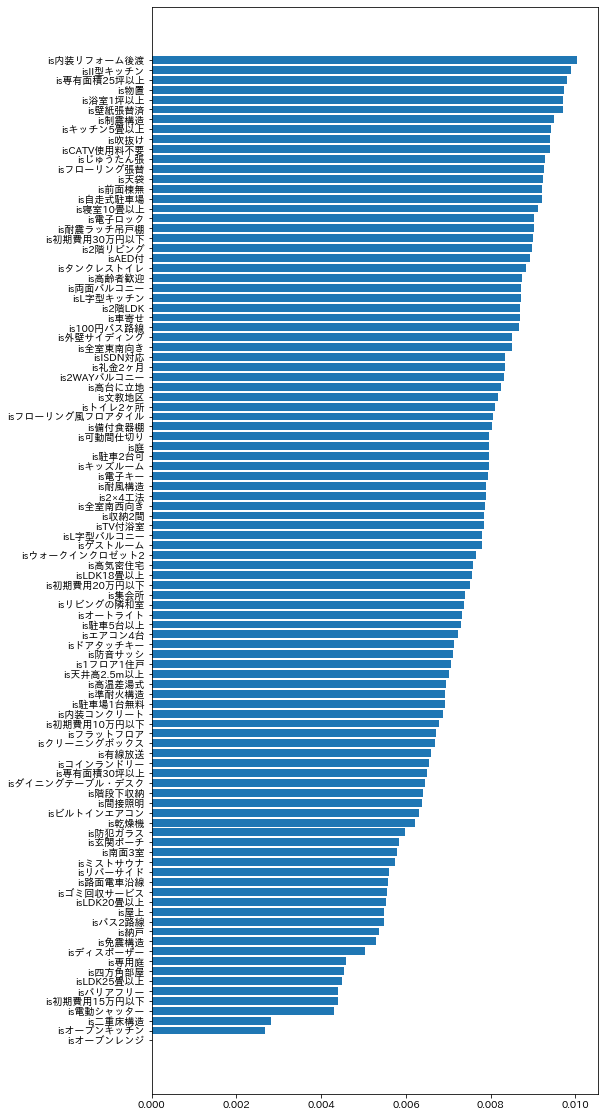

In [135]:
# 200~300
plt.figure(figsize=(8,20))
plt.barh(plus_option_300.sort_values('r2score')['features'],plus_option_300.sort_values('r2score')['r2score']-plus_option_300['r2score'].min())
plt.show()

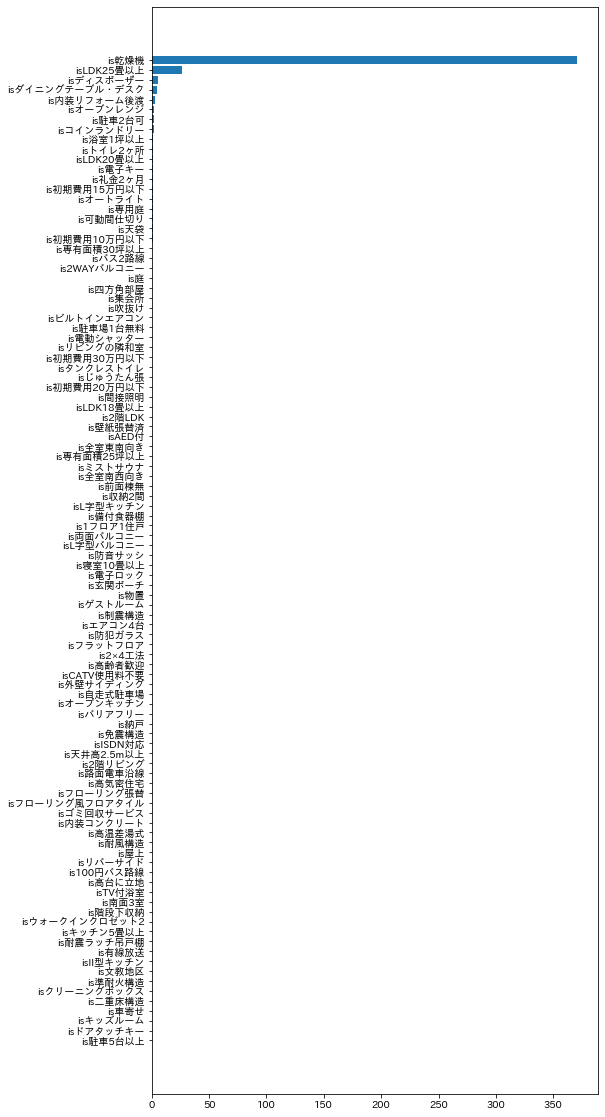

In [136]:
# 200~300
plt.figure(figsize=(8,20))
plt.barh(plus_option_300.sort_values('importance')['features'],plus_option_300.sort_values('importance')['importance']-plus_option_300['importance'].min())
plt.show()

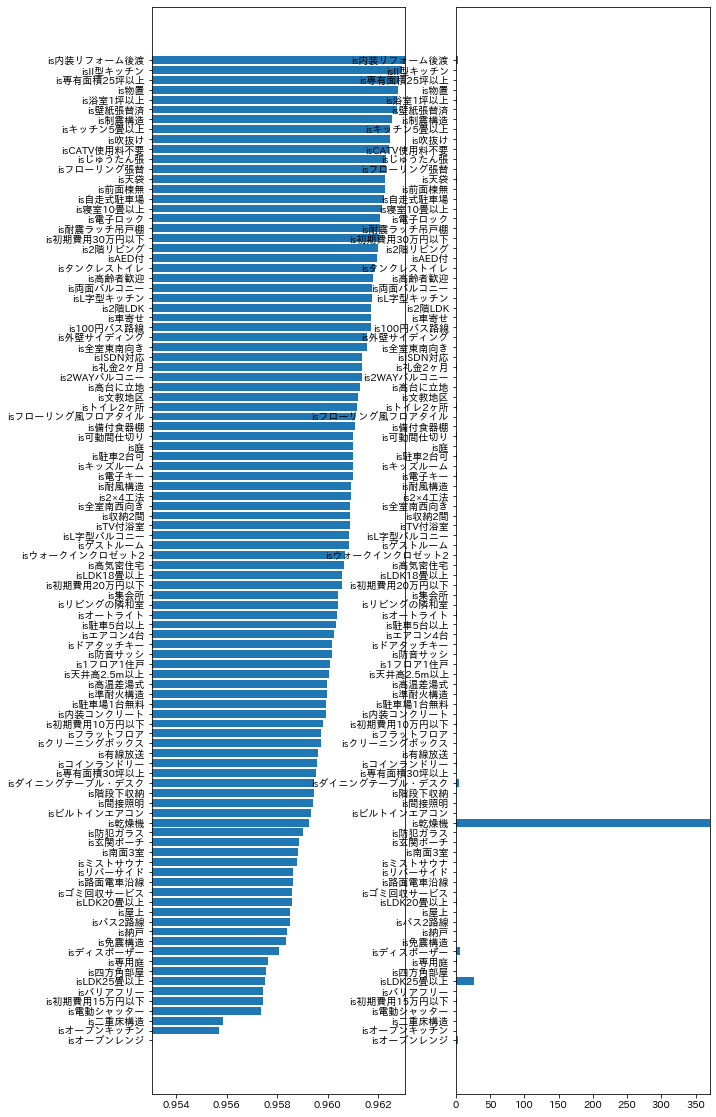

In [137]:
# オプションの存在は大事ですか？
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,20))

axes[0].barh(plus_option_300.sort_values('r2score')['features'],plus_option_300.sort_values('r2score')['r2score'])
axes[0].set_xlim(plus_option_300['r2score'].min(),plus_option_300['r2score'].max())
axes[1].barh(plus_option_300.sort_values('r2score')['features'],plus_option_300.sort_values('r2score')['importance'])
axes[1].set_xlim(plus_option_300['importance'].min(),plus_option_300['importance'].max())
plt.show()

In [127]:
plus_option_200 = pd.DataFrame(scores,columns=['features','r2score','importance'])
plus_option_200[:50]

features   r2score  importance
0       is人感照明センサー  0.958065    1.808066
1             is押入  0.958809    9.705000
2          is室内物干機  0.961515    0.941338
3    isCATVインターネット  0.959315    1.425444
4          is年内入居可  0.958272    0.599016
5         is南面リビング  0.955012    1.095873
6        is独立型キッチン  0.960302    0.970055
7         isエアコン2台  0.956016    4.192546
8          is築3年以内  0.960577    0.263462
9       isルームシェア相談  0.960139    2.368617
10           isロフト  0.960025    7.148845
11          is日勤管理  0.959253    1.350589
12          is学生相談  0.962876    1.817580
13        isキッチンに窓  0.960940    2.299486
14      isクロゼット2ヶ所  0.959997    1.927394
15        is当社管理物件  0.961545    2.386284
16      isLDK12畳以上  0.958529    1.211080
17        is年度内入居可  0.959669    0.668263
18         is複層ガラス  0.961086    3.963663
19   isセキュリティ会社加入済  0.962314    2.498340
20        isトイレ未使用  0.958897    0.877293
21         is全室照明付  0.959165    2.826310
22           is家具付  0.957057   20.166144
23            is振分  0.955031    1.119252
24         isシャッター  0.965308    3.010602
25           is家電付  0.961453   16.909576
26           is冷蔵庫  0.959064   14.925424
27            is和室  0.962564    7.108176
28      is内装リフォーム済  0.960890    2.347480
29          is浴室に窓  0.960734    1.716926
30           is床暖房  0.957291   47.181817
31            is駅前  0.959291    0.625847
32      is家賃カード決済可  0.959975    0.683933
33           isLAN  0.960779    0.959283
34         is東南角住戸  0.958693    0.426858
35      is一部フローリング  0.961772    1.110917
36        isプロパンガス  0.958775    2.221395
37            is出窓  0.957139    1.051802
38          is楽器相談  0.958716    9.874842
39         is3方角住戸  0.961657    0.949173
40       is緑豊かな住宅地  0.959007    0.887152
41         is事務所相談  0.960422    4.029430
42       is防犯シャッター  0.963265    2.153996
43          is3面採光  0.958601    0.956418
44         is南西角住戸  0.960159    0.507386
45     isバス停徒歩3分以内  0.960493    0.435407
46        isダウンライト  0.961100    1.414096
47           is浄水器  0.959353    2.238624
48  isマルチメディアコンセント  0.961564    0.416464
49         is浴室未使用  0.961845    1.140419

In [128]:
plus_option_200.sort_values('r2score')

features   r2score  importance
5    is南面リビング  0.955012    1.095873
23       is振分  0.955031    1.119252
7    isエアコン2台  0.956016    4.192546
71    is電子レンジ  0.956223    9.555699
22      is家具付  0.957057   20.166144
..        ...       ...         ...
99   is防犯強化地域  0.962682    0.390342
12     is学生相談  0.962876    1.817580
42  is防犯シャッター  0.963265    2.153996
59      is洗濯機  0.963600    7.182231
24    isシャッター  0.965308    3.010602

[100 rows x 3 columns]

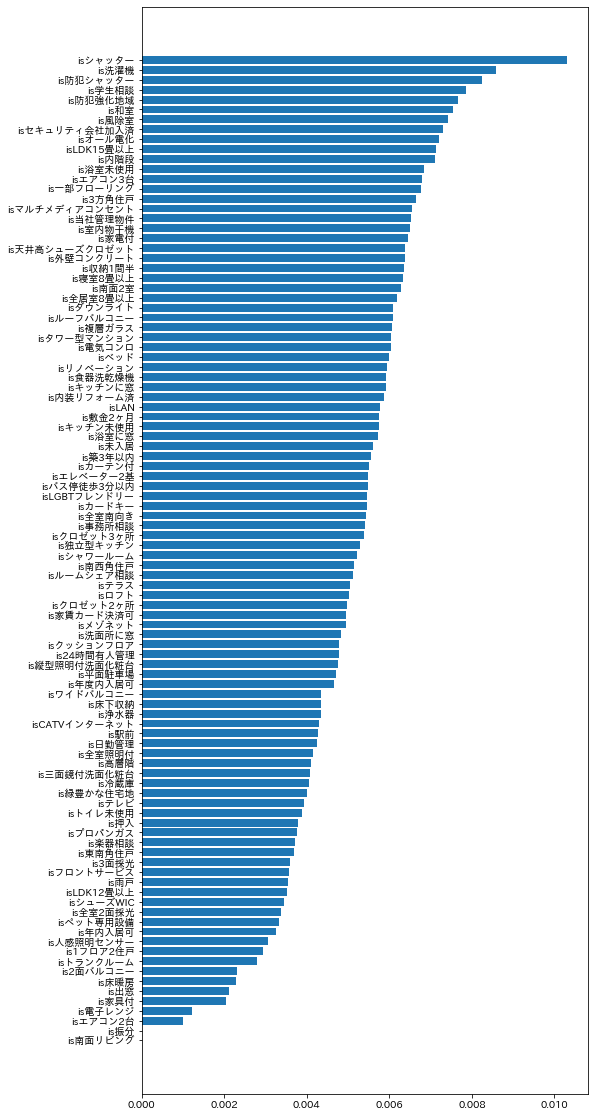

In [129]:
# 100~200
plt.figure(figsize=(8,20))
plt.barh(plus_option_200.sort_values('r2score')['features'],plus_option_200.sort_values('r2score')['r2score']-plus_option_200['r2score'].min())
plt.show()

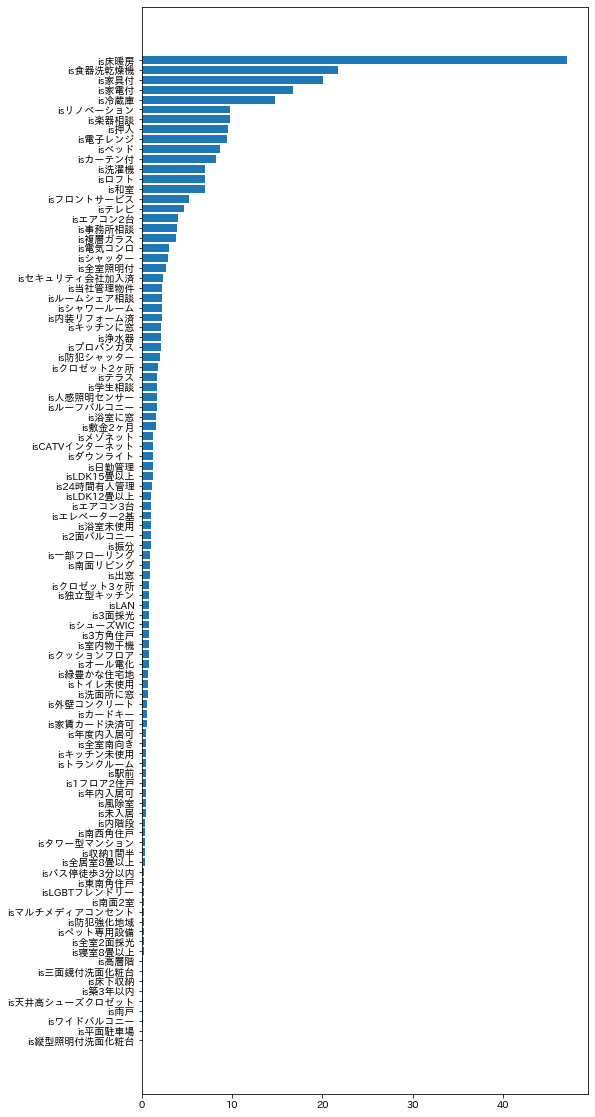

In [130]:
# 100~200
plt.figure(figsize=(8,20))
plt.barh(plus_option_200.sort_values('importance')['features'],plus_option_200.sort_values('importance')['importance']-plus_option_200['importance'].min())
plt.show()

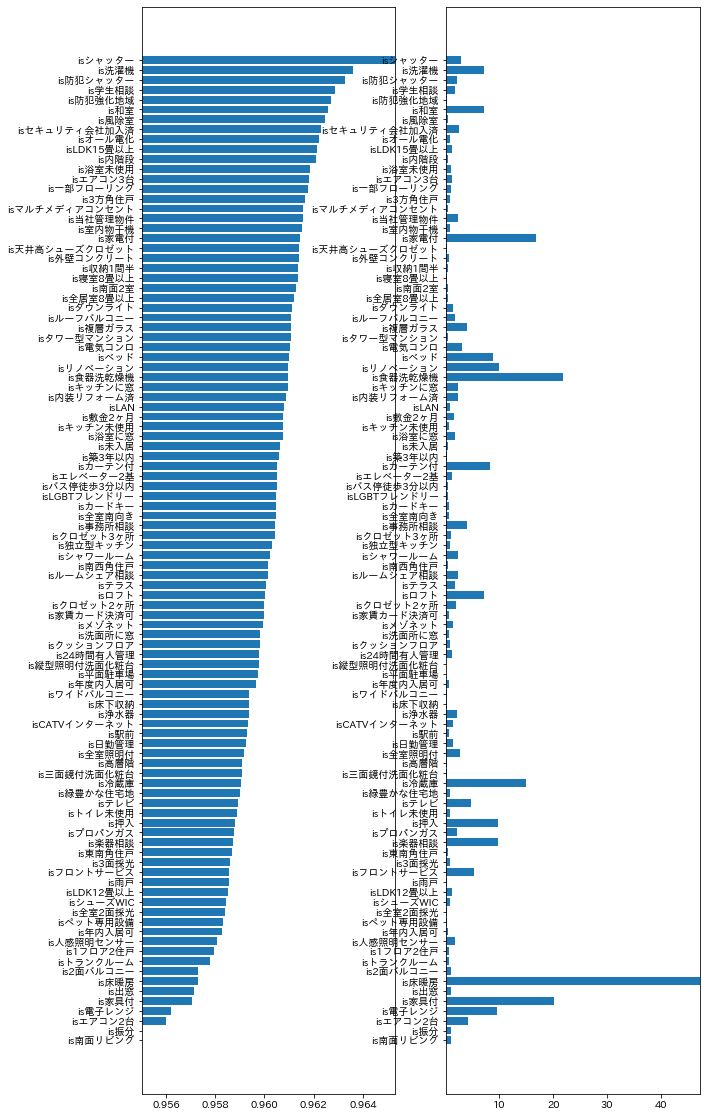

In [131]:
# オプションの存在は大事ですか？
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,20))

axes[0].barh(plus_option_200.sort_values('r2score')['features'],plus_option_200.sort_values('r2score')['r2score'])
axes[0].set_xlim(plus_option_200['r2score'].min(),plus_option_200['r2score'].max())
axes[1].barh(plus_option_200.sort_values('r2score')['features'],plus_option_200.sort_values('r2score')['importance'])
axes[1].set_xlim(plus_option_200['importance'].min(),plus_option_200['importance'].max())
plt.show()

In [122]:
plus_option_100 = pd.DataFrame(scores,columns=['features','r2score','importance'])
plus_option_100[:50]

features   r2score  importance
0         isエアコン  0.960287    6.493134
1        is室内洗濯置  0.960027   19.632318
2       isバストイレ別  0.960743  190.147294
3       isフローリング  0.961138    8.414258
4         is都市ガス  0.957532    5.795516
5     isシューズボックス  0.961751   10.359156
6        isバルコニー  0.957291    5.717995
7        isクロゼット  0.961911   14.232161
8     isTVインターホン  0.960624   25.567772
9     isシステムキッチン  0.960863  243.257308
10      isオートロック  0.956657  303.600316
11         is駐輪場  0.961287    7.016302
12      is温水洗浄便座  0.958539   82.535630
13     isガスコンロ対応  0.957817    6.338923
14       is洗面所独立  0.953072  398.127317
15       is保証人不要  0.960985    6.756841
16     is3駅以上利用可  0.960962    9.950024
17        is即入居可  0.959508    6.217332
18       is浴室乾燥機  0.958163  315.145441
19    is駅徒歩10分以内  0.960466    8.180996
20      is宅配ボックス  0.955050  608.222752
21      isエレベーター  0.960275  196.223413
22       is2口コンロ  0.954715    5.452454
23    is敷地内ごみ置き場  0.956704    4.859261
24  is初期費用カード決済可  0.959922    8.263966
25      is2沿線利用可  0.957645    4.308588
26      is光ファイバー  0.961895    7.098233
27         is角住戸  0.959124    6.057921
28       is洗面化粧台  0.962328   11.300364
29       is防犯カメラ  0.958527   11.560555
30    is3沿線以上利用可  0.960919    7.339842
31       is敷金1ヶ月  0.961577    8.177655
32   isIT重説 対応物件  0.963913    9.618157
33         is脱衣所  0.957816    7.401422
34       is2駅利用可  0.961334    6.534081
35     is駅徒歩5分以内  0.958589    8.671865
36        isCATV  0.959938    7.925548
37   is全居室フローリング  0.961076    9.149698
38        is礼金不要  0.963090   14.421459
39       is保証金不要  0.961211    5.472314
40       is礼金1ヶ月  0.959986    7.200707
41      is追焚機能浴室  0.958430   42.927142
42          isBS  0.957859    5.216499
43    isネット使用料不要  0.961367    8.449684
44  is24時間換気システム  0.962403    3.968549
45     is高速ネット対応  0.959897    4.451529
46     is保証会社利用可  0.962325    4.540774
47     is外壁タイル張り  0.959061    4.389839
48        is2面採光  0.963978    6.423892
49        is敷金不要  0.963048    5.832907

In [108]:
plus_option_100.sort_values('r2score')

features   r2score  importance
14      is洗面所独立  0.953072  398.127317
22      is2口コンロ  0.954715    5.452454
20     is宅配ボックス  0.955050  608.222752
65   isシャワー付洗面台  0.955337    6.353956
71   isダブルロックキー  0.956343    2.702249
..          ...       ...         ...
64     is二人入居相談  0.963311    5.690429
32  isIT重説 対応物件  0.963913    9.618157
48       is2面採光  0.963978    6.423892
55    is敷金・礼金不要  0.964213    7.643032
90        is始発駅  0.965458    4.002956

[100 rows x 3 columns]

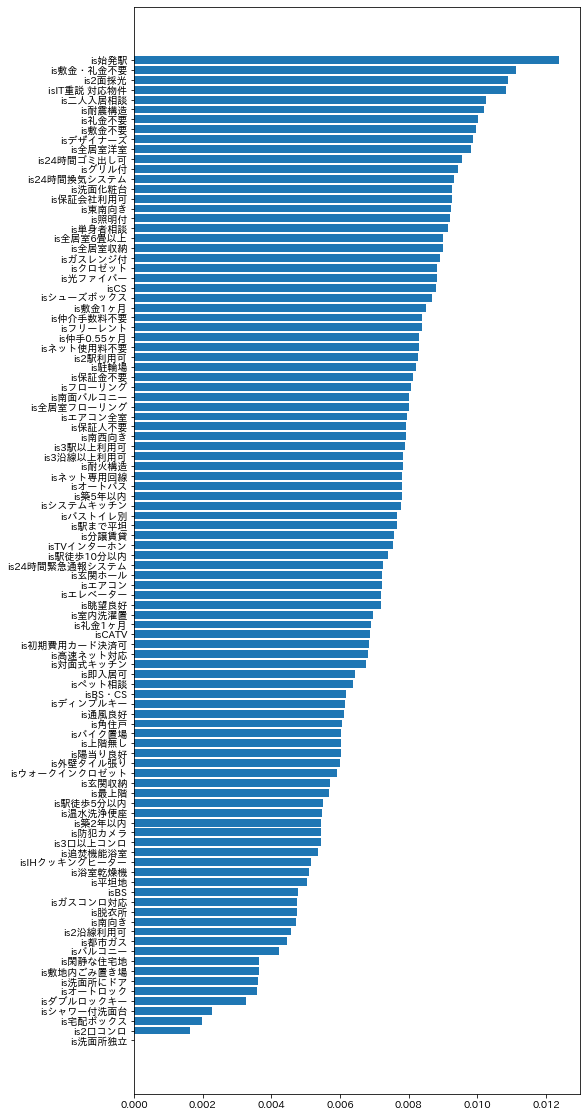

In [123]:
# 0~100
plt.figure(figsize=(8,20))
plt.barh(plus_option_100.sort_values('r2score')['features'],plus_option_100.sort_values('r2score')['r2score']-plus_option_100['r2score'].min())
plt.show()

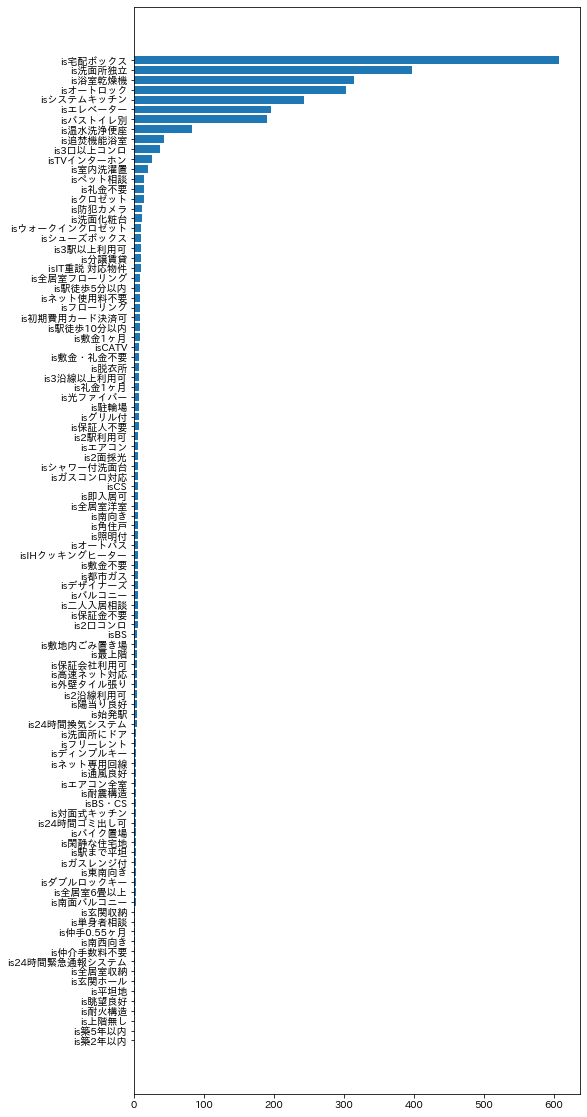

In [124]:
# 0~100
plt.figure(figsize=(8,20))
plt.barh(plus_option_100.sort_values('importance')['features'],plus_option_100.sort_values('importance')['importance']-plus_option_100['importance'].min())
plt.show()

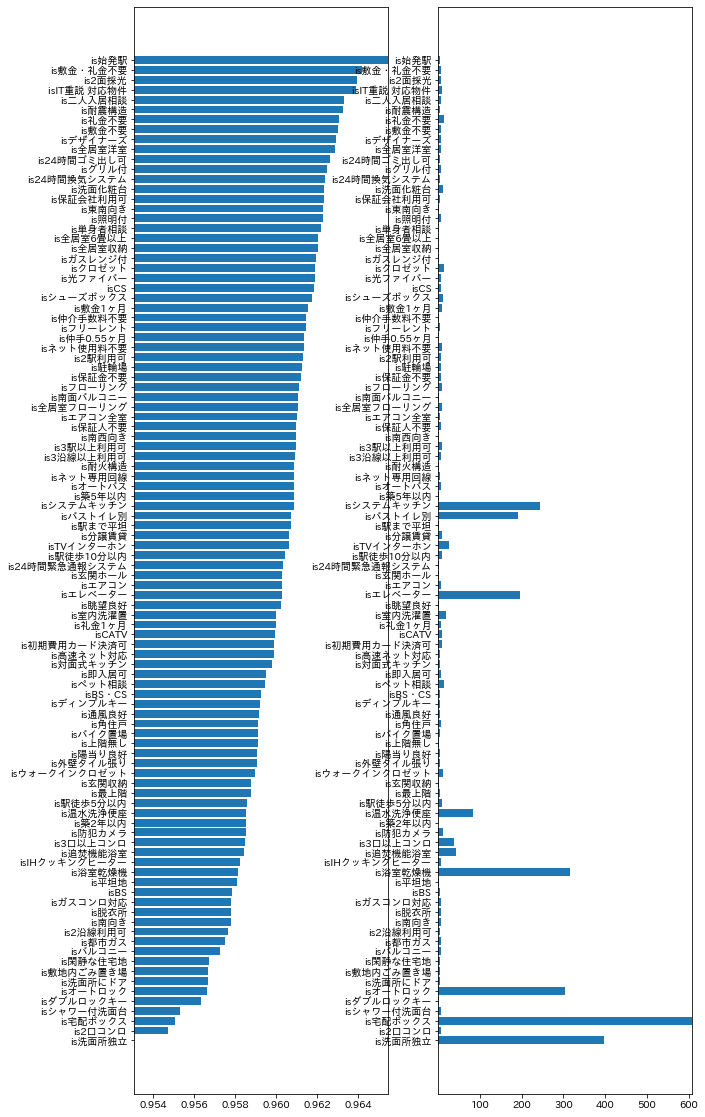

In [125]:
# オプションの存在は大事ですか？
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,20))

axes[0].barh(plus_option_100.sort_values('r2score')['features'],plus_option_100.sort_values('r2score')['r2score'])
axes[0].set_xlim(plus_option_100['r2score'].min(),plus_option_100['r2score'].max())
axes[1].barh(plus_option_100.sort_values('r2score')['features'],plus_option_100.sort_values('r2score')['importance'])
axes[1].set_xlim(plus_option_100['importance'].min(),plus_option_100['importance'].max())
plt.show()

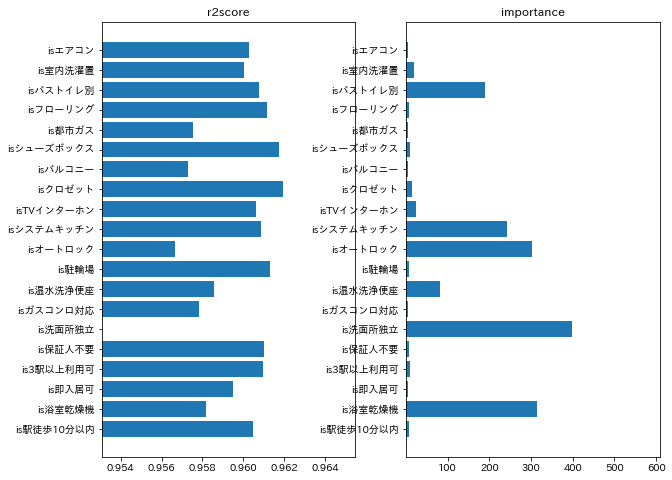

In [355]:
# オプションの存在は大事ですか？
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,8))

axes[0].barh(plus_option_100['features'][::-1][-20:],plus_option_100['r2score'][::-1][-20:])
axes[0].set_xlim(plus_option_100['r2score'].min(),plus_option_100['r2score'].max())
axes[0].set_title('r2score')
axes[1].barh(plus_option_100['features'][::-1][-20:],plus_option_100['importance'][::-1][-20:])
axes[1].set_xlim(plus_option_100['importance'].min(),plus_option_100['importance'].max())
axes[1].set_title('importance')
plt.show()

In [384]:
plus_option_all = pd.concat([plus_option_100,plus_option_200,plus_option_300,plus_option_400], ignore_index=True).sort_values('r2score',ascending=False)
plus_option_all[:20]

features   r2score  importance
90            is始発駅  0.965458    4.002956
124         isシャッター  0.965308    3.010602
55        is敷金・礼金不要  0.964213    7.643032
48           is2面採光  0.963978    6.423892
32      isIT重説 対応物件  0.963913    9.618157
159           is洗濯機  0.963600    7.182231
64         is二人入居相談  0.963311    5.690429
78           is耐震構造  0.963278    3.253477
142       is防犯シャッター  0.963265    2.153996
38           is礼金不要  0.963090   14.421459
253     is内装リフォーム後渡  0.963067    3.052492
49           is敷金不要  0.963048    5.832907
354          is南面4室  0.963047    0.024653
308        isウッドデッキ  0.963024    0.406958
333  isウォークスルークロゼット  0.962957    0.138594
82         isデザイナーズ  0.962940    5.792574
287       isII型キッチン  0.962927    0.061405
63          is全居室洋室  0.962888    6.198068
112          is学生相談  0.962876    1.817580
224     is専有面積25坪以上  0.962826    0.381420

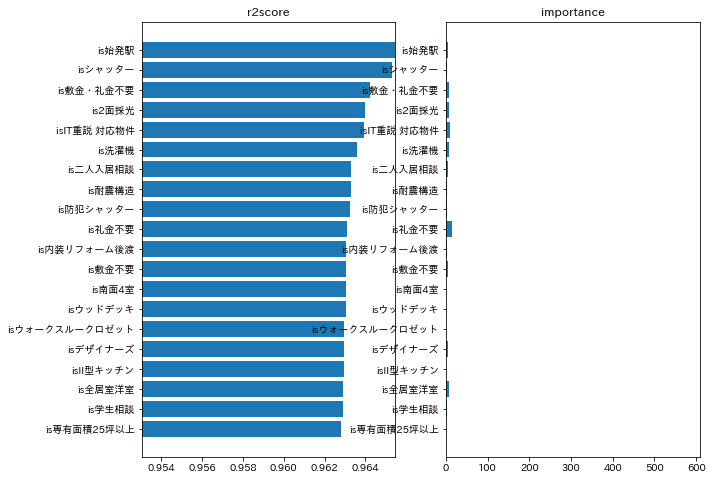

In [374]:
# オプションの存在は大事ですか？
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,8))

axes[0].barh(plus_option_all['features'][::-1][-20:],plus_option_all['r2score'][::-1][-20:])
axes[0].set_xlim(plus_option_all['r2score'].min(),plus_option_all['r2score'].max())
axes[0].set_title('r2score')
axes[1].barh(plus_option_all['features'][::-1][-20:],plus_option_all['importance'][::-1][-20:])
axes[1].set_xlim(plus_option_all['importance'].min(),plus_option_all['importance'].max())
axes[1].set_title('importance')
plt.savefig('./data/image/option_r2_importance_r2scoretop20.png')
plt.show()

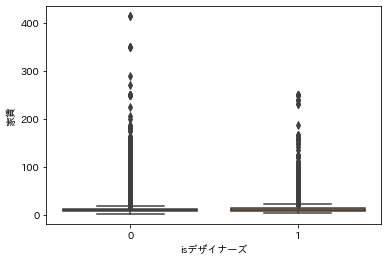

In [389]:
# あるないで違いを見てみよう
i = 82
suumo_option = copy.copy(suumo)
feature = table_isoption.columns[i]
suumo_option[feature] = table_isoption[feature]
sns.boxplot(data=suumo_option,x=feature,y='家賃')
# plt.savefig('./data/image/boxplot_sihatueki_sym.png')
plt.show()

In [381]:
feature = table_isoption.columns[i]
condition = suumo_option[feature] == 0
print(suumo_option.loc[condition,'家賃'].mean())
print(suumo_option.loc[~condition,'家賃'].mean())

10.706095124115706
9.855474669699827


In [301]:
condition = table_isoption.iloc[:,307].astype(bool)
suumo.loc[condition].sort_values('家賃',ascending=False)['家賃'][:50]

14375     57.0
137244    48.0
96297     47.0
96629     47.0
95799     47.0
39567     46.5
14374     43.0
4591      42.9
141353    40.6
141352    39.9
14373     39.8
145891    39.0
109197    39.0
109125    39.0
27324     39.0
27197     39.0
22524     38.8
61526     36.8
61280     36.8
62995     35.0
62826     35.0
63016     35.0
22523     35.0
100999    34.0
25974     33.4
22522     32.9
100997    32.8
1071      30.0
45487     30.0
182897    30.0
2410      29.9
2487      29.9
2488      29.8
193360    29.8
46102     29.8
3835      29.8
2411      29.8
193539    29.8
193725    29.8
68587     29.0
68892     29.0
22986     29.0
69215     29.0
23102     29.0
61279     28.7
61525     28.7
18824     28.7
39336     28.0
14368     28.0
22521     28.0
Name: 家賃, dtype: float64

In [286]:
suumo.sort_values('家賃',ascending=False)['家賃']

168127    413.96
168262    413.96
68        350.00
67        350.00
69        350.00
60568     350.00
60567     290.00
165707    270.00
108705    250.00
165840    250.00
109115    250.00
165721    250.00
109114    250.00
109113    250.00
109112    250.00
108702    250.00
108703    250.00
165722    250.00
108704    250.00
163927    250.00
163924    250.00
165839    250.00
165767    250.00
165766    250.00
163923    250.00
163922    250.00
163925    250.00
163926    250.00
179552    240.00
179465    240.00
179284    240.00
116549    230.00
116555    230.00
165706    225.00
50372     205.00
65140     200.00
177357    187.00
177358    187.00
50371     185.00
2396      180.00
2394      180.00
2395      180.00
2393      180.00
29213     180.00
60566     175.00
133711    175.00
174588    167.00
174858    167.00
174739    167.00
192459    165.00
Name: 家賃, dtype: float64

In [302]:
print(suumo.loc[14375,'url'])

https://suumo.jp/chintai/jnc_000076693575/?bc=100291885690


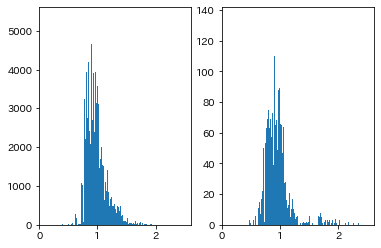

In [254]:
fig, axes = plt.subplots(nrows=1,ncols=2)

max_ = np.log10(suumo_option['家賃']).max()
min_ = np.log10(suumo_option['家賃']).min()

condition = suumo_option[feature] == 0 
axes[0].hist(np.log10(suumo_option.loc[condition,'家賃']), bins=400)
axes[0].set_xlim(min_,max_)
axes[1].hist(np.log10(suumo_option.loc[~condition,'家賃']), bins=400)
axes[1].set_xlim(min_,max_)

plt.show()

# オプション情報だけで家賃は予測できるのか？

結論：無理ではない。精度は0.7くらい。

In [117]:
# 準備フェイズ

# 事前のデータ加工なし
suumo_plus_option = copy.copy(suumo)
target_feature = '家賃'

# オプションテーブルと家賃をつなげる
suumo_plus_option = pd.merge(table_isoption.iloc[:,:300], suumo_plus_option[target_feature], left_index=True, right_index=True)

# 順番をシャッフル
suumo_light = copy.copy(suumo_plus_option.sample(frac=1, random_state=0))

In [118]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [119]:
# Xとyを定義
X = suumo_light.drop(target_feature, axis=1)
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [120]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 1000,
#    num_leaves = 1000, 
    learning_rate = 0.1,
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

[1]	valid_0's l2: 0.0312608
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0279993
[3]	valid_0's l2: 0.025342
[4]	valid_0's l2: 0.0231488
[5]	valid_0's l2: 0.0213366
[6]	valid_0's l2: 0.0198395
[7]	valid_0's l2: 0.0185738
[8]	valid_0's l2: 0.017502
[9]	valid_0's l2: 0.0165546
[10]	valid_0's l2: 0.0157117
[11]	valid_0's l2: 0.0150188
[12]	valid_0's l2: 0.0144425
[13]	valid_0's l2: 0.0139344
[14]	valid_0's l2: 0.0134641
[15]	valid_0's l2: 0.012989
[16]	valid_0's l2: 0.012625
[17]	valid_0's l2: 0.0122962
[18]	valid_0's l2: 0.0120033
[19]	valid_0's l2: 0.0117382
[20]	valid_0's l2: 0.0115081
[21]	valid_0's l2: 0.0112676
[22]	valid_0's l2: 0.0110682
[23]	valid_0's l2: 0.0108949
[24]	valid_0's l2: 0.0107268
[25]	valid_0's l2: 0.0105945
[26]	valid_0's l2: 0.01046
[27]	valid_0's l2: 0.0103366
[28]	valid_0's l2: 0.010221
[29]	valid_0's l2: 0.0101135
[30]	valid_0's l2: 0.0100216
[31]	valid_0's l2: 0.00992627
[32]	valid_0's l2: 0.00982618
[33]	valid_0's l2: 0.0097

[291]	valid_0's l2: 0.00694238
[292]	valid_0's l2: 0.00694
[293]	valid_0's l2: 0.00693656
[294]	valid_0's l2: 0.00693294
[295]	valid_0's l2: 0.00692809
[296]	valid_0's l2: 0.00692587
[297]	valid_0's l2: 0.00692539
[298]	valid_0's l2: 0.00692302
[299]	valid_0's l2: 0.00691932
[300]	valid_0's l2: 0.0069138
[301]	valid_0's l2: 0.00690909
[302]	valid_0's l2: 0.0069078
[303]	valid_0's l2: 0.00690681
[304]	valid_0's l2: 0.00690504
[305]	valid_0's l2: 0.0069011
[306]	valid_0's l2: 0.00689978
[307]	valid_0's l2: 0.00689665
[308]	valid_0's l2: 0.00689312
[309]	valid_0's l2: 0.00688867
[310]	valid_0's l2: 0.00688692
[311]	valid_0's l2: 0.00688208
[312]	valid_0's l2: 0.00687681
[313]	valid_0's l2: 0.00687405
[314]	valid_0's l2: 0.00687176
[315]	valid_0's l2: 0.0068695
[316]	valid_0's l2: 0.00686587
[317]	valid_0's l2: 0.00686305
[318]	valid_0's l2: 0.0068614
[319]	valid_0's l2: 0.00685896
[320]	valid_0's l2: 0.00685629
[321]	valid_0's l2: 0.00685184
[322]	valid_0's l2: 0.00685025
[323]	valid_0's 

[575]	valid_0's l2: 0.00639221
[576]	valid_0's l2: 0.00639126
[577]	valid_0's l2: 0.00638955
[578]	valid_0's l2: 0.0063872
[579]	valid_0's l2: 0.00638329
[580]	valid_0's l2: 0.0063824
[581]	valid_0's l2: 0.00638037
[582]	valid_0's l2: 0.00638027
[583]	valid_0's l2: 0.00637989
[584]	valid_0's l2: 0.00637954
[585]	valid_0's l2: 0.0063796
[586]	valid_0's l2: 0.00637803
[587]	valid_0's l2: 0.0063764
[588]	valid_0's l2: 0.00637593
[589]	valid_0's l2: 0.00637441
[590]	valid_0's l2: 0.00637299
[591]	valid_0's l2: 0.00637178
[592]	valid_0's l2: 0.00637037
[593]	valid_0's l2: 0.00636913
[594]	valid_0's l2: 0.00636787
[595]	valid_0's l2: 0.00636531
[596]	valid_0's l2: 0.00636499
[597]	valid_0's l2: 0.00636447
[598]	valid_0's l2: 0.00636422
[599]	valid_0's l2: 0.00636343
[600]	valid_0's l2: 0.00636113
[601]	valid_0's l2: 0.00636064
[602]	valid_0's l2: 0.00635725
[603]	valid_0's l2: 0.00635549
[604]	valid_0's l2: 0.00635319
[605]	valid_0's l2: 0.00635161
[606]	valid_0's l2: 0.00635015
[607]	valid_

[845]	valid_0's l2: 0.00605472
[846]	valid_0's l2: 0.00605432
[847]	valid_0's l2: 0.00605351
[848]	valid_0's l2: 0.00605124
[849]	valid_0's l2: 0.00604949
[850]	valid_0's l2: 0.00604726
[851]	valid_0's l2: 0.00604599
[852]	valid_0's l2: 0.00604572
[853]	valid_0's l2: 0.00604528
[854]	valid_0's l2: 0.00604518
[855]	valid_0's l2: 0.00604393
[856]	valid_0's l2: 0.00604311
[857]	valid_0's l2: 0.00604192
[858]	valid_0's l2: 0.00604043
[859]	valid_0's l2: 0.00603998
[860]	valid_0's l2: 0.00603827
[861]	valid_0's l2: 0.00603699
[862]	valid_0's l2: 0.00603662
[863]	valid_0's l2: 0.00603563
[864]	valid_0's l2: 0.00603537
[865]	valid_0's l2: 0.00603511
[866]	valid_0's l2: 0.00603471
[867]	valid_0's l2: 0.00603394
[868]	valid_0's l2: 0.00603328
[869]	valid_0's l2: 0.00603277
[870]	valid_0's l2: 0.0060321
[871]	valid_0's l2: 0.00603155
[872]	valid_0's l2: 0.00603068
[873]	valid_0's l2: 0.00602902
[874]	valid_0's l2: 0.00602672
[875]	valid_0's l2: 0.00602481
[876]	valid_0's l2: 0.00602461
[877]	val

LGBMRegressor(importance_type='gain', n_estimators=1000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

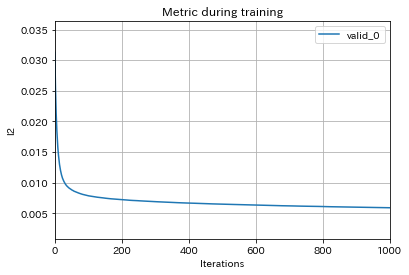

In [121]:
lgb.plot_metric(LGBM)

In [137]:
lgb.plot_metric?

In [122]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [123]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.8739147649770527
valid: 0.7004013729699259
test: 0.7052765007636603


In [124]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 8.14500808672005
valid: 17.89320763277798
test: 18.20032752989384


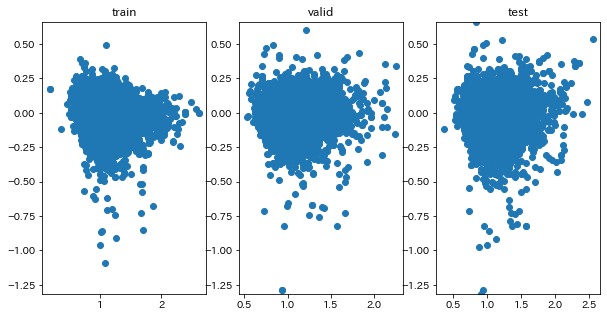

In [125]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [126]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[LGBM.feature_name_, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances[-50:]

feature  importance
250         is自走式駐車場    1.254079
251         is浴室1坪以上    2.747824
252       is内装コンクリート    0.394615
253      is内装リフォーム後渡    1.034781
254          is備付食器棚    1.311931
255        is両面バルコニー    0.288519
256         isリバーサイド    0.443477
257  isフローリング風フロアタイル    0.915870
258         isゲストルーム    0.808617
259            is車寄せ    3.462650
260       isL字型バルコニー    0.444291
261          is駐車2台可    0.786539
262       is耐震ラッチ吊戸棚    0.000000
263         isエアコン4台   19.276629
264          is階段下収納    0.113819
265          is高気密住宅   10.880674
266         isミストサウナ    1.246974
267              is庭    1.861873
268   isウォークインクロゼット2    2.512320
269          is2×4工法    0.923215
270            is吹抜け    1.215785
271     is初期費用10万円以下    0.300339
272         isバリアフリー    1.226445
273        is電動シャッター    0.059049
274        isフラットフロア    0.087709
275       isリビングの隣和室    0.222655
276          is二重床構造    0.092565
277           is南面3室    0.356188
278            is集会所    0.217550
279           is文教地区    6.574225
280      is天井高2.5m以上    1.021809
281       isLDK25畳以上  275.964555
282          is高温差湯式    0.286186
283          is高台に立地    0.357799
284       isキッチン5畳以上    0.000000
285     isクリーニングボックス    0.232566
286          is2階LDK    0.467266
287        isII型キッチン    0.819814
288        isドアタッチキー    0.017661
289       is100円バス路線    0.575720
290         isキッズルーム    0.914935
291           isAED付    1.436280
292         is2階リビング    0.788586
293        isオーブンレンジ   15.603807
294          is壁紙張替済    0.034049
295      isビルトインエアコン   11.898384
296         is路面電車沿線    0.961698
297         is駐車5台以上    2.956286
298       isフローリング張替    0.020912
299             is屋上    3.376835

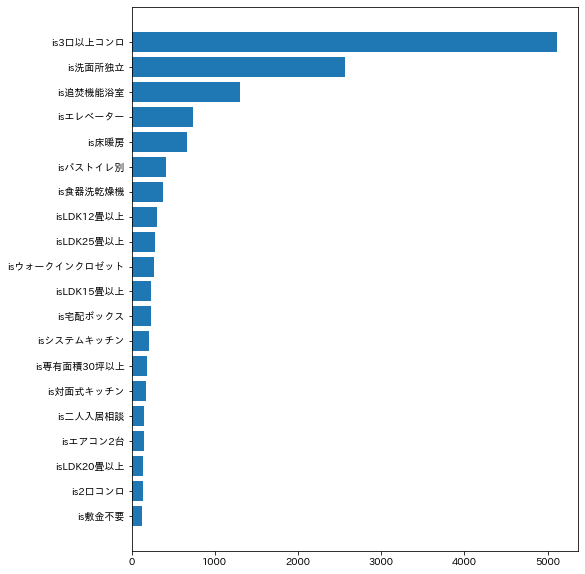

In [127]:
# 変数重要度
i = 20
plt.figure(figsize=(8,10))
table = table_importances.sort_values('importance',ascending=False)[::-1]
plt.barh(table['feature'][-i:],table['importance'][-i:])
plt.savefig("./data/image/elite_feature_importances.png")
plt.show()

In [128]:
table[-50:]

feature   importance
6          isバルコニー    42.259142
1          is室内洗濯置    42.393137
67         is駅まで平坦    43.493580
15         is保証人不要    44.081060
158      isシューズWIC    47.792148
11           is駐輪場    47.943777
196       isエアコン3台    48.149279
141        is事務所相談    49.221226
123           is振分    50.853145
39         is保証金不要    51.338745
0           isエアコン    51.985143
56     is24時間ゴミ出し可    52.778564
4           is都市ガス    54.474892
30      is3沿線以上利用可    57.348610
29         is防犯カメラ    58.040182
236          is乾燥機    60.635722
225     isLDK18畳以上    61.030615
62         isペット相談    62.402925
68          is分譲賃貸    62.491825
136       isプロパンガス    64.782098
177        is敷金2ヶ月    67.972783
10        isオートロック    77.242552
55       is敷金・礼金不要    77.817229
188     isフロントサービス    81.432918
183        isメゾネット    97.877615
65      isシャワー付洗面台    99.582487
217       isトイレ2ヶ所   106.955123
38          is礼金不要   112.477115
172    isタワー型マンション   124.085728
138         is楽器相談   129.259857
49          is敷金不要   130.513265
22         is2口コンロ   132.954267
244     isLDK20畳以上   140.699780
107       isエアコン2台   146.085562
64        is二人入居相談   151.140571
91       is対面式キッチン   171.892361
241    is専有面積30坪以上   187.434545
9       isシステムキッチン   203.920562
20        is宅配ボックス   230.081192
175     isLDK15畳以上   232.378762
83   isウォークインクロゼット   273.268193
281     isLDK25畳以上   275.964555
116     isLDK12畳以上   300.666661
180       is食器洗乾燥機   382.024634
2         isバストイレ別   415.708044
130          is床暖房   662.964513
21        isエレベーター   741.315899
41        is追焚機能浴室  1307.189274
14         is洗面所独立  2563.597804
74       is3口以上コンロ  5110.725862

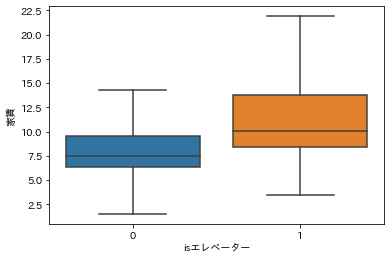

In [104]:
# あるないで違いを見てみよう
i = 21
suumo_option = copy.copy(suumo)
feature = table_isoption.columns[i]
suumo_option[feature] = table_isoption[feature]
sns.boxplot(data=suumo_option,x=feature,y='家賃', sym='')
# plt.savefig('./data/image/boxplot_sihatueki_sym.png')
plt.show()

In [100]:
# 平均値の違いは？
feature = table_isoption.columns[i]
condition = suumo_option[feature] == 0
print(suumo_option.loc[condition,'家賃'].mean())
print(suumo_option.loc[~condition,'家賃'].mean())

9.349838610539432
19.491964455351535


# Embeddingで変換すると？

In [5]:
# 準備フェイズ


# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
]
category_features = [
    '市区町村',
    '路線',
    '駅',
    '間取り',
#    '向き', # 1
    '建物種別', # 10
    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]


In [6]:
# 家賃を対数変換
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [7]:
# # 標準化
# ss = StandardScaler()
# suumo_light_ss = copy(suumo_light)
# suumo_light_ss[quantity_features] = ss.fit_transform(suumo_light[quantity_features])

In [8]:
# カテゴリ変数をEmbeddingしたい
# ラベルエンコード

LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")

In [9]:
# Embedding層の適用
category_features_embedding = []
for feature in category_features:
    input_dim = suumo_light[feature].shape[0]
    output_dim = 2

    exec(f"Embedding_{feature} = Sequential([Input(shape=(1,)),Embedding(input_dim=input_dim, output_dim=output_dim),Flatten()])")
    exec(f"suumo_light[['{feature}_0','{feature}_1']] = Embedding_{feature}(suumo_light[feature].values)")
    suumo_light.drop(feature, axis=1, inplace=True)
    category_features_embedding.append(f"{feature}_0")
    category_features_embedding.append(f"{feature}_1")
    
features = np.r_[quantity_features,category_features_embedding,is_features]

In [13]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [22]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

[1]	valid_0's l2: 0.0299565
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0254384
[3]	valid_0's l2: 0.021722
[4]	valid_0's l2: 0.0186886
[5]	valid_0's l2: 0.0161803
[6]	valid_0's l2: 0.0140895
[7]	valid_0's l2: 0.0123528
[8]	valid_0's l2: 0.0108991
[9]	valid_0's l2: 0.00968573
[10]	valid_0's l2: 0.00865808
[11]	valid_0's l2: 0.00781835
[12]	valid_0's l2: 0.00708572
[13]	valid_0's l2: 0.00647546
[14]	valid_0's l2: 0.00594987
[15]	valid_0's l2: 0.00550797
[16]	valid_0's l2: 0.00513123
[17]	valid_0's l2: 0.00478983
[18]	valid_0's l2: 0.00450954
[19]	valid_0's l2: 0.00426288
[20]	valid_0's l2: 0.00404638
[21]	valid_0's l2: 0.00386178
[22]	valid_0's l2: 0.00368864
[23]	valid_0's l2: 0.00354736
[24]	valid_0's l2: 0.0034292
[25]	valid_0's l2: 0.00330707
[26]	valid_0's l2: 0.00321123
[27]	valid_0's l2: 0.00311517
[28]	valid_0's l2: 0.00303183
[29]	valid_0's l2: 0.00296221
[30]	valid_0's l2: 0.00289956
[31]	valid_0's l2: 0.00283311
[32]	valid_0's l2: 0.0027741

[277]	valid_0's l2: 0.00163749
[278]	valid_0's l2: 0.00163625
[279]	valid_0's l2: 0.00163559
[280]	valid_0's l2: 0.00163445
[281]	valid_0's l2: 0.00163307
[282]	valid_0's l2: 0.00163277
[283]	valid_0's l2: 0.00163238
[284]	valid_0's l2: 0.00163203
[285]	valid_0's l2: 0.00163131
[286]	valid_0's l2: 0.00163073
[287]	valid_0's l2: 0.00162974
[288]	valid_0's l2: 0.00162937
[289]	valid_0's l2: 0.00162862
[290]	valid_0's l2: 0.00162596
[291]	valid_0's l2: 0.00162507
[292]	valid_0's l2: 0.00162409
[293]	valid_0's l2: 0.00162345
[294]	valid_0's l2: 0.001623
[295]	valid_0's l2: 0.00162184
[296]	valid_0's l2: 0.0016213
[297]	valid_0's l2: 0.00162047
[298]	valid_0's l2: 0.00161919
[299]	valid_0's l2: 0.00161823
[300]	valid_0's l2: 0.00161768
[301]	valid_0's l2: 0.00161643
[302]	valid_0's l2: 0.00161559
[303]	valid_0's l2: 0.00161455
[304]	valid_0's l2: 0.00161367
[305]	valid_0's l2: 0.0016126
[306]	valid_0's l2: 0.00161165
[307]	valid_0's l2: 0.00161091
[308]	valid_0's l2: 0.00161019
[309]	valid_

[572]	valid_0's l2: 0.00142834
[573]	valid_0's l2: 0.00142796
[574]	valid_0's l2: 0.00142759
[575]	valid_0's l2: 0.00142725
[576]	valid_0's l2: 0.00142677
[577]	valid_0's l2: 0.0014263
[578]	valid_0's l2: 0.00142545
[579]	valid_0's l2: 0.00142504
[580]	valid_0's l2: 0.00142439
[581]	valid_0's l2: 0.00142436
[582]	valid_0's l2: 0.00142405
[583]	valid_0's l2: 0.00142362
[584]	valid_0's l2: 0.00142342
[585]	valid_0's l2: 0.00142287
[586]	valid_0's l2: 0.00142239
[587]	valid_0's l2: 0.00142186
[588]	valid_0's l2: 0.00142171
[589]	valid_0's l2: 0.00142109
[590]	valid_0's l2: 0.00142049
[591]	valid_0's l2: 0.00142002
[592]	valid_0's l2: 0.00141982
[593]	valid_0's l2: 0.00141939
[594]	valid_0's l2: 0.00141851
[595]	valid_0's l2: 0.00141826
[596]	valid_0's l2: 0.00141781
[597]	valid_0's l2: 0.0014171
[598]	valid_0's l2: 0.00141654
[599]	valid_0's l2: 0.00141606
[600]	valid_0's l2: 0.00141567
[601]	valid_0's l2: 0.00141541
[602]	valid_0's l2: 0.00141487
[603]	valid_0's l2: 0.00141465
[604]	vali

[840]	valid_0's l2: 0.00131925
[841]	valid_0's l2: 0.00131859
[842]	valid_0's l2: 0.00131838
[843]	valid_0's l2: 0.00131793
[844]	valid_0's l2: 0.00131755
[845]	valid_0's l2: 0.0013174
[846]	valid_0's l2: 0.00131688
[847]	valid_0's l2: 0.0013163
[848]	valid_0's l2: 0.00131606
[849]	valid_0's l2: 0.00131593
[850]	valid_0's l2: 0.00131558
[851]	valid_0's l2: 0.00131546
[852]	valid_0's l2: 0.00131514
[853]	valid_0's l2: 0.00131493
[854]	valid_0's l2: 0.00131457
[855]	valid_0's l2: 0.00131425
[856]	valid_0's l2: 0.00131397
[857]	valid_0's l2: 0.00131364
[858]	valid_0's l2: 0.00131346
[859]	valid_0's l2: 0.0013125
[860]	valid_0's l2: 0.00131211
[861]	valid_0's l2: 0.00131186
[862]	valid_0's l2: 0.00131178
[863]	valid_0's l2: 0.00131149
[864]	valid_0's l2: 0.00131126
[865]	valid_0's l2: 0.00131104
[866]	valid_0's l2: 0.00131053
[867]	valid_0's l2: 0.00131027
[868]	valid_0's l2: 0.00130979
[869]	valid_0's l2: 0.00130924
[870]	valid_0's l2: 0.00130866
[871]	valid_0's l2: 0.0013083
[872]	valid_

[1105]	valid_0's l2: 0.00123742
[1106]	valid_0's l2: 0.00123714
[1107]	valid_0's l2: 0.0012369
[1108]	valid_0's l2: 0.00123676
[1109]	valid_0's l2: 0.00123665
[1110]	valid_0's l2: 0.00123647
[1111]	valid_0's l2: 0.00123612
[1112]	valid_0's l2: 0.00123592
[1113]	valid_0's l2: 0.00123575
[1114]	valid_0's l2: 0.00123517
[1115]	valid_0's l2: 0.00123502
[1116]	valid_0's l2: 0.00123482
[1117]	valid_0's l2: 0.00123455
[1118]	valid_0's l2: 0.00123444
[1119]	valid_0's l2: 0.00123413
[1120]	valid_0's l2: 0.00123369
[1121]	valid_0's l2: 0.00123349
[1122]	valid_0's l2: 0.0012332
[1123]	valid_0's l2: 0.00123285
[1124]	valid_0's l2: 0.00123251
[1125]	valid_0's l2: 0.00123251
[1126]	valid_0's l2: 0.00123233
[1127]	valid_0's l2: 0.00123196
[1128]	valid_0's l2: 0.00123156
[1129]	valid_0's l2: 0.00123131
[1130]	valid_0's l2: 0.00123097
[1131]	valid_0's l2: 0.00123064
[1132]	valid_0's l2: 0.00123052
[1133]	valid_0's l2: 0.00123043
[1134]	valid_0's l2: 0.00123023
[1135]	valid_0's l2: 0.00122993
[1136]	val

[1391]	valid_0's l2: 0.00117339
[1392]	valid_0's l2: 0.00117318
[1393]	valid_0's l2: 0.00117305
[1394]	valid_0's l2: 0.00117282
[1395]	valid_0's l2: 0.00117256
[1396]	valid_0's l2: 0.00117232
[1397]	valid_0's l2: 0.0011722
[1398]	valid_0's l2: 0.00117196
[1399]	valid_0's l2: 0.00117172
[1400]	valid_0's l2: 0.00117153
[1401]	valid_0's l2: 0.00117119
[1402]	valid_0's l2: 0.00117088
[1403]	valid_0's l2: 0.00117075
[1404]	valid_0's l2: 0.00117047
[1405]	valid_0's l2: 0.00117043
[1406]	valid_0's l2: 0.00117023
[1407]	valid_0's l2: 0.0011703
[1408]	valid_0's l2: 0.00117017
[1409]	valid_0's l2: 0.00117002
[1410]	valid_0's l2: 0.00116984
[1411]	valid_0's l2: 0.0011695
[1412]	valid_0's l2: 0.00116928
[1413]	valid_0's l2: 0.00116915
[1414]	valid_0's l2: 0.00116952
[1415]	valid_0's l2: 0.00116924
[1416]	valid_0's l2: 0.00116906
[1417]	valid_0's l2: 0.00116895
[1418]	valid_0's l2: 0.00116881
[1419]	valid_0's l2: 0.00116866
[1420]	valid_0's l2: 0.00116849
[1421]	valid_0's l2: 0.00116817
[1422]	vali

[1673]	valid_0's l2: 0.00111966
[1674]	valid_0's l2: 0.00111944
[1675]	valid_0's l2: 0.00111926
[1676]	valid_0's l2: 0.00111918
[1677]	valid_0's l2: 0.00111898
[1678]	valid_0's l2: 0.00111878
[1679]	valid_0's l2: 0.00111868
[1680]	valid_0's l2: 0.00111845
[1681]	valid_0's l2: 0.00111833
[1682]	valid_0's l2: 0.00111821
[1683]	valid_0's l2: 0.00111813
[1684]	valid_0's l2: 0.00111806
[1685]	valid_0's l2: 0.00111782
[1686]	valid_0's l2: 0.0011177
[1687]	valid_0's l2: 0.00111754
[1688]	valid_0's l2: 0.00111746
[1689]	valid_0's l2: 0.00111716
[1690]	valid_0's l2: 0.00111711
[1691]	valid_0's l2: 0.00111687
[1692]	valid_0's l2: 0.00111669
[1693]	valid_0's l2: 0.00111662
[1694]	valid_0's l2: 0.00111622
[1695]	valid_0's l2: 0.00111596
[1696]	valid_0's l2: 0.00111562
[1697]	valid_0's l2: 0.00111546
[1698]	valid_0's l2: 0.00111538
[1699]	valid_0's l2: 0.00111539
[1700]	valid_0's l2: 0.00111525
[1701]	valid_0's l2: 0.00111501
[1702]	valid_0's l2: 0.0011148
[1703]	valid_0's l2: 0.00111465
[1704]	val

[1961]	valid_0's l2: 0.00107957
[1962]	valid_0's l2: 0.00107928
[1963]	valid_0's l2: 0.00107942
[1964]	valid_0's l2: 0.0010793
[1965]	valid_0's l2: 0.0010791
[1966]	valid_0's l2: 0.00107899
[1967]	valid_0's l2: 0.00107892
[1968]	valid_0's l2: 0.00107882
[1969]	valid_0's l2: 0.00107864
[1970]	valid_0's l2: 0.00107854
[1971]	valid_0's l2: 0.00107842
[1972]	valid_0's l2: 0.00107831
[1973]	valid_0's l2: 0.00107818
[1974]	valid_0's l2: 0.00107806
[1975]	valid_0's l2: 0.00107795
[1976]	valid_0's l2: 0.00107789
[1977]	valid_0's l2: 0.00107772
[1978]	valid_0's l2: 0.00107762
[1979]	valid_0's l2: 0.00107747
[1980]	valid_0's l2: 0.00107731
[1981]	valid_0's l2: 0.00107718
[1982]	valid_0's l2: 0.00107706
[1983]	valid_0's l2: 0.00107684
[1984]	valid_0's l2: 0.00107679
[1985]	valid_0's l2: 0.00107662
[1986]	valid_0's l2: 0.00107644
[1987]	valid_0's l2: 0.00107627
[1988]	valid_0's l2: 0.00107614
[1989]	valid_0's l2: 0.00107599
[1990]	valid_0's l2: 0.001076
[1991]	valid_0's l2: 0.00107585
[1992]	valid

[2223]	valid_0's l2: 0.00105155
[2224]	valid_0's l2: 0.00105152
[2225]	valid_0's l2: 0.00105144
[2226]	valid_0's l2: 0.00105127
[2227]	valid_0's l2: 0.00105117
[2228]	valid_0's l2: 0.00105103
[2229]	valid_0's l2: 0.00105087
[2230]	valid_0's l2: 0.00105076
[2231]	valid_0's l2: 0.00105059
[2232]	valid_0's l2: 0.00105047
[2233]	valid_0's l2: 0.00105033
[2234]	valid_0's l2: 0.00105024
[2235]	valid_0's l2: 0.00105009
[2236]	valid_0's l2: 0.00104987
[2237]	valid_0's l2: 0.00104977
[2238]	valid_0's l2: 0.00104957
[2239]	valid_0's l2: 0.00104952
[2240]	valid_0's l2: 0.00104949
[2241]	valid_0's l2: 0.00104948
[2242]	valid_0's l2: 0.00104931
[2243]	valid_0's l2: 0.00104918
[2244]	valid_0's l2: 0.00104903
[2245]	valid_0's l2: 0.00104895
[2246]	valid_0's l2: 0.00104882
[2247]	valid_0's l2: 0.00104871
[2248]	valid_0's l2: 0.00104851
[2249]	valid_0's l2: 0.00104828
[2250]	valid_0's l2: 0.00104804
[2251]	valid_0's l2: 0.00104792
[2252]	valid_0's l2: 0.00104785
[2253]	valid_0's l2: 0.00104777
[2254]	v

[2499]	valid_0's l2: 0.0010224
[2500]	valid_0's l2: 0.00102238
[2501]	valid_0's l2: 0.00102227
[2502]	valid_0's l2: 0.00102212
[2503]	valid_0's l2: 0.00102192
[2504]	valid_0's l2: 0.00102185
[2505]	valid_0's l2: 0.00102176
[2506]	valid_0's l2: 0.00102173
[2507]	valid_0's l2: 0.00102155
[2508]	valid_0's l2: 0.00102145
[2509]	valid_0's l2: 0.00102127
[2510]	valid_0's l2: 0.00102112
[2511]	valid_0's l2: 0.00102101
[2512]	valid_0's l2: 0.00102086
[2513]	valid_0's l2: 0.00102069
[2514]	valid_0's l2: 0.00102061
[2515]	valid_0's l2: 0.00102061
[2516]	valid_0's l2: 0.00102052
[2517]	valid_0's l2: 0.00102037
[2518]	valid_0's l2: 0.00102027
[2519]	valid_0's l2: 0.00102023
[2520]	valid_0's l2: 0.00102014
[2521]	valid_0's l2: 0.00102002
[2522]	valid_0's l2: 0.00101988
[2523]	valid_0's l2: 0.00101974
[2524]	valid_0's l2: 0.00102003
[2525]	valid_0's l2: 0.00101992
[2526]	valid_0's l2: 0.00102007
[2527]	valid_0's l2: 0.00101996
[2528]	valid_0's l2: 0.00101982
[2529]	valid_0's l2: 0.00101952
[2530]	va

LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

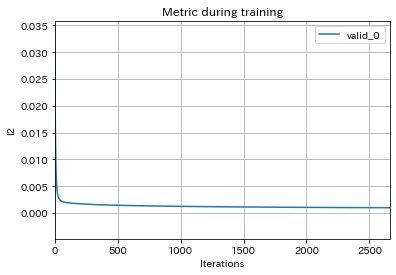

In [23]:
lgb.plot_metric(LGBM)

In [24]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [25]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9869124084338854
valid: 0.9622481576274285
test: 0.960487812122694


In [26]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 0.7927162419058691
valid: 2.4277797865720685
test: 2.6525049203251325


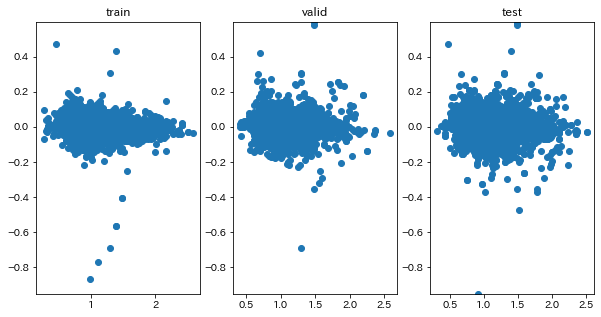

In [27]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [29]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature    importance
0    皇居からの距離   1960.088555
1   最寄駅からの距離    122.586017
2         面積  13720.524703
3        築年数   1680.627938
4         地上    310.588801
5          階    116.451155
6     市区町村_0    828.057354
7     市区町村_1    280.845060
8       路線_0     95.314435
9       路線_1    116.250288
10       駅_0     78.397258
11       駅_1     80.927596
12     間取り_0     54.922180
13     間取り_1    107.636990
14    建物種別_0     38.981610
15    建物種別_1      7.871564
16      構造_0     15.049299
17      構造_1    424.267552

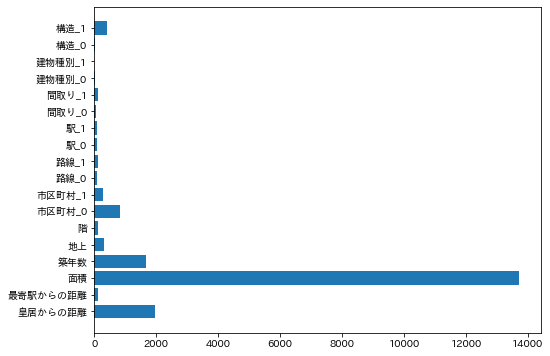

In [30]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig("./data/image/elite_feature_importances.png")
plt.show()

# 市区町村情報を地価に変換してみる

結論：予測は大して変わってないよ（実質市区町村だから）

In [55]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
    '地価',
]
category_features = [
#    '市区町村',
#    '路線',
#    '駅',
    '間取り',
#    '向き', # 1
#    '建物種別', # 10
    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]



In [56]:
# 地価変数を導入するゾ
land_price = pd.read_csv('./data/csv/land_price.csv').drop('Unnamed: 0',axis=1)

suumo_light = pd.merge(suumo_light, land_price, left_on='市区町村', right_on='区', how='left')
suumo_light.drop(['市区町村','区'],axis=1,inplace=True)

In [57]:
# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [59]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [60]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [61]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0299088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0253239
[3]	valid_0's l2: 0.0215936
[4]	valid_0's l2: 0.0185099
[5]	valid_0's l2: 0.0159671
[6]	valid_0's l2: 0.01389
[7]	valid_0's l2: 0.0120971
[8]	valid_0's l2: 0.0106029
[9]	valid_0's l2: 0.00936121
[10]	valid_0's l2: 0.00834468
[11]	valid_0's l2: 0.00748924
[12]	valid_0's l2: 0.0067709
[13]	valid_0's l2: 0.00617366
[14]	valid_0's l2: 0.00566293
[15]	valid_0's l2: 0.00524169
[16]	valid_0's l2: 0.00488297
[17]	valid_0's l2: 0.00457283
[18]	valid_0's l2: 0.00431063
[19]	valid_0's l2: 0.00408966
[20]	valid_0's l2: 0.00389963
[21]	valid_0's l2: 0.00373195
[22]	valid_0's l2: 0.00359306
[23]	valid_0's l2: 0.00347098
[24]	valid_0's l2: 0.00336626
[25]	valid_0's l2: 0.00326033
[26]	valid_0's l2: 0.00317974
[27]	valid_0's l2: 0.00310021
[28]	valid_0's l2: 0.00303266
[29]	valid_0's l2: 0.002978
[30]	valid_0's l2: 0.0029211
[31]	valid_0's l2: 0.0028749
[32]	valid_0's l2: 0.00282924
[33

[304]	valid_0's l2: 0.00169696
[305]	valid_0's l2: 0.00169629
[306]	valid_0's l2: 0.00169585
[307]	valid_0's l2: 0.00169456
[308]	valid_0's l2: 0.00169397
[309]	valid_0's l2: 0.00169258
[310]	valid_0's l2: 0.00169148
[311]	valid_0's l2: 0.00169052
[312]	valid_0's l2: 0.00168945
[313]	valid_0's l2: 0.00168883
[314]	valid_0's l2: 0.00168832
[315]	valid_0's l2: 0.00168695
[316]	valid_0's l2: 0.00168567
[317]	valid_0's l2: 0.00168493
[318]	valid_0's l2: 0.00168443
[319]	valid_0's l2: 0.00168368
[320]	valid_0's l2: 0.00168272
[321]	valid_0's l2: 0.00168185
[322]	valid_0's l2: 0.00168083
[323]	valid_0's l2: 0.00168016
[324]	valid_0's l2: 0.00167966
[325]	valid_0's l2: 0.00167865
[326]	valid_0's l2: 0.00167783
[327]	valid_0's l2: 0.0016769
[328]	valid_0's l2: 0.00167693
[329]	valid_0's l2: 0.00167559
[330]	valid_0's l2: 0.00167392
[331]	valid_0's l2: 0.00167314
[332]	valid_0's l2: 0.00167263
[333]	valid_0's l2: 0.00167207
[334]	valid_0's l2: 0.00167087
[335]	valid_0's l2: 0.00167013
[336]	val

[592]	valid_0's l2: 0.00150135
[593]	valid_0's l2: 0.00150085
[594]	valid_0's l2: 0.00149976
[595]	valid_0's l2: 0.00149902
[596]	valid_0's l2: 0.00149832
[597]	valid_0's l2: 0.00149774
[598]	valid_0's l2: 0.0014973
[599]	valid_0's l2: 0.00149681
[600]	valid_0's l2: 0.00149648
[601]	valid_0's l2: 0.00149606
[602]	valid_0's l2: 0.00149546
[603]	valid_0's l2: 0.0014949
[604]	valid_0's l2: 0.00149437
[605]	valid_0's l2: 0.00149389
[606]	valid_0's l2: 0.00149296
[607]	valid_0's l2: 0.00149285
[608]	valid_0's l2: 0.00149266
[609]	valid_0's l2: 0.00149239
[610]	valid_0's l2: 0.00149167
[611]	valid_0's l2: 0.00149118
[612]	valid_0's l2: 0.00149023
[613]	valid_0's l2: 0.00148971
[614]	valid_0's l2: 0.00148928
[615]	valid_0's l2: 0.00148908
[616]	valid_0's l2: 0.00148877
[617]	valid_0's l2: 0.00148819
[618]	valid_0's l2: 0.00148756
[619]	valid_0's l2: 0.00148727
[620]	valid_0's l2: 0.00148674
[621]	valid_0's l2: 0.00148641
[622]	valid_0's l2: 0.00148607
[623]	valid_0's l2: 0.00148569
[624]	vali

[862]	valid_0's l2: 0.00138041
[863]	valid_0's l2: 0.00137985
[864]	valid_0's l2: 0.00137945
[865]	valid_0's l2: 0.00137909
[866]	valid_0's l2: 0.00137858
[867]	valid_0's l2: 0.00137784
[868]	valid_0's l2: 0.00137751
[869]	valid_0's l2: 0.00137715
[870]	valid_0's l2: 0.00137678
[871]	valid_0's l2: 0.00137658
[872]	valid_0's l2: 0.00137629
[873]	valid_0's l2: 0.00137571
[874]	valid_0's l2: 0.00137563
[875]	valid_0's l2: 0.00137499
[876]	valid_0's l2: 0.00137474
[877]	valid_0's l2: 0.00137433
[878]	valid_0's l2: 0.00137411
[879]	valid_0's l2: 0.00137384
[880]	valid_0's l2: 0.00137328
[881]	valid_0's l2: 0.0013729
[882]	valid_0's l2: 0.00137273
[883]	valid_0's l2: 0.00137237
[884]	valid_0's l2: 0.00137192
[885]	valid_0's l2: 0.00137169
[886]	valid_0's l2: 0.00137149
[887]	valid_0's l2: 0.00137117
[888]	valid_0's l2: 0.00137109
[889]	valid_0's l2: 0.00137084
[890]	valid_0's l2: 0.00137031
[891]	valid_0's l2: 0.00136998
[892]	valid_0's l2: 0.00136954
[893]	valid_0's l2: 0.00136939
[894]	val

[1142]	valid_0's l2: 0.00129102
[1143]	valid_0's l2: 0.00129061
[1144]	valid_0's l2: 0.00129031
[1145]	valid_0's l2: 0.00129014
[1146]	valid_0's l2: 0.00128985
[1147]	valid_0's l2: 0.00128972
[1148]	valid_0's l2: 0.00128951
[1149]	valid_0's l2: 0.0012893
[1150]	valid_0's l2: 0.00128908
[1151]	valid_0's l2: 0.00128888
[1152]	valid_0's l2: 0.00128849
[1153]	valid_0's l2: 0.00128846
[1154]	valid_0's l2: 0.00128828
[1155]	valid_0's l2: 0.00128812
[1156]	valid_0's l2: 0.00128769
[1157]	valid_0's l2: 0.00128724
[1158]	valid_0's l2: 0.00128702
[1159]	valid_0's l2: 0.00128688
[1160]	valid_0's l2: 0.00128658
[1161]	valid_0's l2: 0.00128638
[1162]	valid_0's l2: 0.00128622
[1163]	valid_0's l2: 0.00128609
[1164]	valid_0's l2: 0.00128598
[1165]	valid_0's l2: 0.00128571
[1166]	valid_0's l2: 0.00128546
[1167]	valid_0's l2: 0.00128527
[1168]	valid_0's l2: 0.00128484
[1169]	valid_0's l2: 0.00128428
[1170]	valid_0's l2: 0.00128418
[1171]	valid_0's l2: 0.00128362
[1172]	valid_0's l2: 0.00128332
[1173]	va

[1426]	valid_0's l2: 0.00122482
[1427]	valid_0's l2: 0.00122445
[1428]	valid_0's l2: 0.00122419
[1429]	valid_0's l2: 0.00122411
[1430]	valid_0's l2: 0.00122383
[1431]	valid_0's l2: 0.00122374
[1432]	valid_0's l2: 0.00122335
[1433]	valid_0's l2: 0.00122335
[1434]	valid_0's l2: 0.00122316
[1435]	valid_0's l2: 0.00122301
[1436]	valid_0's l2: 0.00122269
[1437]	valid_0's l2: 0.00122246
[1438]	valid_0's l2: 0.00122215
[1439]	valid_0's l2: 0.001222
[1440]	valid_0's l2: 0.00122196
[1441]	valid_0's l2: 0.0012219
[1442]	valid_0's l2: 0.00122173
[1443]	valid_0's l2: 0.00122116
[1444]	valid_0's l2: 0.00122093
[1445]	valid_0's l2: 0.00122084
[1446]	valid_0's l2: 0.00122072
[1447]	valid_0's l2: 0.00122066
[1448]	valid_0's l2: 0.00122062
[1449]	valid_0's l2: 0.00122038
[1450]	valid_0's l2: 0.0012202
[1451]	valid_0's l2: 0.00121997
[1452]	valid_0's l2: 0.00121952
[1453]	valid_0's l2: 0.00121922
[1454]	valid_0's l2: 0.00121904
[1455]	valid_0's l2: 0.00121919
[1456]	valid_0's l2: 0.00121906
[1457]	valid

[1694]	valid_0's l2: 0.00117582
[1695]	valid_0's l2: 0.00117557
[1696]	valid_0's l2: 0.00117541
[1697]	valid_0's l2: 0.00117505
[1698]	valid_0's l2: 0.00117491
[1699]	valid_0's l2: 0.00117455
[1700]	valid_0's l2: 0.00117473
[1701]	valid_0's l2: 0.00117467
[1702]	valid_0's l2: 0.00117444
[1703]	valid_0's l2: 0.00117438
[1704]	valid_0's l2: 0.00117414
[1705]	valid_0's l2: 0.00117389
[1706]	valid_0's l2: 0.00117364
[1707]	valid_0's l2: 0.00117341
[1708]	valid_0's l2: 0.00117319
[1709]	valid_0's l2: 0.00117307
[1710]	valid_0's l2: 0.00117289
[1711]	valid_0's l2: 0.00117269
[1712]	valid_0's l2: 0.00117217
[1713]	valid_0's l2: 0.00117201
[1714]	valid_0's l2: 0.00117187
[1715]	valid_0's l2: 0.00117181
[1716]	valid_0's l2: 0.00117178
[1717]	valid_0's l2: 0.00117149
[1718]	valid_0's l2: 0.0011713
[1719]	valid_0's l2: 0.00117119
[1720]	valid_0's l2: 0.00117103
[1721]	valid_0's l2: 0.00117082
[1722]	valid_0's l2: 0.00117073
[1723]	valid_0's l2: 0.00117057
[1724]	valid_0's l2: 0.00117051
[1725]	va

[1981]	valid_0's l2: 0.00112925
[1982]	valid_0's l2: 0.00112909
[1983]	valid_0's l2: 0.00112883
[1984]	valid_0's l2: 0.00112879
[1985]	valid_0's l2: 0.00112879
[1986]	valid_0's l2: 0.00112854
[1987]	valid_0's l2: 0.00112823
[1988]	valid_0's l2: 0.00112813
[1989]	valid_0's l2: 0.00112807
[1990]	valid_0's l2: 0.00112797
[1991]	valid_0's l2: 0.00112761
[1992]	valid_0's l2: 0.00112752
[1993]	valid_0's l2: 0.00112725
[1994]	valid_0's l2: 0.00112701
[1995]	valid_0's l2: 0.00112677
[1996]	valid_0's l2: 0.00112658
[1997]	valid_0's l2: 0.00112641
[1998]	valid_0's l2: 0.00112619
[1999]	valid_0's l2: 0.00112587
[2000]	valid_0's l2: 0.0011257
[2001]	valid_0's l2: 0.00112551
[2002]	valid_0's l2: 0.00112542
[2003]	valid_0's l2: 0.0011253
[2004]	valid_0's l2: 0.00112513
[2005]	valid_0's l2: 0.00112511
[2006]	valid_0's l2: 0.00112501
[2007]	valid_0's l2: 0.00112481
[2008]	valid_0's l2: 0.00112463
[2009]	valid_0's l2: 0.0011244
[2010]	valid_0's l2: 0.00112427
[2011]	valid_0's l2: 0.00112423
[2012]	vali

[2279]	valid_0's l2: 0.00109265
[2280]	valid_0's l2: 0.00109255
[2281]	valid_0's l2: 0.00109249
[2282]	valid_0's l2: 0.00109243
[2283]	valid_0's l2: 0.00109234
[2284]	valid_0's l2: 0.00109227
[2285]	valid_0's l2: 0.00109213
[2286]	valid_0's l2: 0.00109196
[2287]	valid_0's l2: 0.00109178
[2288]	valid_0's l2: 0.0010917
[2289]	valid_0's l2: 0.00109157
[2290]	valid_0's l2: 0.00109142
[2291]	valid_0's l2: 0.00109142
[2292]	valid_0's l2: 0.00109127
[2293]	valid_0's l2: 0.00109123
[2294]	valid_0's l2: 0.00109105
[2295]	valid_0's l2: 0.00109089
[2296]	valid_0's l2: 0.00109083
[2297]	valid_0's l2: 0.00109063
[2298]	valid_0's l2: 0.00109043
[2299]	valid_0's l2: 0.00109037
[2300]	valid_0's l2: 0.00109029
[2301]	valid_0's l2: 0.00109012
[2302]	valid_0's l2: 0.00109003
[2303]	valid_0's l2: 0.00108994
[2304]	valid_0's l2: 0.00108979
[2305]	valid_0's l2: 0.00108972
[2306]	valid_0's l2: 0.00108954
[2307]	valid_0's l2: 0.00108948
[2308]	valid_0's l2: 0.00108945
[2309]	valid_0's l2: 0.00108937
[2310]	va

[2560]	valid_0's l2: 0.00106452
[2561]	valid_0's l2: 0.00106435
[2562]	valid_0's l2: 0.00106413
[2563]	valid_0's l2: 0.00106437
[2564]	valid_0's l2: 0.00106426
[2565]	valid_0's l2: 0.00106413
[2566]	valid_0's l2: 0.0010641
[2567]	valid_0's l2: 0.0010639
[2568]	valid_0's l2: 0.00106393
[2569]	valid_0's l2: 0.00106389
[2570]	valid_0's l2: 0.00106388
[2571]	valid_0's l2: 0.00106371
[2572]	valid_0's l2: 0.0010636
[2573]	valid_0's l2: 0.00106353
[2574]	valid_0's l2: 0.00106338
[2575]	valid_0's l2: 0.00106338
[2576]	valid_0's l2: 0.00106334
[2577]	valid_0's l2: 0.00106333
[2578]	valid_0's l2: 0.00106329
[2579]	valid_0's l2: 0.00106315
[2580]	valid_0's l2: 0.00106298
[2581]	valid_0's l2: 0.0010629
[2582]	valid_0's l2: 0.00106286
[2583]	valid_0's l2: 0.00106267
[2584]	valid_0's l2: 0.00106257
[2585]	valid_0's l2: 0.00106247
[2586]	valid_0's l2: 0.00106243
[2587]	valid_0's l2: 0.00106235
[2588]	valid_0's l2: 0.00106236
[2589]	valid_0's l2: 0.00106223
[2590]	valid_0's l2: 0.00106215
[2591]	valid

[2853]	valid_0's l2: 0.00103615
[2854]	valid_0's l2: 0.00103606
[2855]	valid_0's l2: 0.00103612
[2856]	valid_0's l2: 0.00103626
[2857]	valid_0's l2: 0.00103627
[2858]	valid_0's l2: 0.0010362
[2859]	valid_0's l2: 0.00103601
[2860]	valid_0's l2: 0.00103606
[2861]	valid_0's l2: 0.00103601
[2862]	valid_0's l2: 0.00103597
[2863]	valid_0's l2: 0.00103586
[2864]	valid_0's l2: 0.00103576
[2865]	valid_0's l2: 0.00103567
[2866]	valid_0's l2: 0.00103562
[2867]	valid_0's l2: 0.00103543
[2868]	valid_0's l2: 0.00103542
[2869]	valid_0's l2: 0.00103535
[2870]	valid_0's l2: 0.00103517
[2871]	valid_0's l2: 0.00103507
[2872]	valid_0's l2: 0.00103496
[2873]	valid_0's l2: 0.00103487
[2874]	valid_0's l2: 0.00103471
[2875]	valid_0's l2: 0.00103454
[2876]	valid_0's l2: 0.00103445
[2877]	valid_0's l2: 0.00103436
[2878]	valid_0's l2: 0.00103403
[2879]	valid_0's l2: 0.00103397
[2880]	valid_0's l2: 0.00103393
[2881]	valid_0's l2: 0.00103377
[2882]	valid_0's l2: 0.00103365
[2883]	valid_0's l2: 0.00103349
[2884]	va

[3148]	valid_0's l2: 0.00101101
[3149]	valid_0's l2: 0.00101098
[3150]	valid_0's l2: 0.00101093
[3151]	valid_0's l2: 0.00101086
[3152]	valid_0's l2: 0.00101085
[3153]	valid_0's l2: 0.00101079
[3154]	valid_0's l2: 0.00101069
[3155]	valid_0's l2: 0.00101061
[3156]	valid_0's l2: 0.00101058
[3157]	valid_0's l2: 0.00101056
[3158]	valid_0's l2: 0.00101049
[3159]	valid_0's l2: 0.00101039
[3160]	valid_0's l2: 0.00101028
[3161]	valid_0's l2: 0.00101014
[3162]	valid_0's l2: 0.00101007
[3163]	valid_0's l2: 0.00101001
[3164]	valid_0's l2: 0.00100997
[3165]	valid_0's l2: 0.00100987
[3166]	valid_0's l2: 0.00100981
[3167]	valid_0's l2: 0.00100976
[3168]	valid_0's l2: 0.00100973
[3169]	valid_0's l2: 0.00100967
[3170]	valid_0's l2: 0.00100958
[3171]	valid_0's l2: 0.00100949
[3172]	valid_0's l2: 0.00100938
[3173]	valid_0's l2: 0.00100932
[3174]	valid_0's l2: 0.00100916
[3175]	valid_0's l2: 0.00100916
[3176]	valid_0's l2: 0.00100905
[3177]	valid_0's l2: 0.00100899
[3178]	valid_0's l2: 0.0010089
[3179]	va

[3450]	valid_0's l2: 0.000990145
[3451]	valid_0's l2: 0.00099006
[3452]	valid_0's l2: 0.000989965
[3453]	valid_0's l2: 0.000989895
[3454]	valid_0's l2: 0.000989807
[3455]	valid_0's l2: 0.000989705
[3456]	valid_0's l2: 0.000989583
[3457]	valid_0's l2: 0.000989537
[3458]	valid_0's l2: 0.000989501
[3459]	valid_0's l2: 0.000989514
[3460]	valid_0's l2: 0.000989415
[3461]	valid_0's l2: 0.000989387
[3462]	valid_0's l2: 0.00098942
[3463]	valid_0's l2: 0.000989316
[3464]	valid_0's l2: 0.000989272
[3465]	valid_0's l2: 0.000989136
[3466]	valid_0's l2: 0.000989051
[3467]	valid_0's l2: 0.000988883
[3468]	valid_0's l2: 0.000989022
[3469]	valid_0's l2: 0.000988955
[3470]	valid_0's l2: 0.000988883
[3471]	valid_0's l2: 0.000988683
[3472]	valid_0's l2: 0.000988584
[3473]	valid_0's l2: 0.000988451
[3474]	valid_0's l2: 0.000988378
[3475]	valid_0's l2: 0.000988317
[3476]	valid_0's l2: 0.000988223
[3477]	valid_0's l2: 0.000988112
[3478]	valid_0's l2: 0.000988068
[3479]	valid_0's l2: 0.00098796
[3480]	valid_

[3755]	valid_0's l2: 0.00097027
[3756]	valid_0's l2: 0.000970224
[3757]	valid_0's l2: 0.000970167
[3758]	valid_0's l2: 0.000970164
[3759]	valid_0's l2: 0.000970071
[3760]	valid_0's l2: 0.000969983
[3761]	valid_0's l2: 0.000969905
[3762]	valid_0's l2: 0.000969738
[3763]	valid_0's l2: 0.000969692
[3764]	valid_0's l2: 0.000969646
[3765]	valid_0's l2: 0.000969589
[3766]	valid_0's l2: 0.000969459
[3767]	valid_0's l2: 0.000969357
[3768]	valid_0's l2: 0.000969281
[3769]	valid_0's l2: 0.000969171
[3770]	valid_0's l2: 0.000969095
[3771]	valid_0's l2: 0.000968974
[3772]	valid_0's l2: 0.000969286
[3773]	valid_0's l2: 0.000969191
[3774]	valid_0's l2: 0.000969133
[3775]	valid_0's l2: 0.000969042
[3776]	valid_0's l2: 0.000968978
[3777]	valid_0's l2: 0.000968774
[3778]	valid_0's l2: 0.000968695
[3779]	valid_0's l2: 0.000968565
[3780]	valid_0's l2: 0.000968465
[3781]	valid_0's l2: 0.000968337
[3782]	valid_0's l2: 0.000968275
[3783]	valid_0's l2: 0.000968139
[3784]	valid_0's l2: 0.000968105
[3785]	vali

[4012]	valid_0's l2: 0.000955369
[4013]	valid_0's l2: 0.00095529
[4014]	valid_0's l2: 0.000955287
[4015]	valid_0's l2: 0.00095523
[4016]	valid_0's l2: 0.000955162
[4017]	valid_0's l2: 0.00095511
[4018]	valid_0's l2: 0.000955005
[4019]	valid_0's l2: 0.000954848
[4020]	valid_0's l2: 0.000954786
[4021]	valid_0's l2: 0.000954763
[4022]	valid_0's l2: 0.000954711
[4023]	valid_0's l2: 0.000954678
[4024]	valid_0's l2: 0.000954648
[4025]	valid_0's l2: 0.000954633
[4026]	valid_0's l2: 0.000954578
[4027]	valid_0's l2: 0.000954534
[4028]	valid_0's l2: 0.000954444
[4029]	valid_0's l2: 0.000954394
[4030]	valid_0's l2: 0.00095432
[4031]	valid_0's l2: 0.000954298
[4032]	valid_0's l2: 0.00095426
[4033]	valid_0's l2: 0.000954232
[4034]	valid_0's l2: 0.000954219
[4035]	valid_0's l2: 0.000954103
[4036]	valid_0's l2: 0.000954055
[4037]	valid_0's l2: 0.000953994
[4038]	valid_0's l2: 0.000953931
[4039]	valid_0's l2: 0.000953878
[4040]	valid_0's l2: 0.000953782
[4041]	valid_0's l2: 0.000953718
[4042]	valid_0'

LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

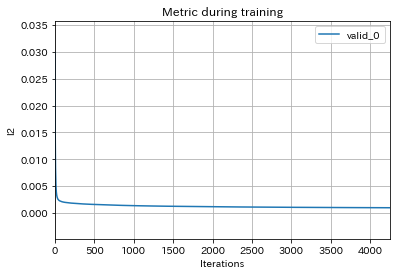

In [62]:
lgb.plot_metric(LGBM)

In [63]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [64]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9896220226962777
valid: 0.9726248335005736
test: 0.9618450042145995


In [65]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 0.6285947361079975
valid: 1.760467084637948
test: 2.561394837715067


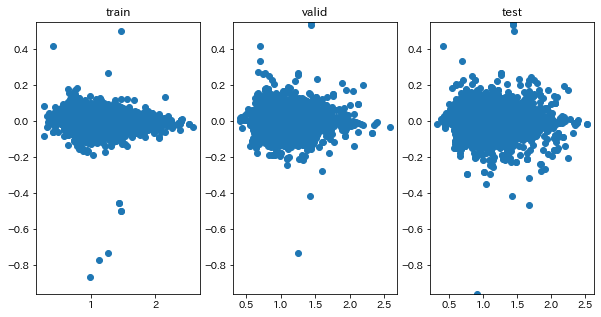

In [66]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [67]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature   importance
0   皇居からの距離   756.058010
1  最寄駅からの距離   201.231068
2        面積  7816.180695
3       築年数  1414.009630
4        地上   323.195400
5         階   131.516429
6        地価  2467.873209
7       間取り  6585.494608
8        構造   393.029611

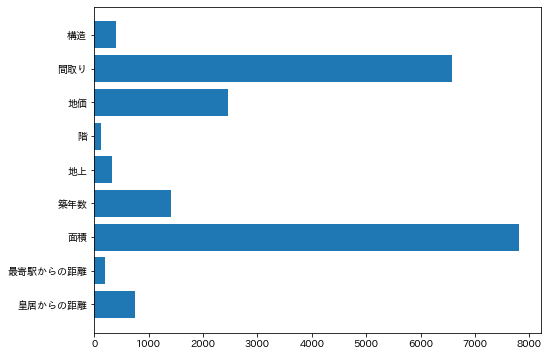

In [68]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig("./data/image/elite_feature_importances.png")
plt.show()

# 間取り情報を面積に変換（元の面積は削除）

結論：そこそこ精度が落ちる。面積って大事。

In [130]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
    '地価',
]
category_features = [
#    '市区町村',
#    '路線',
#    '駅',
#    '間取り',
#    '向き', # 1
#    '建物種別', # 10
    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]



In [87]:
# 地価変数を導入するゾ
land_price = pd.read_csv('./data/csv/land_price.csv').drop('Unnamed: 0',axis=1)

suumo_light = pd.merge(suumo_light, land_price, left_on='市区町村', right_on='区', how='left')
suumo_light.drop(['市区町村','区'],axis=1,inplace=True)

In [88]:
# 間取りごとの面積の平均
madori_area_mean = suumo_light.groupby('間取り', as_index=False).mean()[['間取り','面積']]
suumo_light.drop(['面積'],axis=1,inplace=True)
suumo_light = pd.merge(suumo_light, madori_area_mean, on='間取り', how='left')

In [90]:
# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [91]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [92]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [93]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\doubl\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's l2: 0.0303256
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0261582
[3]	valid_0's l2: 0.0227422
[4]	valid_0's l2: 0.0199324
[5]	valid_0's l2: 0.0176355
[6]	valid_0's l2: 0.0157148
[7]	valid_0's l2: 0.0141221
[8]	valid_0's l2: 0.0127982
[9]	valid_0's l2: 0.0116957
[10]	valid_0's l2: 0.0107623
[11]	valid_0's l2: 0.00998041
[12]	valid_0's l2: 0.00932149
[13]	valid_0's l2: 0.00873577
[14]	valid_0's l2: 0.00824267
[15]	valid_0's l2: 0.00783729
[16]	valid_0's l2: 0.00749343
[17]	valid_0's l2: 0.00720256
[18]	valid_0's l2: 0.00695203
[19]	valid_0's l2: 0.00672854
[20]	valid_0's l2: 0.00653376
[21]	valid_0's l2: 0.00637093
[22]	valid_0's l2: 0.00623597
[23]	valid_0's l2: 0.00610998
[24]	valid_0's l2: 0.00599603
[25]	valid_0's l2: 0.0059034
[26]	valid_0's l2: 0.00581223
[27]	valid_0's l2: 0.00573238
[28]	valid_0's l2: 0.00565758
[29]	valid_0's l2: 0.00557872
[30]	valid_0's l2: 0.00551652
[31]	valid_0's l2: 0.00546293
[32]	valid_0's l2: 0.00541378

[288]	valid_0's l2: 0.00380638
[289]	valid_0's l2: 0.00380426
[290]	valid_0's l2: 0.00380202
[291]	valid_0's l2: 0.00380034
[292]	valid_0's l2: 0.00379849
[293]	valid_0's l2: 0.00379687
[294]	valid_0's l2: 0.00379481
[295]	valid_0's l2: 0.00379325
[296]	valid_0's l2: 0.00379109
[297]	valid_0's l2: 0.00378722
[298]	valid_0's l2: 0.00378375
[299]	valid_0's l2: 0.00378169
[300]	valid_0's l2: 0.00378052
[301]	valid_0's l2: 0.00377811
[302]	valid_0's l2: 0.00377539
[303]	valid_0's l2: 0.0037736
[304]	valid_0's l2: 0.00377174
[305]	valid_0's l2: 0.00376947
[306]	valid_0's l2: 0.00376857
[307]	valid_0's l2: 0.00376602
[308]	valid_0's l2: 0.00376348
[309]	valid_0's l2: 0.00376233
[310]	valid_0's l2: 0.00375938
[311]	valid_0's l2: 0.00375846
[312]	valid_0's l2: 0.00375582
[313]	valid_0's l2: 0.00375429
[314]	valid_0's l2: 0.00375195
[315]	valid_0's l2: 0.00374865
[316]	valid_0's l2: 0.00374736
[317]	valid_0's l2: 0.00374594
[318]	valid_0's l2: 0.00374364
[319]	valid_0's l2: 0.00374184
[320]	val

[569]	valid_0's l2: 0.00340745
[570]	valid_0's l2: 0.00340695
[571]	valid_0's l2: 0.00340534
[572]	valid_0's l2: 0.00340351
[573]	valid_0's l2: 0.00340234
[574]	valid_0's l2: 0.00340138
[575]	valid_0's l2: 0.0034006
[576]	valid_0's l2: 0.00339911
[577]	valid_0's l2: 0.00339765
[578]	valid_0's l2: 0.00339625
[579]	valid_0's l2: 0.00339536
[580]	valid_0's l2: 0.0033945
[581]	valid_0's l2: 0.00339374
[582]	valid_0's l2: 0.00339222
[583]	valid_0's l2: 0.00339141
[584]	valid_0's l2: 0.00339055
[585]	valid_0's l2: 0.0033891
[586]	valid_0's l2: 0.00338825
[587]	valid_0's l2: 0.0033876
[588]	valid_0's l2: 0.00338677
[589]	valid_0's l2: 0.00338573
[590]	valid_0's l2: 0.00338524
[591]	valid_0's l2: 0.00338403
[592]	valid_0's l2: 0.00338291
[593]	valid_0's l2: 0.00338167
[594]	valid_0's l2: 0.00338022
[595]	valid_0's l2: 0.00337927
[596]	valid_0's l2: 0.00337871
[597]	valid_0's l2: 0.00337761
[598]	valid_0's l2: 0.00337702
[599]	valid_0's l2: 0.00337673
[600]	valid_0's l2: 0.00337578
[601]	valid_

[858]	valid_0's l2: 0.00315166
[859]	valid_0's l2: 0.0031511
[860]	valid_0's l2: 0.00315066
[861]	valid_0's l2: 0.00315057
[862]	valid_0's l2: 0.00314978
[863]	valid_0's l2: 0.0031485
[864]	valid_0's l2: 0.00314792
[865]	valid_0's l2: 0.00314705
[866]	valid_0's l2: 0.00314666
[867]	valid_0's l2: 0.00314566
[868]	valid_0's l2: 0.00314523
[869]	valid_0's l2: 0.00314479
[870]	valid_0's l2: 0.00314432
[871]	valid_0's l2: 0.00314404
[872]	valid_0's l2: 0.00314371
[873]	valid_0's l2: 0.00314296
[874]	valid_0's l2: 0.00314236
[875]	valid_0's l2: 0.00314157
[876]	valid_0's l2: 0.00314134
[877]	valid_0's l2: 0.00314113
[878]	valid_0's l2: 0.00314059
[879]	valid_0's l2: 0.00313965
[880]	valid_0's l2: 0.00313906
[881]	valid_0's l2: 0.00313824
[882]	valid_0's l2: 0.00313761
[883]	valid_0's l2: 0.00313706
[884]	valid_0's l2: 0.00313576
[885]	valid_0's l2: 0.00313496
[886]	valid_0's l2: 0.00313429
[887]	valid_0's l2: 0.00313355
[888]	valid_0's l2: 0.00313316
[889]	valid_0's l2: 0.0031327
[890]	valid

[1153]	valid_0's l2: 0.00295925
[1154]	valid_0's l2: 0.0029587
[1155]	valid_0's l2: 0.00295841
[1156]	valid_0's l2: 0.00295823
[1157]	valid_0's l2: 0.00295774
[1158]	valid_0's l2: 0.00295732
[1159]	valid_0's l2: 0.00295667
[1160]	valid_0's l2: 0.00295604
[1161]	valid_0's l2: 0.00295532
[1162]	valid_0's l2: 0.00295454
[1163]	valid_0's l2: 0.00295443
[1164]	valid_0's l2: 0.00295389
[1165]	valid_0's l2: 0.0029533
[1166]	valid_0's l2: 0.00295321
[1167]	valid_0's l2: 0.00295313
[1168]	valid_0's l2: 0.00295271
[1169]	valid_0's l2: 0.00295187
[1170]	valid_0's l2: 0.002951
[1171]	valid_0's l2: 0.00295051
[1172]	valid_0's l2: 0.00294999
[1173]	valid_0's l2: 0.00294944
[1174]	valid_0's l2: 0.0029496
[1175]	valid_0's l2: 0.00294919
[1176]	valid_0's l2: 0.0029484
[1177]	valid_0's l2: 0.00294824
[1178]	valid_0's l2: 0.0029471
[1179]	valid_0's l2: 0.00294617
[1180]	valid_0's l2: 0.00294567
[1181]	valid_0's l2: 0.00294524
[1182]	valid_0's l2: 0.00294443
[1183]	valid_0's l2: 0.0029443
[1184]	valid_0's

[1445]	valid_0's l2: 0.00282309
[1446]	valid_0's l2: 0.00282278
[1447]	valid_0's l2: 0.00282226
[1448]	valid_0's l2: 0.00282186
[1449]	valid_0's l2: 0.0028214
[1450]	valid_0's l2: 0.00282106
[1451]	valid_0's l2: 0.00282067
[1452]	valid_0's l2: 0.00282012
[1453]	valid_0's l2: 0.00281977
[1454]	valid_0's l2: 0.00281898
[1455]	valid_0's l2: 0.00281846
[1456]	valid_0's l2: 0.00281817
[1457]	valid_0's l2: 0.00281786
[1458]	valid_0's l2: 0.00281792
[1459]	valid_0's l2: 0.00281696
[1460]	valid_0's l2: 0.00281686
[1461]	valid_0's l2: 0.00281631
[1462]	valid_0's l2: 0.00281601
[1463]	valid_0's l2: 0.00281567
[1464]	valid_0's l2: 0.00281511
[1465]	valid_0's l2: 0.0028147
[1466]	valid_0's l2: 0.0028142
[1467]	valid_0's l2: 0.00281351
[1468]	valid_0's l2: 0.00281357
[1469]	valid_0's l2: 0.00281276
[1470]	valid_0's l2: 0.00281253
[1471]	valid_0's l2: 0.00281206
[1472]	valid_0's l2: 0.00281176
[1473]	valid_0's l2: 0.00281148
[1474]	valid_0's l2: 0.00281153
[1475]	valid_0's l2: 0.00281093
[1476]	vali

[1713]	valid_0's l2: 0.00272156
[1714]	valid_0's l2: 0.00272107
[1715]	valid_0's l2: 0.00272088
[1716]	valid_0's l2: 0.00272048
[1717]	valid_0's l2: 0.00272051
[1718]	valid_0's l2: 0.00272043
[1719]	valid_0's l2: 0.00272051
[1720]	valid_0's l2: 0.00271999
[1721]	valid_0's l2: 0.00271936
[1722]	valid_0's l2: 0.00271927
[1723]	valid_0's l2: 0.00271877
[1724]	valid_0's l2: 0.00271809
[1725]	valid_0's l2: 0.00271775
[1726]	valid_0's l2: 0.00271735
[1727]	valid_0's l2: 0.00271702
[1728]	valid_0's l2: 0.00271641
[1729]	valid_0's l2: 0.00271606
[1730]	valid_0's l2: 0.00271538
[1731]	valid_0's l2: 0.00271519
[1732]	valid_0's l2: 0.00271473
[1733]	valid_0's l2: 0.00271427
[1734]	valid_0's l2: 0.002714
[1735]	valid_0's l2: 0.00271375
[1736]	valid_0's l2: 0.00271366
[1737]	valid_0's l2: 0.00271326
[1738]	valid_0's l2: 0.00271289
[1739]	valid_0's l2: 0.00271271
[1740]	valid_0's l2: 0.00271261
[1741]	valid_0's l2: 0.00271258
[1742]	valid_0's l2: 0.00271217
[1743]	valid_0's l2: 0.00271205
[1744]	val

[1972]	valid_0's l2: 0.00264306
[1973]	valid_0's l2: 0.00264294
[1974]	valid_0's l2: 0.00264268
[1975]	valid_0's l2: 0.00264217
[1976]	valid_0's l2: 0.00264213
[1977]	valid_0's l2: 0.00264175
[1978]	valid_0's l2: 0.00264144
[1979]	valid_0's l2: 0.00264088
[1980]	valid_0's l2: 0.00263995
[1981]	valid_0's l2: 0.0026393
[1982]	valid_0's l2: 0.00263913
[1983]	valid_0's l2: 0.00263845
[1984]	valid_0's l2: 0.00263786
[1985]	valid_0's l2: 0.00263712
[1986]	valid_0's l2: 0.00263637
[1987]	valid_0's l2: 0.00263551
[1988]	valid_0's l2: 0.00263524
[1989]	valid_0's l2: 0.00263418
[1990]	valid_0's l2: 0.0026339
[1991]	valid_0's l2: 0.00263346
[1992]	valid_0's l2: 0.00263326
[1993]	valid_0's l2: 0.00263272
[1994]	valid_0's l2: 0.00263231
[1995]	valid_0's l2: 0.00263189
[1996]	valid_0's l2: 0.00263164
[1997]	valid_0's l2: 0.00263113
[1998]	valid_0's l2: 0.00263063
[1999]	valid_0's l2: 0.00263064
[2000]	valid_0's l2: 0.00263013
[2001]	valid_0's l2: 0.00262939
[2002]	valid_0's l2: 0.0026291
[2003]	vali

[2262]	valid_0's l2: 0.00255471
[2263]	valid_0's l2: 0.00255421
[2264]	valid_0's l2: 0.002554
[2265]	valid_0's l2: 0.00255391
[2266]	valid_0's l2: 0.00255368
[2267]	valid_0's l2: 0.00255333
[2268]	valid_0's l2: 0.00255305
[2269]	valid_0's l2: 0.00255294
[2270]	valid_0's l2: 0.00255278
[2271]	valid_0's l2: 0.00255255
[2272]	valid_0's l2: 0.00255231
[2273]	valid_0's l2: 0.00255172
[2274]	valid_0's l2: 0.00255167
[2275]	valid_0's l2: 0.00255191
[2276]	valid_0's l2: 0.00255129
[2277]	valid_0's l2: 0.00255107
[2278]	valid_0's l2: 0.00255091
[2279]	valid_0's l2: 0.00255051
[2280]	valid_0's l2: 0.00255019
[2281]	valid_0's l2: 0.00254969
[2282]	valid_0's l2: 0.00254936
[2283]	valid_0's l2: 0.002549
[2284]	valid_0's l2: 0.00254844
[2285]	valid_0's l2: 0.00254809
[2286]	valid_0's l2: 0.00254802
[2287]	valid_0's l2: 0.0025476
[2288]	valid_0's l2: 0.00254729
[2289]	valid_0's l2: 0.00254725
[2290]	valid_0's l2: 0.0025469
[2291]	valid_0's l2: 0.00254671
[2292]	valid_0's l2: 0.00254615
[2293]	valid_0

[2533]	valid_0's l2: 0.00248484
[2534]	valid_0's l2: 0.00248478
[2535]	valid_0's l2: 0.00248454
[2536]	valid_0's l2: 0.00248449
[2537]	valid_0's l2: 0.00248433
[2538]	valid_0's l2: 0.00248409
[2539]	valid_0's l2: 0.00248389
[2540]	valid_0's l2: 0.0024836
[2541]	valid_0's l2: 0.00248334
[2542]	valid_0's l2: 0.00248281
[2543]	valid_0's l2: 0.00248242
[2544]	valid_0's l2: 0.00248228
[2545]	valid_0's l2: 0.00248232
[2546]	valid_0's l2: 0.00248186
[2547]	valid_0's l2: 0.00248158
[2548]	valid_0's l2: 0.0024812
[2549]	valid_0's l2: 0.00248108
[2550]	valid_0's l2: 0.00248061
[2551]	valid_0's l2: 0.00248036
[2552]	valid_0's l2: 0.00248028
[2553]	valid_0's l2: 0.00248025
[2554]	valid_0's l2: 0.0024801
[2555]	valid_0's l2: 0.00247993
[2556]	valid_0's l2: 0.00247979
[2557]	valid_0's l2: 0.00247923
[2558]	valid_0's l2: 0.00247872
[2559]	valid_0's l2: 0.00247874
[2560]	valid_0's l2: 0.00247833
[2561]	valid_0's l2: 0.00247816
[2562]	valid_0's l2: 0.00247774
[2563]	valid_0's l2: 0.00247748
[2564]	vali

[2831]	valid_0's l2: 0.00241208
[2832]	valid_0's l2: 0.00241176
[2833]	valid_0's l2: 0.00241147
[2834]	valid_0's l2: 0.00241141
[2835]	valid_0's l2: 0.00241098
[2836]	valid_0's l2: 0.00241075
[2837]	valid_0's l2: 0.00241072
[2838]	valid_0's l2: 0.00241039
[2839]	valid_0's l2: 0.00241025
[2840]	valid_0's l2: 0.00241008
[2841]	valid_0's l2: 0.00240987
[2842]	valid_0's l2: 0.00240936
[2843]	valid_0's l2: 0.00240916
[2844]	valid_0's l2: 0.00240906
[2845]	valid_0's l2: 0.00240878
[2846]	valid_0's l2: 0.00240837
[2847]	valid_0's l2: 0.00240808
[2848]	valid_0's l2: 0.00240769
[2849]	valid_0's l2: 0.00240724
[2850]	valid_0's l2: 0.00240718
[2851]	valid_0's l2: 0.00240695
[2852]	valid_0's l2: 0.00240668
[2853]	valid_0's l2: 0.00240662
[2854]	valid_0's l2: 0.00240648
[2855]	valid_0's l2: 0.0024062
[2856]	valid_0's l2: 0.00240579
[2857]	valid_0's l2: 0.00240555
[2858]	valid_0's l2: 0.00240523
[2859]	valid_0's l2: 0.00240499
[2860]	valid_0's l2: 0.00240482
[2861]	valid_0's l2: 0.0024047
[2862]	val

[3103]	valid_0's l2: 0.00236279
[3104]	valid_0's l2: 0.00236263
[3105]	valid_0's l2: 0.00236245
[3106]	valid_0's l2: 0.00236232
[3107]	valid_0's l2: 0.00236201
[3108]	valid_0's l2: 0.00236183
[3109]	valid_0's l2: 0.00236165
[3110]	valid_0's l2: 0.00236166
[3111]	valid_0's l2: 0.00236157
[3112]	valid_0's l2: 0.00236155
[3113]	valid_0's l2: 0.00236147
[3114]	valid_0's l2: 0.0023614
[3115]	valid_0's l2: 0.00236138
[3116]	valid_0's l2: 0.00236133
[3117]	valid_0's l2: 0.00236135
[3118]	valid_0's l2: 0.00236118
[3119]	valid_0's l2: 0.00236092
[3120]	valid_0's l2: 0.0023606
[3121]	valid_0's l2: 0.00236049
[3122]	valid_0's l2: 0.00236017
[3123]	valid_0's l2: 0.00236008
[3124]	valid_0's l2: 0.00235955
[3125]	valid_0's l2: 0.00235936
[3126]	valid_0's l2: 0.00235907
[3127]	valid_0's l2: 0.0023588
[3128]	valid_0's l2: 0.00235854
[3129]	valid_0's l2: 0.00235843
[3130]	valid_0's l2: 0.00235795
[3131]	valid_0's l2: 0.00235769
[3132]	valid_0's l2: 0.00235749
[3133]	valid_0's l2: 0.00235717
[3134]	vali

[3384]	valid_0's l2: 0.00231619
[3385]	valid_0's l2: 0.0023158
[3386]	valid_0's l2: 0.0023157
[3387]	valid_0's l2: 0.0023156
[3388]	valid_0's l2: 0.00231557
[3389]	valid_0's l2: 0.00231553
[3390]	valid_0's l2: 0.0023153
[3391]	valid_0's l2: 0.00231531
[3392]	valid_0's l2: 0.00231507
[3393]	valid_0's l2: 0.00231492
[3394]	valid_0's l2: 0.00231495
[3395]	valid_0's l2: 0.00231482
[3396]	valid_0's l2: 0.00231466
[3397]	valid_0's l2: 0.0023143
[3398]	valid_0's l2: 0.00231399
[3399]	valid_0's l2: 0.00231394
[3400]	valid_0's l2: 0.00231359
[3401]	valid_0's l2: 0.00231341
[3402]	valid_0's l2: 0.00231338
[3403]	valid_0's l2: 0.00231311
[3404]	valid_0's l2: 0.00231287
[3405]	valid_0's l2: 0.0023128
[3406]	valid_0's l2: 0.00231247
[3407]	valid_0's l2: 0.00231219
[3408]	valid_0's l2: 0.00231199
[3409]	valid_0's l2: 0.00231201
[3410]	valid_0's l2: 0.0023119
[3411]	valid_0's l2: 0.00231167
[3412]	valid_0's l2: 0.00231123
[3413]	valid_0's l2: 0.00231121
[3414]	valid_0's l2: 0.00231125
[3415]	valid_0'

[3660]	valid_0's l2: 0.00227691
[3661]	valid_0's l2: 0.00227669
[3662]	valid_0's l2: 0.0022765
[3663]	valid_0's l2: 0.00227633
[3664]	valid_0's l2: 0.00227617
[3665]	valid_0's l2: 0.00227632
[3666]	valid_0's l2: 0.00227619
[3667]	valid_0's l2: 0.00227613
[3668]	valid_0's l2: 0.00227605
[3669]	valid_0's l2: 0.002276
[3670]	valid_0's l2: 0.00227592
[3671]	valid_0's l2: 0.00227585
[3672]	valid_0's l2: 0.00227576
[3673]	valid_0's l2: 0.0022757
[3674]	valid_0's l2: 0.0022756
[3675]	valid_0's l2: 0.0022754
[3676]	valid_0's l2: 0.00227527
[3677]	valid_0's l2: 0.00227513
[3678]	valid_0's l2: 0.00227503
[3679]	valid_0's l2: 0.00227503
[3680]	valid_0's l2: 0.00227501
[3681]	valid_0's l2: 0.0022749
[3682]	valid_0's l2: 0.00227478
[3683]	valid_0's l2: 0.00227441
[3684]	valid_0's l2: 0.0022743
[3685]	valid_0's l2: 0.00227418
[3686]	valid_0's l2: 0.00227404
[3687]	valid_0's l2: 0.00227387
[3688]	valid_0's l2: 0.00227389
[3689]	valid_0's l2: 0.0022737
[3690]	valid_0's l2: 0.00227354
[3691]	valid_0's 

LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

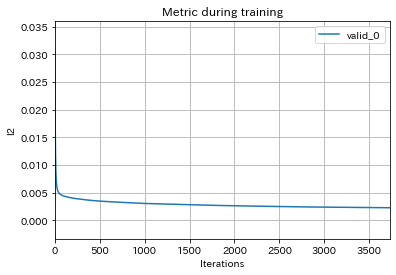

In [94]:
lgb.plot_metric(LGBM)

In [95]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [96]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.960459083536449
valid: 0.917737053407304
test: 0.901428659116362


In [97]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 2.3949957898789624
valid: 5.290240326567701
test: 6.617223209931795


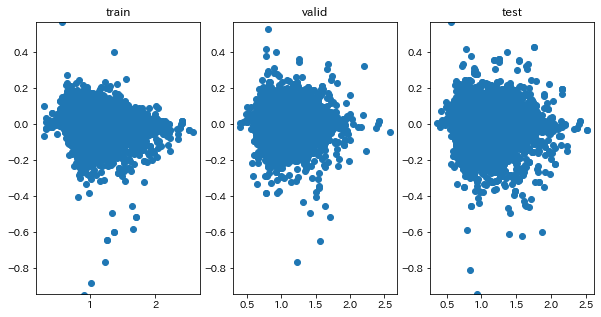

In [98]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [99]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature    importance
0   皇居からの距離   1193.362395
1  最寄駅からの距離    403.718040
2        面積  11356.262022
3       築年数   1929.113196
4        地上    959.199427
5         階    210.344012
6        地価   2521.277936
7        構造   1053.428423

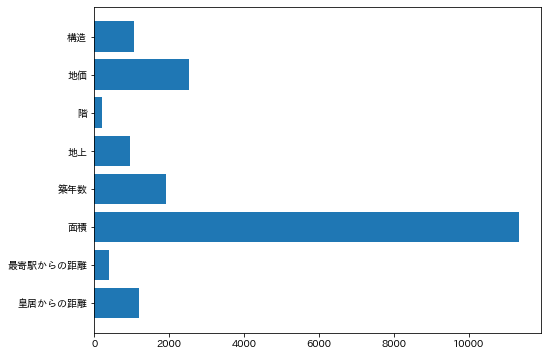

In [100]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig("./data/image/elite_feature_importances.png")
plt.show()

# 間取りと種別の情報を面積に変換（元の面積は削除）

結論：種別も構造も要らないらしい。

In [170]:
# 準備フェイズ

# 事前のデータ加工なし
# 順番をシャッフル
suumo_light = copy.copy(suumo.sample(frac=1,random_state=2))

# 変数は(だいたい使うであろう皆さんを)全部そのまま使用
quantity_features = [
    '皇居からの距離',
#    '歩', # 13
#    'バス', # 16
#    '車', # 2
    '最寄駅からの距離',
#    '部屋数', # 4
    '面積',
    '築年数',
#    '階数', # 5
#    '地下', # 17
    '地上',
    '階',
#    'オプション数', # 0
#    '駐車場距離', # 14
#    '駐車場料金', # 6
#    '条件数', # 9
    '地価',
]
category_features = [
#    '市区町村',
#    '路線',
#    '駅',
#    '間取り',
#    '向き', # 1
#    '建物種別', # 10
#    '構造',
#    '入居', # 15
#    '取引態様',
]
is_features = [
#    '間取り_S', # 11
#    '間取り_L', # 7
#    '間取り_D', # 12
#    '間取り_K', # 3
#    '駐車場有無', # 8
]
target_feature = '家賃'
features = np.r_[quantity_features,category_features,is_features]



In [171]:
# 地価変数を導入するゾ
land_price = pd.read_csv('./data/csv/land_price.csv').drop('Unnamed: 0',axis=1)

suumo_light = pd.merge(suumo_light, land_price, left_on='市区町村', right_on='区', how='left')
suumo_light.drop(['市区町村','区'],axis=1,inplace=True)

In [172]:
# 間取りと構造ごとの面積の平均
madori_area_mean = suumo_light.groupby(['間取り','建物種別'], as_index=False).mean()[['間取り','建物種別','面積']]
suumo_light.drop(['面積'],axis=1,inplace=True)
suumo_light = pd.merge(suumo_light, madori_area_mean, on=['間取り','建物種別'], how='left')

In [173]:
# カテゴリ変数をLabelEncoding
LE = LabelEncoder()
for feature in category_features:
    suumo_light[feature] = LE.fit_transform(suumo_light[feature])
    # ラベル対応表も作っておく
    num = np.arange(suumo_light[feature].unique().shape[0])
    name = LE.inverse_transform(num)
    exec(f"table_{feature} = pd.DataFrame(np.c_[num,name],columns=['num','name'])")
    
# カテゴリとisをカテゴリ型に変換
suumo_light[category_features] = suumo_light[category_features].astype('category')
suumo_light[is_features] = suumo_light[is_features].astype('category')

In [174]:
# 賃料に対数変換を施す
suumo_light['家賃'] = np.log10(suumo_light['家賃'])

In [175]:
# Xとyを定義
X = suumo_light[features]
y = suumo_light[target_feature]


# 学習用とテスト用に分割
train_test = 0.7
train_valid = 0.8

X_train_before, X_test, y_train_before, y_test = train_test_split(X, y, train_size = train_test, random_state = 0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_before, y_train_before, train_size = train_valid, random_state = 0)

In [176]:
# モデルを構築、学習

LGBM = lgb.LGBMRegressor(
    n_estimators = 5000,
#    num_leaves = 1000, 
    random_state = 0,
    importance_type = 'gain'
)

verbose_eval = 1
LGBM.fit(X_train,y_train,
        eval_set=[(X_valid,y_valid)],
        eval_metric = 'mse',
        callbacks = [lgb.early_stopping(stopping_rounds=10,verbose=True),
                    lgb.log_evaluation(verbose_eval)])

[1]	valid_0's l2: 0.0302745
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0260009
[3]	valid_0's l2: 0.0225405
[4]	valid_0's l2: 0.019672
[5]	valid_0's l2: 0.0173469
[6]	valid_0's l2: 0.015421
[7]	valid_0's l2: 0.0138437
[8]	valid_0's l2: 0.012532
[9]	valid_0's l2: 0.0114156
[10]	valid_0's l2: 0.0105002
[11]	valid_0's l2: 0.00973436
[12]	valid_0's l2: 0.00908764
[13]	valid_0's l2: 0.0085413
[14]	valid_0's l2: 0.00807788
[15]	valid_0's l2: 0.00768036
[16]	valid_0's l2: 0.00735223
[17]	valid_0's l2: 0.00706403
[18]	valid_0's l2: 0.00681652
[19]	valid_0's l2: 0.00660872
[20]	valid_0's l2: 0.00642808
[21]	valid_0's l2: 0.00626685
[22]	valid_0's l2: 0.00612083
[23]	valid_0's l2: 0.00599998
[24]	valid_0's l2: 0.00589962
[25]	valid_0's l2: 0.00578807
[26]	valid_0's l2: 0.00569338
[27]	valid_0's l2: 0.00561678
[28]	valid_0's l2: 0.00554083
[29]	valid_0's l2: 0.00548116
[30]	valid_0's l2: 0.0054314
[31]	valid_0's l2: 0.00537983
[32]	valid_0's l2: 0.00533393
[33

[296]	valid_0's l2: 0.0038014
[297]	valid_0's l2: 0.00379912
[298]	valid_0's l2: 0.00379736
[299]	valid_0's l2: 0.00379608
[300]	valid_0's l2: 0.00379306
[301]	valid_0's l2: 0.00379102
[302]	valid_0's l2: 0.00379048
[303]	valid_0's l2: 0.00378831
[304]	valid_0's l2: 0.00378614
[305]	valid_0's l2: 0.00378394
[306]	valid_0's l2: 0.00378241
[307]	valid_0's l2: 0.00378002
[308]	valid_0's l2: 0.0037786
[309]	valid_0's l2: 0.00377616
[310]	valid_0's l2: 0.00377366
[311]	valid_0's l2: 0.00377372
[312]	valid_0's l2: 0.00377145
[313]	valid_0's l2: 0.00377003
[314]	valid_0's l2: 0.00376835
[315]	valid_0's l2: 0.00376686
[316]	valid_0's l2: 0.00376474
[317]	valid_0's l2: 0.00376363
[318]	valid_0's l2: 0.00375986
[319]	valid_0's l2: 0.00375794
[320]	valid_0's l2: 0.00375662
[321]	valid_0's l2: 0.00375485
[322]	valid_0's l2: 0.00375303
[323]	valid_0's l2: 0.00375036
[324]	valid_0's l2: 0.00374923
[325]	valid_0's l2: 0.00374766
[326]	valid_0's l2: 0.00374587
[327]	valid_0's l2: 0.00374477
[328]	vali

[576]	valid_0's l2: 0.00342549
[577]	valid_0's l2: 0.0034245
[578]	valid_0's l2: 0.00342366
[579]	valid_0's l2: 0.00342312
[580]	valid_0's l2: 0.003422
[581]	valid_0's l2: 0.00342115
[582]	valid_0's l2: 0.00341937
[583]	valid_0's l2: 0.00341798
[584]	valid_0's l2: 0.0034169
[585]	valid_0's l2: 0.00341604
[586]	valid_0's l2: 0.0034158
[587]	valid_0's l2: 0.00341476
[588]	valid_0's l2: 0.00341468
[589]	valid_0's l2: 0.00341288
[590]	valid_0's l2: 0.00341048
[591]	valid_0's l2: 0.00340959
[592]	valid_0's l2: 0.00340838
[593]	valid_0's l2: 0.00340738
[594]	valid_0's l2: 0.00340694
[595]	valid_0's l2: 0.00340523
[596]	valid_0's l2: 0.00340504
[597]	valid_0's l2: 0.00340448
[598]	valid_0's l2: 0.00340259
[599]	valid_0's l2: 0.00340212
[600]	valid_0's l2: 0.00340106
[601]	valid_0's l2: 0.00340012
[602]	valid_0's l2: 0.00339901
[603]	valid_0's l2: 0.00339836
[604]	valid_0's l2: 0.00339716
[605]	valid_0's l2: 0.00339665
[606]	valid_0's l2: 0.00339589
[607]	valid_0's l2: 0.00339523
[608]	valid_0

[874]	valid_0's l2: 0.00318013
[875]	valid_0's l2: 0.00317973
[876]	valid_0's l2: 0.00317926
[877]	valid_0's l2: 0.00317886
[878]	valid_0's l2: 0.00317778
[879]	valid_0's l2: 0.00317731
[880]	valid_0's l2: 0.00317666
[881]	valid_0's l2: 0.00317589
[882]	valid_0's l2: 0.00317536
[883]	valid_0's l2: 0.00317501
[884]	valid_0's l2: 0.00317461
[885]	valid_0's l2: 0.00317401
[886]	valid_0's l2: 0.00317348
[887]	valid_0's l2: 0.00317265
[888]	valid_0's l2: 0.00317212
[889]	valid_0's l2: 0.00317161
[890]	valid_0's l2: 0.00317066
[891]	valid_0's l2: 0.00316996
[892]	valid_0's l2: 0.00316957
[893]	valid_0's l2: 0.00316887
[894]	valid_0's l2: 0.00316857
[895]	valid_0's l2: 0.00316783
[896]	valid_0's l2: 0.0031671
[897]	valid_0's l2: 0.00316683
[898]	valid_0's l2: 0.00316607
[899]	valid_0's l2: 0.00316547
[900]	valid_0's l2: 0.00316526
[901]	valid_0's l2: 0.0031644
[902]	valid_0's l2: 0.00316377
[903]	valid_0's l2: 0.00316258
[904]	valid_0's l2: 0.00316127
[905]	valid_0's l2: 0.00316011
[906]	vali

[1157]	valid_0's l2: 0.00298785
[1158]	valid_0's l2: 0.0029871
[1159]	valid_0's l2: 0.00298675
[1160]	valid_0's l2: 0.00298592
[1161]	valid_0's l2: 0.00298517
[1162]	valid_0's l2: 0.00298436
[1163]	valid_0's l2: 0.00298419
[1164]	valid_0's l2: 0.00298344
[1165]	valid_0's l2: 0.00298273
[1166]	valid_0's l2: 0.00298186
[1167]	valid_0's l2: 0.00298065
[1168]	valid_0's l2: 0.00298005
[1169]	valid_0's l2: 0.00297945
[1170]	valid_0's l2: 0.00297949
[1171]	valid_0's l2: 0.00297887
[1172]	valid_0's l2: 0.00297835
[1173]	valid_0's l2: 0.00297732
[1174]	valid_0's l2: 0.00297654
[1175]	valid_0's l2: 0.0029767
[1176]	valid_0's l2: 0.00297641
[1177]	valid_0's l2: 0.00297602
[1178]	valid_0's l2: 0.00297588
[1179]	valid_0's l2: 0.00297594
[1180]	valid_0's l2: 0.00297509
[1181]	valid_0's l2: 0.00297385
[1182]	valid_0's l2: 0.00297257
[1183]	valid_0's l2: 0.00297209
[1184]	valid_0's l2: 0.00297189
[1185]	valid_0's l2: 0.00297132
[1186]	valid_0's l2: 0.00297083
[1187]	valid_0's l2: 0.00296966
[1188]	val

[1447]	valid_0's l2: 0.00284441
[1448]	valid_0's l2: 0.00284399
[1449]	valid_0's l2: 0.00284323
[1450]	valid_0's l2: 0.00284274
[1451]	valid_0's l2: 0.00284248
[1452]	valid_0's l2: 0.00284213
[1453]	valid_0's l2: 0.0028419
[1454]	valid_0's l2: 0.00284177
[1455]	valid_0's l2: 0.00284171
[1456]	valid_0's l2: 0.00284128
[1457]	valid_0's l2: 0.00284078
[1458]	valid_0's l2: 0.00284021
[1459]	valid_0's l2: 0.00284011
[1460]	valid_0's l2: 0.00283956
[1461]	valid_0's l2: 0.00283927
[1462]	valid_0's l2: 0.00283871
[1463]	valid_0's l2: 0.0028384
[1464]	valid_0's l2: 0.00283798
[1465]	valid_0's l2: 0.00283754
[1466]	valid_0's l2: 0.00283743
[1467]	valid_0's l2: 0.00283666
[1468]	valid_0's l2: 0.00283637
[1469]	valid_0's l2: 0.00283592
[1470]	valid_0's l2: 0.00283546
[1471]	valid_0's l2: 0.00283486
[1472]	valid_0's l2: 0.0028348
[1473]	valid_0's l2: 0.00283465
[1474]	valid_0's l2: 0.00283411
[1475]	valid_0's l2: 0.0028338
[1476]	valid_0's l2: 0.00283395
[1477]	valid_0's l2: 0.00283381
[1478]	valid

[1738]	valid_0's l2: 0.00273943
[1739]	valid_0's l2: 0.00273921
[1740]	valid_0's l2: 0.00273886
[1741]	valid_0's l2: 0.0027386
[1742]	valid_0's l2: 0.0027382
[1743]	valid_0's l2: 0.00273764
[1744]	valid_0's l2: 0.00273715
[1745]	valid_0's l2: 0.00273687
[1746]	valid_0's l2: 0.00273617
[1747]	valid_0's l2: 0.00273595
[1748]	valid_0's l2: 0.00273586
[1749]	valid_0's l2: 0.0027355
[1750]	valid_0's l2: 0.00273546
[1751]	valid_0's l2: 0.00273511
[1752]	valid_0's l2: 0.00273469
[1753]	valid_0's l2: 0.00273444
[1754]	valid_0's l2: 0.00273432
[1755]	valid_0's l2: 0.002734
[1756]	valid_0's l2: 0.00273355
[1757]	valid_0's l2: 0.00273308
[1758]	valid_0's l2: 0.00273274
[1759]	valid_0's l2: 0.0027323
[1760]	valid_0's l2: 0.00273097
[1761]	valid_0's l2: 0.00273065
[1762]	valid_0's l2: 0.00273038
[1763]	valid_0's l2: 0.00273011
[1764]	valid_0's l2: 0.00272973
[1765]	valid_0's l2: 0.00272942
[1766]	valid_0's l2: 0.00272917
[1767]	valid_0's l2: 0.00272897
[1768]	valid_0's l2: 0.00272831
[1769]	valid_0

[2020]	valid_0's l2: 0.00265074
[2021]	valid_0's l2: 0.00265041
[2022]	valid_0's l2: 0.00264983
[2023]	valid_0's l2: 0.00264964
[2024]	valid_0's l2: 0.0026493
[2025]	valid_0's l2: 0.00264905
[2026]	valid_0's l2: 0.00264857
[2027]	valid_0's l2: 0.00264735
[2028]	valid_0's l2: 0.00264661
[2029]	valid_0's l2: 0.00264614
[2030]	valid_0's l2: 0.00264576
[2031]	valid_0's l2: 0.00264548
[2032]	valid_0's l2: 0.00264527
[2033]	valid_0's l2: 0.00264502
[2034]	valid_0's l2: 0.0026444
[2035]	valid_0's l2: 0.00264384
[2036]	valid_0's l2: 0.00264333
[2037]	valid_0's l2: 0.00264304
[2038]	valid_0's l2: 0.00264295
[2039]	valid_0's l2: 0.002643
[2040]	valid_0's l2: 0.00264271
[2041]	valid_0's l2: 0.00264219
[2042]	valid_0's l2: 0.00264159
[2043]	valid_0's l2: 0.0026411
[2044]	valid_0's l2: 0.00264092
[2045]	valid_0's l2: 0.00264056
[2046]	valid_0's l2: 0.00263995
[2047]	valid_0's l2: 0.0026396
[2048]	valid_0's l2: 0.00263939
[2049]	valid_0's l2: 0.00263892
[2050]	valid_0's l2: 0.00263859
[2051]	valid_0

[2321]	valid_0's l2: 0.00256878
[2322]	valid_0's l2: 0.00256856
[2323]	valid_0's l2: 0.00256827
[2324]	valid_0's l2: 0.00256777
[2325]	valid_0's l2: 0.00256758
[2326]	valid_0's l2: 0.00256731
[2327]	valid_0's l2: 0.00256715
[2328]	valid_0's l2: 0.00256714
[2329]	valid_0's l2: 0.00256691
[2330]	valid_0's l2: 0.00256568
[2331]	valid_0's l2: 0.0025656
[2332]	valid_0's l2: 0.00256548
[2333]	valid_0's l2: 0.00256539
[2334]	valid_0's l2: 0.00256507
[2335]	valid_0's l2: 0.00256498
[2336]	valid_0's l2: 0.0025647
[2337]	valid_0's l2: 0.00256443
[2338]	valid_0's l2: 0.00256394
[2339]	valid_0's l2: 0.00256344
[2340]	valid_0's l2: 0.00256339
[2341]	valid_0's l2: 0.00256319
[2342]	valid_0's l2: 0.00256311
[2343]	valid_0's l2: 0.00256316
[2344]	valid_0's l2: 0.00256297
[2345]	valid_0's l2: 0.00256286
[2346]	valid_0's l2: 0.00256238
[2347]	valid_0's l2: 0.00256209
[2348]	valid_0's l2: 0.00256163
[2349]	valid_0's l2: 0.00256152
[2350]	valid_0's l2: 0.00256134
[2351]	valid_0's l2: 0.00256108
[2352]	val

[2603]	valid_0's l2: 0.00250219
[2604]	valid_0's l2: 0.00250199
[2605]	valid_0's l2: 0.00250186
[2606]	valid_0's l2: 0.00250191
[2607]	valid_0's l2: 0.00250182
[2608]	valid_0's l2: 0.00250164
[2609]	valid_0's l2: 0.00250149
[2610]	valid_0's l2: 0.00250125
[2611]	valid_0's l2: 0.00250122
[2612]	valid_0's l2: 0.00250105
[2613]	valid_0's l2: 0.00250105
[2614]	valid_0's l2: 0.00250101
[2615]	valid_0's l2: 0.00250089
[2616]	valid_0's l2: 0.00250086
[2617]	valid_0's l2: 0.00250082
[2618]	valid_0's l2: 0.00250056
[2619]	valid_0's l2: 0.00250032
[2620]	valid_0's l2: 0.0025003
[2621]	valid_0's l2: 0.00250064
[2622]	valid_0's l2: 0.00250051
[2623]	valid_0's l2: 0.00250047
[2624]	valid_0's l2: 0.00250057
[2625]	valid_0's l2: 0.00250054
[2626]	valid_0's l2: 0.00250021
[2627]	valid_0's l2: 0.00250014
[2628]	valid_0's l2: 0.00249997
[2629]	valid_0's l2: 0.00249975
[2630]	valid_0's l2: 0.00249925
[2631]	valid_0's l2: 0.00249906
[2632]	valid_0's l2: 0.00249912
[2633]	valid_0's l2: 0.00249902
[2634]	va

[2892]	valid_0's l2: 0.00244332
[2893]	valid_0's l2: 0.0024428
[2894]	valid_0's l2: 0.00244253
[2895]	valid_0's l2: 0.00244232
[2896]	valid_0's l2: 0.00244209
[2897]	valid_0's l2: 0.002442
[2898]	valid_0's l2: 0.00244195
[2899]	valid_0's l2: 0.00244191
[2900]	valid_0's l2: 0.00244159
[2901]	valid_0's l2: 0.00244142
[2902]	valid_0's l2: 0.00244123
[2903]	valid_0's l2: 0.00244107
[2904]	valid_0's l2: 0.00244104
[2905]	valid_0's l2: 0.00244091
[2906]	valid_0's l2: 0.00244092
[2907]	valid_0's l2: 0.00244027
[2908]	valid_0's l2: 0.00244021
[2909]	valid_0's l2: 0.00244008
[2910]	valid_0's l2: 0.00244002
[2911]	valid_0's l2: 0.00243984
[2912]	valid_0's l2: 0.0024397
[2913]	valid_0's l2: 0.00243943
[2914]	valid_0's l2: 0.00243931
[2915]	valid_0's l2: 0.00243923
[2916]	valid_0's l2: 0.00243899
[2917]	valid_0's l2: 0.00243867
[2918]	valid_0's l2: 0.00243863
[2919]	valid_0's l2: 0.00243859
[2920]	valid_0's l2: 0.00243866
[2921]	valid_0's l2: 0.00243873
[2922]	valid_0's l2: 0.00243854
[2923]	valid

[3157]	valid_0's l2: 0.00239284
[3158]	valid_0's l2: 0.00239252
[3159]	valid_0's l2: 0.00239238
[3160]	valid_0's l2: 0.00239207
[3161]	valid_0's l2: 0.002392
[3162]	valid_0's l2: 0.00239197
[3163]	valid_0's l2: 0.00239193
[3164]	valid_0's l2: 0.00239184
[3165]	valid_0's l2: 0.00239174
[3166]	valid_0's l2: 0.00239156
[3167]	valid_0's l2: 0.00239123
[3168]	valid_0's l2: 0.00239108
[3169]	valid_0's l2: 0.00239103
[3170]	valid_0's l2: 0.00239082
[3171]	valid_0's l2: 0.00239055
[3172]	valid_0's l2: 0.00239038
[3173]	valid_0's l2: 0.00239024
[3174]	valid_0's l2: 0.00239005
[3175]	valid_0's l2: 0.00238994
[3176]	valid_0's l2: 0.00238979
[3177]	valid_0's l2: 0.00238943
[3178]	valid_0's l2: 0.00238946
[3179]	valid_0's l2: 0.00238927
[3180]	valid_0's l2: 0.00238901
[3181]	valid_0's l2: 0.00238855
[3182]	valid_0's l2: 0.00238829
[3183]	valid_0's l2: 0.00238809
[3184]	valid_0's l2: 0.00238802
[3185]	valid_0's l2: 0.00238789
[3186]	valid_0's l2: 0.00238794
[3187]	valid_0's l2: 0.00238777
[3188]	val

[3415]	valid_0's l2: 0.00235261
[3416]	valid_0's l2: 0.00235246
[3417]	valid_0's l2: 0.00235228
[3418]	valid_0's l2: 0.00235212
[3419]	valid_0's l2: 0.00235175
[3420]	valid_0's l2: 0.00235159
[3421]	valid_0's l2: 0.00235144
[3422]	valid_0's l2: 0.00235145
[3423]	valid_0's l2: 0.00235135
[3424]	valid_0's l2: 0.0023514
[3425]	valid_0's l2: 0.00235141
[3426]	valid_0's l2: 0.00235118
[3427]	valid_0's l2: 0.00235095
[3428]	valid_0's l2: 0.00235076
[3429]	valid_0's l2: 0.00235072
[3430]	valid_0's l2: 0.00235048
[3431]	valid_0's l2: 0.00235025
[3432]	valid_0's l2: 0.00235019
[3433]	valid_0's l2: 0.00235001
[3434]	valid_0's l2: 0.00234995
[3435]	valid_0's l2: 0.00234974
[3436]	valid_0's l2: 0.00234959
[3437]	valid_0's l2: 0.0023494
[3438]	valid_0's l2: 0.00234921
[3439]	valid_0's l2: 0.00234874
[3440]	valid_0's l2: 0.00234858
[3441]	valid_0's l2: 0.0023484
[3442]	valid_0's l2: 0.00234826
[3443]	valid_0's l2: 0.00234782
[3444]	valid_0's l2: 0.00234751
[3445]	valid_0's l2: 0.00234745
[3446]	vali

[3694]	valid_0's l2: 0.00231216
[3695]	valid_0's l2: 0.00231205
[3696]	valid_0's l2: 0.00231192
[3697]	valid_0's l2: 0.00231187
[3698]	valid_0's l2: 0.00231189
[3699]	valid_0's l2: 0.00231169
[3700]	valid_0's l2: 0.00231158
[3701]	valid_0's l2: 0.0023116
[3702]	valid_0's l2: 0.0023115
[3703]	valid_0's l2: 0.00231144
[3704]	valid_0's l2: 0.00231131
[3705]	valid_0's l2: 0.00231126
[3706]	valid_0's l2: 0.00231119
[3707]	valid_0's l2: 0.00231111
[3708]	valid_0's l2: 0.00231101
[3709]	valid_0's l2: 0.00231091
[3710]	valid_0's l2: 0.00231059
[3711]	valid_0's l2: 0.00231046
[3712]	valid_0's l2: 0.00231032
[3713]	valid_0's l2: 0.0023101
[3714]	valid_0's l2: 0.00230975
[3715]	valid_0's l2: 0.00230975
[3716]	valid_0's l2: 0.00230961
[3717]	valid_0's l2: 0.00230966
[3718]	valid_0's l2: 0.00230944
[3719]	valid_0's l2: 0.00230931
[3720]	valid_0's l2: 0.00230889
[3721]	valid_0's l2: 0.00230876
[3722]	valid_0's l2: 0.00230858
[3723]	valid_0's l2: 0.00230846
[3724]	valid_0's l2: 0.00230836
[3725]	vali

[3990]	valid_0's l2: 0.00227713
[3991]	valid_0's l2: 0.00227719
[3992]	valid_0's l2: 0.00227701
[3993]	valid_0's l2: 0.00227688
[3994]	valid_0's l2: 0.00227674
[3995]	valid_0's l2: 0.00227671
[3996]	valid_0's l2: 0.00227657
[3997]	valid_0's l2: 0.00227651
[3998]	valid_0's l2: 0.0022765
[3999]	valid_0's l2: 0.00227655
[4000]	valid_0's l2: 0.00227648
[4001]	valid_0's l2: 0.00227625
[4002]	valid_0's l2: 0.00227623
[4003]	valid_0's l2: 0.00227613
[4004]	valid_0's l2: 0.00227615
[4005]	valid_0's l2: 0.00227618
[4006]	valid_0's l2: 0.00227609
[4007]	valid_0's l2: 0.00227592
[4008]	valid_0's l2: 0.00227563
[4009]	valid_0's l2: 0.00227553
[4010]	valid_0's l2: 0.00227531
[4011]	valid_0's l2: 0.00227523
[4012]	valid_0's l2: 0.00227511
[4013]	valid_0's l2: 0.00227502
[4014]	valid_0's l2: 0.00227489
[4015]	valid_0's l2: 0.00227461
[4016]	valid_0's l2: 0.00227449
[4017]	valid_0's l2: 0.00227415
[4018]	valid_0's l2: 0.00227391
[4019]	valid_0's l2: 0.00227387
[4020]	valid_0's l2: 0.00227383
[4021]	va

[4265]	valid_0's l2: 0.00224367
[4266]	valid_0's l2: 0.0022436
[4267]	valid_0's l2: 0.00224362
[4268]	valid_0's l2: 0.00224337
[4269]	valid_0's l2: 0.00224331
[4270]	valid_0's l2: 0.0022431
[4271]	valid_0's l2: 0.00224294
[4272]	valid_0's l2: 0.00224303
[4273]	valid_0's l2: 0.0022429
[4274]	valid_0's l2: 0.0022428
[4275]	valid_0's l2: 0.00224276
[4276]	valid_0's l2: 0.00224272
[4277]	valid_0's l2: 0.00224268
[4278]	valid_0's l2: 0.00224259
[4279]	valid_0's l2: 0.00224236
[4280]	valid_0's l2: 0.00224227
[4281]	valid_0's l2: 0.00224214
[4282]	valid_0's l2: 0.00224214
[4283]	valid_0's l2: 0.00224206
[4284]	valid_0's l2: 0.002242
[4285]	valid_0's l2: 0.00224197
[4286]	valid_0's l2: 0.00224185
[4287]	valid_0's l2: 0.00224174
[4288]	valid_0's l2: 0.0022415
[4289]	valid_0's l2: 0.00224143
[4290]	valid_0's l2: 0.0022414
[4291]	valid_0's l2: 0.00224132
[4292]	valid_0's l2: 0.0022412
[4293]	valid_0's l2: 0.00224116
[4294]	valid_0's l2: 0.00224119
[4295]	valid_0's l2: 0.00224099
[4296]	valid_0's 

[4551]	valid_0's l2: 0.00220934
[4552]	valid_0's l2: 0.00220916
[4553]	valid_0's l2: 0.00220915
[4554]	valid_0's l2: 0.002209
[4555]	valid_0's l2: 0.00220843
[4556]	valid_0's l2: 0.00220837
[4557]	valid_0's l2: 0.00220821
[4558]	valid_0's l2: 0.00220802
[4559]	valid_0's l2: 0.00220787
[4560]	valid_0's l2: 0.00220787
[4561]	valid_0's l2: 0.0022079
[4562]	valid_0's l2: 0.00220787
[4563]	valid_0's l2: 0.00220788
[4564]	valid_0's l2: 0.00220777
[4565]	valid_0's l2: 0.00220775
[4566]	valid_0's l2: 0.00220756
[4567]	valid_0's l2: 0.00220753
[4568]	valid_0's l2: 0.00220744
[4569]	valid_0's l2: 0.00220731
[4570]	valid_0's l2: 0.00220724
[4571]	valid_0's l2: 0.00220703
[4572]	valid_0's l2: 0.0022068
[4573]	valid_0's l2: 0.00220674
[4574]	valid_0's l2: 0.0022067
[4575]	valid_0's l2: 0.00220658
[4576]	valid_0's l2: 0.00220656
[4577]	valid_0's l2: 0.00220648
[4578]	valid_0's l2: 0.0022063
[4579]	valid_0's l2: 0.0022063
[4580]	valid_0's l2: 0.00220622
[4581]	valid_0's l2: 0.00220609
[4582]	valid_0'

[4837]	valid_0's l2: 0.00217992
[4838]	valid_0's l2: 0.0021798
[4839]	valid_0's l2: 0.0021796
[4840]	valid_0's l2: 0.00217944
[4841]	valid_0's l2: 0.00217944
[4842]	valid_0's l2: 0.00217945
[4843]	valid_0's l2: 0.00217947
[4844]	valid_0's l2: 0.00217941
[4845]	valid_0's l2: 0.00217928
[4846]	valid_0's l2: 0.00217923
[4847]	valid_0's l2: 0.00217905
[4848]	valid_0's l2: 0.00217882
[4849]	valid_0's l2: 0.00217871
[4850]	valid_0's l2: 0.00217867
[4851]	valid_0's l2: 0.00217824
[4852]	valid_0's l2: 0.00217796
[4853]	valid_0's l2: 0.00217784
[4854]	valid_0's l2: 0.00217771
[4855]	valid_0's l2: 0.00217767
[4856]	valid_0's l2: 0.00217764
[4857]	valid_0's l2: 0.00217751
[4858]	valid_0's l2: 0.00217747
[4859]	valid_0's l2: 0.0021773
[4860]	valid_0's l2: 0.00217735
[4861]	valid_0's l2: 0.00217715
[4862]	valid_0's l2: 0.00217692
[4863]	valid_0's l2: 0.00217692
[4864]	valid_0's l2: 0.00217684
[4865]	valid_0's l2: 0.00217665
[4866]	valid_0's l2: 0.00217651
[4867]	valid_0's l2: 0.0021765
[4868]	valid

LGBMRegressor(importance_type='gain', n_estimators=5000, random_state=0)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

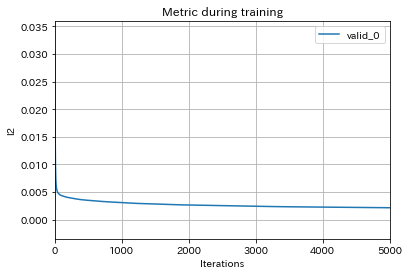

In [177]:
lgb.plot_metric(LGBM)

In [178]:
# それぞれの予測結果を収納
y_train_pred = LGBM.predict(X_train)
y_valid_pred = LGBM.predict(X_valid)
y_test_pred = LGBM.predict(X_test)

In [179]:
# それぞれのr2スコアを算出
print('train:',r2_score(10**y_train,10**y_train_pred))
print('valid:',r2_score(10**y_valid,10**y_valid_pred))
print('test:',r2_score(10**y_test,10**y_test_pred))

train: 0.9666211590774676
valid: 0.9158704548184756
test: 0.8897655136505587


In [180]:
# それぞれのMSEを算出
print('train:',mean_squared_error(10**y_train,10**y_train_pred))
print('valid:',mean_squared_error(10**y_valid,10**y_valid_pred))
print('test:',mean_squared_error(10**y_test,10**y_test_pred))

train: 2.021758487924678
valid: 5.410279244903883
test: 7.400185439980311


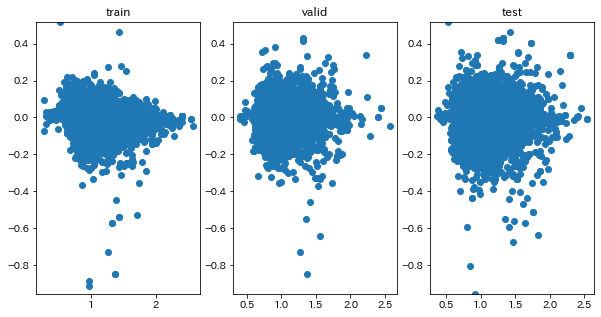

In [181]:
# それぞれの残差プロット
fig = plt.figure(figsize=(10,5))

error_train = y_train_pred - y_train
error_valid = y_valid_pred - y_valid
error_test = y_test_pred - y_test

max_ = error_test.max()
min_ = error_test.min()

ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

ax1.scatter(y_train_pred, error_train)
ax1.title.set_text('train')
ax1.set_ylim(min_,max_)
ax2.scatter(y_valid_pred, error_valid)
ax2.title.set_text('valid')
ax2.set_ylim(min_,max_)
ax3.scatter(y_test_pred, error_test)
ax3.title.set_text('test')
ax3.set_ylim(min_,max_)

plt.show()

In [182]:
# 変数重要度
table_importances = pd.DataFrame(np.c_[features, LGBM.feature_importances_],columns=['feature','importance'])
table_importances['importance'] = table_importances['importance'].astype(float)
table_importances

feature    importance
0   皇居からの距離   1140.325167
1  最寄駅からの距離    415.622000
2        面積  12411.502796
3       築年数   2206.408309
4        地上    920.223319
5         階    228.713490
6        地価   2423.330773

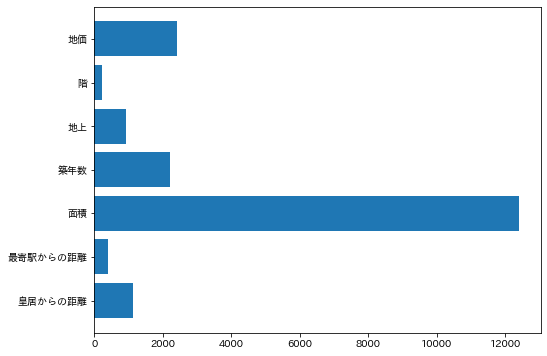

In [183]:
# 変数重要度
plt.figure(figsize=(8,6))
plt.barh(table_importances['feature'],table_importances['importance'])
plt.savefig("./data/image/elite_feature_importances.png")
plt.show()